In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd
import seaborn as sns
import os

In [2]:
path = r'/Volumes/Behaviour 3/Bodyvectors_05_2000'
# NOTE: These should have been named 'bodyvectors_05_2000.csv', however I accidentally named them 07, 
# which refers to the likelyhood. We are using bodyvectors gnerated with 05 liklihood. 
bodies = [body for body in os.listdir(path) if body.endswith('bodyvectors_07_2000.csv')] 
correct = pd.read_csv('/Volumes/Behaviour/Bodyvectors_05_2000/2P05_Ses01_25OCT2021_approach_Trial_1_89009_bodyvectors_07_2000.csv')
cor_cols = list(correct.columns)

In [196]:
trial_count = 0
bigcount = 0
responses = 0
single_responses = 0
#col_names = ['trial', 'response','on_lateny','off_latency','peak_response']
#local_responses = pd.DataFrame(columns=cols)

resp_traces = pd.DataFrame()
trials = []
response_types = []
on_latencies = []
off_latencies = []
peaks = []
body_ids = []
euclidean_dists = []

for body in bodies:
    response_type = 'no response'
    on_latency = 'NaN'
    off_latency = 'NaN'
    y_peak = 'NaN'
    euclid = 'NaN'
   
    #print('procesing: ', body)
    if body.startswith('._'): # circumventing issues caused by invisible files on the external drive
        continue
    
    meta = body.split("_")
    body_id = meta[0]+'_'+meta[1]+'_'+meta[2]+'_'+meta[3]+'_'+meta[4]+'_'+meta[5]+'_'+meta[6]
    body_ids.append(body_id)
    print(body_id)
    trial_count +=1
    print('trial count: ', trial_count)    
    b = pd.read_csv(os.path.join(path,body))
    ank = b.loc[10:,:]
    
    if ank.shape[1] < 1245:
        length = ank.shape[1]
        print(length, 'bodyvector is short')
        smallcount = 0
        cols = list(ank.columns)
        for c, cor_col in enumerate(cor_cols):
            if cor_col in cols:
                continue
            else: 
                if int(cor_col) > 0:
                    smallcount += 1 # counting the number of missing post-stimulus frames 
                ank[cor_col]=np.nan
    
        print('smallcount: ', smallcount)
        
        if smallcount > 63: # skip trials that have more than 10 % of post-stimulus frames missing
            print(body, ' doesnt have enough motion frames')
            bigcount += 1
            continue
            
    ank = ank[cor_cols]
    ank_mo = ank.diff(axis=1).abs() # compute frame-wise motion energy
    ank_mo = ank_mo.mean(axis=0) # calculate mean motion energy across body parts
    ank_mo[0] = np.nan # insert NaN column to maintain vector shape        
    ank_mo_bl = ank_mo.iloc[560:610].mean() # Baseline: I actually stop one frame earlier
    # Baseline: 50 frames (125 ms) taken up to two frames before stimuls (stimulatin on frame 612)
    res_threshold = ank_mo.iloc[560:610].mean() + ank_mo.iloc[560:610].std()*5
    bas_threshold = ank_mo.iloc[560:610].mean() + ank_mo.iloc[560:610].std()*1
    print(ank_mo_bl, res_threshold)
    
    traces = pd.DataFrame()
    if len(np.where(ank_mo.iloc[615:753] > res_threshold)[0]) > 12:
        #if (np.where(ank_mo.iloc[615:753] > res_threshold)[0][0]+12) > res_threshold:
        responses += 1
        response_type = 'continuous'
        start = np.where(ank_mo.iloc[615:753] > res_threshold)[0][0] + 615
        on_latency = (start-612)*2.5
        trace_x = ank.loc[10][start:start+140]
        trace_y = ank.loc[11][start:start+140]
        traces['ankle x'] = trace_x
        traces['ankle y'] = trace_y
        traces['trial'] = body_id
        resp_traces = pd.concat([resp_traces, traces])
        y_rest = ank.loc[11][start]
        y_peak = ank.loc[11][start:start+140].min()
        euclid = distance.euclidean(y_rest, y_peak)

        if len(np.where(ank_mo.iloc[start:start+140] < bas_threshold)[0]) > 50:
            single_responses += 1
            response_type = 'discrete'
            end = np.where(ank_mo.iloc[start:start+140] < bas_threshold)[0][0] + start
            off_latency = (end-612)*2.5
            #peak = ank.loc[11][start:start+140].max()
          
    trials.append(body_id)
    response_types.append(response_type)
    on_latencies.append(on_latency)
    off_latencies.append(off_latency)
    peaks.append(y_peak)
    euclidean_dists.append(euclid)
    data =[body_id, response_type, on_latency, off_latency, y_peak, euclid]
    print(data)
    
local_responses = pd.DataFrame()
local_responses['trial']=trials
local_responses['response']=response_types
local_responses['on_latency']=on_latencies
local_responses['off_latency']=off_latencies
local_responses['peak_response']=peaks
local_responses['euclidean_peak']=euclidean_dists

2P05_Ses01_25OCT2021_approach_Trial_1_89009
trial count:  1
0.029774475097655965 0.12466342143346823
['2P05_Ses01_25OCT2021_approach_Trial_1_89009', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses01_25OCT2021_approach_Trial_2_94245
trial count:  2
0.03275680541992017 0.11280375896001968
['2P05_Ses01_25OCT2021_approach_Trial_2_94245', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses01_25OCT2021_approach_Trial_3_80975
trial count:  3
0.036157989501951135 0.13821256596538434
['2P05_Ses01_25OCT2021_approach_Trial_3_80975', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses01_25OCT2021_hot_Trial_1_44807
trial count:  4
1238 bodyvector is short
smallcount:  7


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.051672210693361934 0.24372365546993996
['2P05_Ses01_25OCT2021_hot_Trial_1_44807', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses01_25OCT2021_hot_Trial_2_24745
trial count:  5
0.037660675048828696 0.1167558008751089
['2P05_Ses01_25OCT2021_hot_Trial_2_24745', 'discrete', 37.5, 45.0, 231.22950744628903, 2.1241607666016193]
2P05_Ses01_25OCT2021_hot_Trial_3_58139
trial count:  6
0.03978378295898295 0.14420897263189292
['2P05_Ses01_25OCT2021_hot_Trial_3_58139', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses01_25OCT2021_no stim_Trial_1_34575
trial count:  7
0.04057525634765568 0.1587415905479307
['2P05_Ses01_25OCT2021_no stim_Trial_1_34575', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses01_25OCT2021_no stim_Trial_2_16867
trial count:  8
0.0371717834472625 0.11483343491116793
['2P05_Ses01_25OCT2021_no stim_Trial_2_16867', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses01_25OCT2021_no stim_Trial_3_34146
trial count:  9
0.03174026489257841 0.11063792299951816
['2P05_Ses01_25

0.039896240234371876 0.14504615778202182
['2P05_Ses03_28OCT2021_approach_Trial_1_46139', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses03_28OCT2021_approach_Trial_2_94869
trial count:  48
0.030111236572267046 0.1262602643870202
['2P05_Ses03_28OCT2021_approach_Trial_2_94869', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses03_28OCT2021_approach_Trial_3_46717
trial count:  49
0.041022796630859656 0.16838803557735316
['2P05_Ses03_28OCT2021_approach_Trial_3_46717', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses03_28OCT2021_hot_Trial_1_55627
trial count:  50
0.04282180786132557 0.15395855843665926
['2P05_Ses03_28OCT2021_hot_Trial_1_55627', 'continuous', 215.0, 'NaN', 234.82717895507807, 5.004623413086023]
2P05_Ses03_28OCT2021_hot_Trial_2_62770
trial count:  51
0.033789062500003124 0.15705795172403023
['2P05_Ses03_28OCT2021_hot_Trial_2_62770', 'discrete', 197.5, 232.5, 238.24989318847656, 5.637176513671875]
2P05_Ses03_28OCT2021_hot_Trial_3_89909
trial count:  52
0.02913131713866

0.04179519653320454 0.15977441887323224
['2P05_Ses04_01NOV2021_von frey_Trial_2_13612', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses04_01NOV2021_von frey_Trial_4_57322
trial count:  91
0.032071380615233805 0.12233633900749737
['2P05_Ses04_01NOV2021_von frey_Trial_4_57322', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses04_01NOV2021_warm_Trial_1_45855
trial count:  92
0.028472290039065627 0.11154796643433007
['2P05_Ses04_01NOV2021_warm_Trial_1_45855', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses04_01NOV2021_warm_Trial_2_22723
trial count:  93
0.03599227905273665 0.12812373231409208
['2P05_Ses04_01NOV2021_warm_Trial_2_22723', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses04_01NOV2021_warm_Trial_3_69340
trial count:  94
0.04063888549804545 0.14079765475823913
['2P05_Ses04_01NOV2021_warm_Trial_3_69340', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses05_02NOV2021_approach_Trial_1_76043
trial count:  95
0.17738586425781222 1.7792022432230854
['2P05_Ses05_02NOV2021_

0.03756912231445284 0.1404951298776275
['2P05_Ses06_03NOV2021_pin-prick_Trial_1_83098', 'discrete', 12.5, 45.0, 235.91542053222656, 5.86041259765625]
2P05_Ses06_03NOV2021_pin-prick_Trial_2_18466
trial count:  134
0.03387741088867045 0.12037753867902892
['2P05_Ses06_03NOV2021_pin-prick_Trial_2_18466', 'continuous', 12.5, 'NaN', 232.6654510498047, 8.277252197265625]
2P05_Ses06_03NOV2021_pin-prick_Trial_3_38156
trial count:  135
0.03261550903320938 0.11283228497980353
['2P05_Ses06_03NOV2021_pin-prick_Trial_3_38156', 'continuous', 12.5, 'NaN', 234.16180419921875, 6.230194091796847]
2P05_Ses06_03NOV2021_von frey_Trial_1_29493
trial count:  136
0.03813049316406961 0.1341195700830482
['2P05_Ses06_03NOV2021_von frey_Trial_1_29493', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses06_03NOV2021_von frey_Trial_2_95677
trial count:  137
0.05258590698242159 0.18535531262364724
['2P05_Ses06_03NOV2021_von frey_Trial_2_95677', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P05_Ses06_03NOV2021_von frey_

/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


smallcount:  402
2P06_Ses01_26OCT2021_off-target_Trial_1_60491_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P06_Ses01_26OCT2021_off-target_Trial_2_91940
trial count:  174
619 bodyvector is short
smallcount:  13
nan nan
['2P06_Ses01_26OCT2021_off-target_Trial_2_91940', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses01_26OCT2021_off-target_Trial_3_85032
trial count:  175
1233 bodyvector is short
smallcount:  12
0.06413101196289289 0.225752713446505
['2P06_Ses01_26OCT2021_off-target_Trial_3_85032', 'discrete', 22.5, 85.0, 220.4235992431641, 5.252044677734347]
2P06_Ses01_26OCT2021_opto_Trial_2_98353
trial count:  176
483 bodyvector is short
smallcount:  283
2P06_Ses01_26OCT2021_opto_Trial_2_98353_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P06_Ses01_26OCT2021_opto_Trial_3_46579
trial count:  177
818 bodyvector is short
smallcount:  297
2P06_Ses01_26OCT2021_opto_Trial_3_46579_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P06_Ses01_26OCT2021_pin-

0.08284484863281363 0.32999830983811584
['2P06_Ses03_29OCT2021_no stim_Trial_1_80705', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses03_29OCT2021_no stim_Trial_2_97232
trial count:  217
0.0859863281250017 0.34898748428592596
['2P06_Ses03_29OCT2021_no stim_Trial_2_97232', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses03_29OCT2021_no stim_Trial_3_98016
trial count:  218
0.06719467163086022 0.2637617546259746
['2P06_Ses03_29OCT2021_no stim_Trial_3_98016', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses03_29OCT2021_off-target_Trial_1_58402
trial count:  219
0.03646392822265483 0.14438424791520757
['2P06_Ses03_29OCT2021_off-target_Trial_1_58402', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses03_29OCT2021_off-target_Trial_5_24173
trial count:  220
0.04619873046875085 0.16257146235686284
['2P06_Ses03_29OCT2021_off-target_Trial_5_24173', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses03_29OCT2021_off-target_Trial_6_62330
trial count:  221
0.05173858642578409 0.1974764558

0.036973419189454265 0.13558970093594724
['2P06_Ses05_03NOV2021_approach_Trial_2_58478', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses05_03NOV2021_approach_Trial_3_28430
trial count:  258
0.050566864013672726 0.17581752343688645
['2P06_Ses05_03NOV2021_approach_Trial_3_28430', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses05_03NOV2021_hot_Trial_1_25491
trial count:  259
0.02712127685547017 0.1023411341852601
['2P06_Ses05_03NOV2021_hot_Trial_1_25491', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses05_03NOV2021_hot_Trial_2_84017
trial count:  260
0.03209899902343949 0.11700691475518468
['2P06_Ses05_03NOV2021_hot_Trial_2_84017', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses05_03NOV2021_hot_Trial_3_56428
trial count:  261
0.03891998291015284 0.13870443644303854
['2P06_Ses05_03NOV2021_hot_Trial_3_56428', 'continuous', 307.5, 'NaN', 213.462158203125, 32.14894104003909]
2P06_Ses05_03NOV2021_no stim_Trial_1_96654
trial count:  262
0.08372390747070454 1.2041374933661477
['2P

0.36426467895507897 3.1433676001676867
['2P06_Ses06_04NOV2021_von frey_Trial_3_70280', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses06_04NOV2021_warm_Trial_1_85139
trial count:  300
0.03873199462890597 0.14114988309608692
['2P06_Ses06_04NOV2021_warm_Trial_1_85139', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses06_04NOV2021_warm_Trial_2_69196
trial count:  301
0.031845245361324714 0.11149315949629529
['2P06_Ses06_04NOV2021_warm_Trial_2_69196', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses06_04NOV2021_warm_Trial_3_46946
trial count:  302
0.046751708984373294 0.175828936792032
['2P06_Ses06_04NOV2021_warm_Trial_3_46946', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses07_09NOV2021_approach_Trial_1_64690
trial count:  303
0.05968261718749858 0.2080192953904042
['2P06_Ses07_09NOV2021_approach_Trial_1_64690', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P06_Ses07_09NOV2021_approach_Trial_2_36404
trial count:  304
0.05224899291992387 0.20851892079091155
['2P06_Ses07_09NOV202

0.03295150756836136 0.11782738351878679
['2P07_CFA_30NOV2021_warm_Trial_1_28100', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_CFA_30NOV2021_warm_Trial_2_51136
trial count:  345
0.03600265502929744 0.13903003675064507
['2P07_CFA_30NOV2021_warm_Trial_2_51136', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_CFA_30NOV2021_warm_Trial_3_83925
trial count:  346
0.048372955322268464 0.2177352228297717
['2P07_CFA_30NOV2021_warm_Trial_3_83925', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses01_10NOV2021_approach_Trial_1_83446
trial count:  347
0.03544494628906165 0.1474282572488822
['2P07_Ses01_10NOV2021_approach_Trial_1_83446', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses01_10NOV2021_approach_Trial_2_74245
trial count:  348
0.045346374511721875 0.14758132550572453
['2P07_Ses01_10NOV2021_approach_Trial_2_74245', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses01_10NOV2021_approach_Trial_3_22704
trial count:  349
0.09307495117187671 0.5825013302594731
['2P07_Ses01_10NOV2021_app

1210 bodyvector is short
smallcount:  35
0.06003448486328324 0.2193141291851705
['2P07_Ses02_11NOV2021_von frey_Trial_4_79925', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses02_11NOV2021_von frey_Trial_6_26362
trial count:  387
0.042355651855471875 0.154958377717641
['2P07_Ses02_11NOV2021_von frey_Trial_6_26362', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses03_12NOV2021_approach_Trial_1_96067
trial count:  388
0.03550903320312756 0.14171662383043276
['2P07_Ses03_12NOV2021_approach_Trial_1_96067', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses03_12NOV2021_approach_Trial_3_84967
trial count:  389
0.046257476806637214 0.1905649111894755
['2P07_Ses03_12NOV2021_approach_Trial_3_84967', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses03_12NOV2021_approach_Trial_4_84160
trial count:  390
0.039254913330076135 0.14966687620490027
['2P07_Ses03_12NOV2021_approach_Trial_4_84160', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses03_12NOV2021_hot_Trial_2_48450
trial count:  391


0.039923858642581536 0.1491873613739353
['2P07_Ses04_15NOV2021_von frey_Trial_2_68784', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses04_15NOV2021_von frey_Trial_3_80367
trial count:  428
0.05411132812499972 0.20166944659503164
['2P07_Ses04_15NOV2021_von frey_Trial_3_80367', 'discrete', 145.0, 150.0, 228.4165954589844, 0.05612182617184658]
2P07_Ses04_15NOV2021_warm_Trial_1_22655
trial count:  429
1190 bodyvector is short
smallcount:  54
0.12405319213867586 0.4110604685555207
['2P07_Ses04_15NOV2021_warm_Trial_1_22655', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses04_15NOV2021_warm_Trial_2_16399
trial count:  430
0.03656585693359716 0.15333289205001036
['2P07_Ses04_15NOV2021_warm_Trial_2_16399', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses04_15NOV2021_warm_Trial_3_92238
trial count:  431
0.042142639160158236 0.16023245550239068
['2P07_Ses04_15NOV2021_warm_Trial_3_92238', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses05_18NOV2021_approach_Trial_1_88443
trial count: 

0.04011291503906108 0.12938223635632048
['2P07_Ses06_22NOV2021_pin-prick_Trial_1_54890', 'discrete', 55.0, 57.5, 241.56088256835935, 2.2154693603515625]
2P07_Ses06_22NOV2021_pin-prick_Trial_3_31356
trial count:  470
0.03590591430663949 0.14046812435515377
['2P07_Ses06_22NOV2021_pin-prick_Trial_3_31356', 'discrete', 45.0, 95.0, 225.14300537109372, 9.18115234375]
2P07_Ses06_22NOV2021_pin-prick_Trial_5_44744
trial count:  471
0.04064178466797131 0.1426984527384902
['2P07_Ses06_22NOV2021_pin-prick_Trial_5_44744', 'continuous', 12.5, 'NaN', 218.4890594482422, 24.195709228515625]
2P07_Ses06_22NOV2021_von frey_Trial_1_76506
trial count:  472
0.03784561157226904 0.14170633205468436
['2P07_Ses06_22NOV2021_von frey_Trial_1_76506', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses06_22NOV2021_von frey_Trial_3_75465
trial count:  473
0.04147262573242017 0.14367973612862953
['2P07_Ses06_22NOV2021_von frey_Trial_3_75465', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P07_Ses06_22NOV2021_von frey_Tri

0.03415924072265824 0.12707511759000564
['2P08_CFA_30NOV2021_off-target_Trial_2_41580', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_CFA_30NOV2021_off-target_Trial_3_38454
trial count:  513
0.04099014282226591 0.1497589008922934
['2P08_CFA_30NOV2021_off-target_Trial_3_38454', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_CFA_30NOV2021_opto_Trial_2_24795
trial count:  514
0.05559753417968409 0.20914097556734318
['2P08_CFA_30NOV2021_opto_Trial_2_24795', 'discrete', 20.0, 170.0, 232.28634643554688, 14.470046997070312]
2P08_CFA_30NOV2021_opto_Trial_3_87722
trial count:  515
0.032010803222655114 0.10367909235494527
['2P08_CFA_30NOV2021_opto_Trial_3_87722', 'discrete', 17.5, 90.0, 241.60162353515625, 9.694793701171818]
2P08_CFA_30NOV2021_opto_Trial_4_70454
trial count:  516
0.07451049804687386 1.105169132003734
['2P08_CFA_30NOV2021_opto_Trial_4_70454', 'discrete', 20.0, 75.0, 232.62063598632807, 15.19660949707037]
2P08_CFA_30NOV2021_pin-prick_Trial_1_30869
trial count:  517
0.0433956909

0.03840301513672358 0.13158543334399217
['2P08_Ses02_12NOV2021_hot_Trial_2_41175', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses02_12NOV2021_no stim_Trial_1_59367
trial count:  556
0.034390716552734374 0.10607903707109304
['2P08_Ses02_12NOV2021_no stim_Trial_1_59367', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses02_12NOV2021_no stim_Trial_2_47160
trial count:  557
0.029178314208985798 0.1122887361214513
['2P08_Ses02_12NOV2021_no stim_Trial_2_47160', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses02_12NOV2021_no stim_Trial_3_90650
trial count:  558
0.03060775756836392 0.10562303960613659
['2P08_Ses02_12NOV2021_no stim_Trial_3_90650', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses02_12NOV2021_off-target_Trial_1_35344
trial count:  559
0.03002090454101989 0.13092532083261027
['2P08_Ses02_12NOV2021_off-target_Trial_1_35344', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses02_12NOV2021_off-target_Trial_2_85464
trial count:  560
0.13593536376952783 1.0440743760488556


0.052373962402339484 0.21777950795171833
['2P08_Ses04_18NOV2021_hot_Trial_1_83909', 'continuous', 230.0, 'NaN', 208.073974609375, 29.758087158203068]
2P08_Ses04_18NOV2021_hot_Trial_2_91405
trial count:  599
0.052138061523437786 0.18288770095451146
['2P08_Ses04_18NOV2021_hot_Trial_2_91405', 'discrete', 250.0, 257.5, 225.6316070556641, 9.303359985351506]
2P08_Ses04_18NOV2021_hot_Trial_3_87404
trial count:  600
0.05534851074218892 0.20112762626154174
['2P08_Ses04_18NOV2021_hot_Trial_3_87404', 'continuous', 265.0, 'NaN', 215.0945587158203, 34.124725341796875]
2P08_Ses04_18NOV2021_no stim_Trial_1_42362
trial count:  601
0.03877456665039574 0.1327741436715598
['2P08_Ses04_18NOV2021_no stim_Trial_1_42362', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses04_18NOV2021_no stim_Trial_2_46719
trial count:  602
0.029897613525394887 0.11932859567869745
['2P08_Ses04_18NOV2021_no stim_Trial_2_46719', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses04_18NOV2021_no stim_Trial_3_15595
trial count: 

0.02168930053711108 0.07981282120620332
['2P08_Ses06_24NOV2021_approach_Trial_1_49606', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses06_24NOV2021_approach_Trial_2_10420
trial count:  643
0.04590332031249858 0.1535708782824866
['2P08_Ses06_24NOV2021_approach_Trial_2_10420', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses06_24NOV2021_approach_Trial_3_34062
trial count:  644
0.03252029418944971 0.12507766300743212
['2P08_Ses06_24NOV2021_approach_Trial_3_34062', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P08_Ses06_24NOV2021_hot_Trial_1_91863
trial count:  645
0.03088897705079148 0.12397470175873655
['2P08_Ses06_24NOV2021_hot_Trial_1_91863', 'continuous', 267.5, 'NaN', 200.74009704589844, 41.39422607421875]
2P08_Ses06_24NOV2021_hot_Trial_2_16915
trial count:  646
0.034874877929687215 0.12783790349040428
['2P08_Ses06_24NOV2021_hot_Trial_2_16915', 'continuous', 247.5, 'NaN', 229.5650787353516, 14.144012451171847]
2P08_Ses06_24NOV2021_no stim_Trial_1_94886
trial count:  647
0.037332

0.0524391174316446 0.1911792981761326
['2P09_CFA_15DEC2021_warm_Trial_3_87354', 'continuous', 295.0, 'NaN', 224.0455017089844, 26.075271606445284]
2P09_CFA_15DEC2021_warm_Trial_4_73940
trial count:  686
0.19381698608397868 1.4984249775026424
['2P09_CFA_15DEC2021_warm_Trial_4_73940', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses01_03DEC2021_approach_Trial_1_61251
trial count:  687
0.03745178222656478 0.13499617072018938
['2P09_Ses01_03DEC2021_approach_Trial_1_61251', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses01_03DEC2021_approach_Trial_2_75919
trial count:  688
0.13035339355468722 0.6181453037710359
['2P09_Ses01_03DEC2021_approach_Trial_2_75919', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses01_03DEC2021_approach_Trial_3_36662
trial count:  689
0.09419845581054317 0.3759584978257936
['2P09_Ses01_03DEC2021_approach_Trial_3_36662', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses01_03DEC2021_hot_Trial_1_79951
trial count:  690
0.03783309936523437 0.13285493254818687

0.06189620971680171 0.2448765212469476
['2P09_Ses02_06DEC2021_warm_Trial_2_23048', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses02_06DEC2021_warm_Trial_3_73357
trial count:  730
0.07489746093749546 0.2589638569021637
['2P09_Ses02_06DEC2021_warm_Trial_3_73357', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses03_07DEC2021_approach_Trial_1_82751
trial count:  731
0.08559722900390682 0.309311836440869
['2P09_Ses03_07DEC2021_approach_Trial_1_82751', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses03_07DEC2021_approach_Trial_2_76973
trial count:  732
0.09509078979491647 0.40452231639622727
['2P09_Ses03_07DEC2021_approach_Trial_2_76973', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses03_07DEC2021_approach_Trial_3_30805
trial count:  733
368 bodyvector is short
smallcount:  264
2P09_Ses03_07DEC2021_approach_Trial_3_30805_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P09_Ses03_07DEC2021_hot_Trial_1_98790
trial count:  734
1123 bodyvector is short
smallcount:  122
2P

0.09680557250975852 1.4530728167504614
['2P09_Ses04_08DEC2021_pin-prick_Trial_4_29453', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses04_08DEC2021_von frey_Trial_1_42067
trial count:  773
0.046618499755859945 0.16347780076271304
['2P09_Ses04_08DEC2021_von frey_Trial_1_42067', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses04_08DEC2021_von frey_Trial_2_99146
trial count:  774
0.030904998779295454 0.11407241127846961
['2P09_Ses04_08DEC2021_von frey_Trial_2_99146', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses04_08DEC2021_warm_Trial_2_94506
trial count:  775
0.07394302368164318 0.2948791370640391
['2P09_Ses04_08DEC2021_warm_Trial_2_94506', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses04_08DEC2021_warm_Trial_3_85804
trial count:  776
0.043334350585937216 0.18907695065088054
['2P09_Ses04_08DEC2021_warm_Trial_3_85804', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P09_Ses04_08DEC2021_warm_Trial_4_37896
trial count:  777
0.0496113586425767 0.17733372766142128
['2P09_Ses04_0

smallcount:  18
nan nan
['2P10_CFA_15DEC2021_pin-prick_Trial_6_45427', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P10_CFA_15DEC2021_von frey_Trial_1_26364
trial count:  816
1242 bodyvector is short
smallcount:  3
0.0923025512695267 0.4372076706681847
['2P10_CFA_15DEC2021_von frey_Trial_1_26364', 'continuous', 32.5, 'NaN', 226.7236175537109, 27.856674194335966]
2P10_CFA_15DEC2021_von frey_Trial_2_88080
trial count:  817
201 bodyvector is short
smallcount:  470
2P10_CFA_15DEC2021_von frey_Trial_2_88080_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P10_CFA_15DEC2021_von frey_Trial_3_51715
trial count:  818
40 bodyvector is short
smallcount:  594
2P10_CFA_15DEC2021_von frey_Trial_3_51715_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P10_CFA_15DEC2021_warm_Trial_1_20252
trial count:  819
0.045959777832035795 0.19734548322512419
['2P10_CFA_15DEC2021_warm_Trial_1_20252', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P10_CFA_15DEC2021_warm_Trial_2_30411
trial count:  8

smallcount:  76
2P10_Ses02_07DEC2021_opto_Trial_3_11906_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P10_Ses02_07DEC2021_pin-prick_Trial_1_50254
trial count:  859
564 bodyvector is short
smallcount:  68
2P10_Ses02_07DEC2021_pin-prick_Trial_1_50254_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P10_Ses02_07DEC2021_pin-prick_Trial_2_43140
trial count:  860
1211 bodyvector is short
smallcount:  34
0.06009750366210881 0.26682764645160834
['2P10_Ses02_07DEC2021_pin-prick_Trial_2_43140', 'discrete', 12.5, 52.5, 214.40054321289065, 40.08372497558591]
2P10_Ses02_07DEC2021_pin-prick_Trial_3_62751
trial count:  861
0.07072494506835568 0.2659163394508746
['2P10_Ses02_07DEC2021_pin-prick_Trial_3_62751', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P10_Ses02_07DEC2021_von frey_Trial_4_12938
trial count:  862
82 bodyvector is short
smallcount:  550
2P10_Ses02_07DEC2021_von frey_Trial_4_12938_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P10_Ses02_07DEC2021_von f

smallcount:  630
2P10_Ses04_09DEC2021_opto_Trial_1_10944_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P10_Ses04_09DEC2021_opto_Trial_2_80291
trial count:  901
1235 bodyvector is short
smallcount:  10
0.05495376586914318 0.20354200016492022
['2P10_Ses04_09DEC2021_opto_Trial_2_80291', 'discrete', 17.5, 67.5, 237.0760040283203, 6.677566528320341]
2P10_Ses04_09DEC2021_opto_Trial_3_76412
trial count:  902
0.0375317382812483 0.1250996759824497
['2P10_Ses04_09DEC2021_opto_Trial_3_76412', 'discrete', 27.5, 75.0, 237.50213623046875, 1.83135986328125]
2P10_Ses04_09DEC2021_pin-prick_Trial_1_45870
trial count:  903
475 bodyvector is short
smallcount:  157
2P10_Ses04_09DEC2021_pin-prick_Trial_1_45870_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P10_Ses04_09DEC2021_pin-prick_Trial_2_58014
trial count:  904
0.09994415283203352 0.3346164861415418
['2P10_Ses04_09DEC2021_pin-prick_Trial_2_58014', 'continuous', 10.0, 'NaN', 235.6484222412109, 9.382415771484403]
2P10_Ses04_09DE

0.038924102783206536 0.14051800262068165
['2P11_CFA_15DEC2021_no stim_Trial_3_30007', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_CFA_15DEC2021_off-target_Trial_1_81229
trial count:  943
467 bodyvector is short
smallcount:  165
2P11_CFA_15DEC2021_off-target_Trial_1_81229_bodyvectors_07_2000.csv  doesnt have enough motion frames
2P11_CFA_15DEC2021_off-target_Trial_2_65162
trial count:  944
0.06060882568359432 0.23604071385584222
['2P11_CFA_15DEC2021_off-target_Trial_2_65162', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_CFA_15DEC2021_off-target_Trial_3_88513
trial count:  945
0.04089706420898523 0.14421573010207828
['2P11_CFA_15DEC2021_off-target_Trial_3_88513', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_CFA_15DEC2021_opto_Trial_2_96277
trial count:  946
0.03697616577148949 0.1409747415295383
['2P11_CFA_15DEC2021_opto_Trial_2_96277', 'discrete', 22.5, 80.0, 226.8043670654297, 17.59259033203122]
2P11_CFA_15DEC2021_opto_Trial_3_16183
trial count:  947
0.061519165039061935 0.23

0.03722503662109489 0.15737583272043904
['2P11_Ses02_07DEC2021_approach_Trial_2_24342', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses02_07DEC2021_approach_Trial_3_30868
trial count:  985
0.0403561401367179 0.15098288140923535
['2P11_Ses02_07DEC2021_approach_Trial_3_30868', 'discrete', 120.0, 125.0, 235.47341918945312, 2.5172424316405966]
2P11_Ses02_07DEC2021_hot_Trial_1_43483
trial count:  986
0.04946121215820114 0.1859170780811364
['2P11_Ses02_07DEC2021_hot_Trial_1_43483', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses02_07DEC2021_hot_Trial_2_89129
trial count:  987
0.029231719970699715 0.11065005052965193
['2P11_Ses02_07DEC2021_hot_Trial_2_89129', 'discrete', 135.0, 185.0, 238.9456024169922, 0.9918670654296875]
2P11_Ses02_07DEC2021_hot_Trial_3_69022
trial count:  988
0.03568450927734432 0.11893804139498265
['2P11_Ses02_07DEC2021_hot_Trial_3_69022', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses02_07DEC2021_no stim_Trial_1_63643
trial count:  989
0.046827392578126986 0

0.07129730224609972 0.24079855321889748
['2P11_Ses03_08DEC2021_warm_Trial_2_59311', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses03_08DEC2021_warm_Trial_3_82894
trial count:  1028
0.05794784545898608 0.19325382017241277
['2P11_Ses03_08DEC2021_warm_Trial_3_82894', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses04_09DEC2021_approach_Trial_1_67506
trial count:  1029
0.03658859252929801 0.1359276394106952
['2P11_Ses04_09DEC2021_approach_Trial_1_67506', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses04_09DEC2021_approach_Trial_2_98098
trial count:  1030
0.07614807128906363 0.3019333239346536
['2P11_Ses04_09DEC2021_approach_Trial_2_98098', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses04_09DEC2021_hot_Trial_1_33869
trial count:  1031
1241 bodyvector is short
smallcount:  0
0.04579035441080374 0.17369614766846148
['2P11_Ses04_09DEC2021_hot_Trial_1_33869', 'continuous', 250.0, 'NaN', 208.7494354248047, 24.9957275390625]
2P11_Ses04_09DEC2021_hot_Trial_2_69688
trial count:  10

0.058551635742186935 0.20538953664217044
['2P11_Ses06_13DEC2021_approach_Trial_1_34486', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses06_13DEC2021_approach_Trial_2_97300
trial count:  1070
0.04826385498046704 0.16782522084113186
['2P11_Ses06_13DEC2021_approach_Trial_2_97300', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses06_13DEC2021_approach_Trial_3_10200
trial count:  1071
0.03493865966796875 0.15229052945244417
['2P11_Ses06_13DEC2021_approach_Trial_3_10200', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses06_13DEC2021_hot_Trial_1_87974
trial count:  1072
630 bodyvector is short
smallcount:  3
nan nan
['2P11_Ses06_13DEC2021_hot_Trial_1_87974', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses06_13DEC2021_hot_Trial_2_96662
trial count:  1073
0.054797210693361936 0.21012262906633958
['2P11_Ses06_13DEC2021_hot_Trial_2_96662', 'no response', 'NaN', 'NaN', 'NaN', 'NaN']
2P11_Ses06_13DEC2021_hot_Trial_3_84045
trial count:  1074
0.04072677612304517 0.14580654671759788
['2P11

In [4]:
#local_responses.to_csv(r'/Users/aspra/Desktop/localresponses_5+12.csv')
local_responses = pd.read_csv('/Users/aspra/Desktop/S1 Project Desktop /S1 2P Paw Withdrawal Analysis/localresponses_5+12.csv', index_col=0)
local_responses.head()

trial     response  on_latency  \
0  2P05_Ses01_25OCT2021_approach_Trial_1_89009  no response         NaN   
1  2P05_Ses01_25OCT2021_approach_Trial_2_94245  no response         NaN   
2  2P05_Ses01_25OCT2021_approach_Trial_3_80975  no response         NaN   
3       2P05_Ses01_25OCT2021_hot_Trial_1_44807  no response         NaN   
4       2P05_Ses01_25OCT2021_hot_Trial_2_24745     discrete        37.5   

   off_latency  peak_response  euclidean_peak  
0          NaN            NaN             NaN  
1          NaN            NaN             NaN  
2          NaN            NaN             NaN  
3          NaN            NaN             NaN  
4         45.0     231.229507        2.124161

In [197]:
responses

299

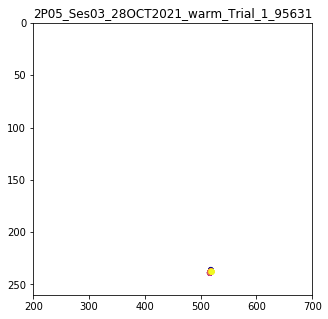

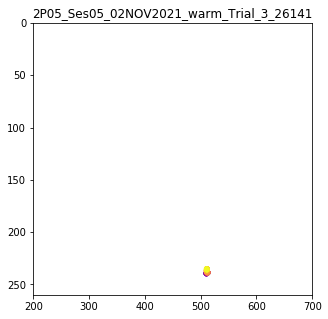

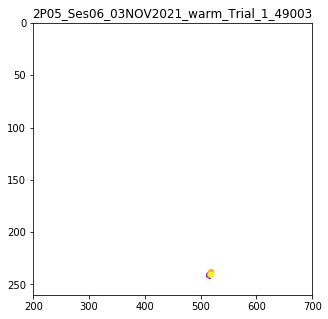

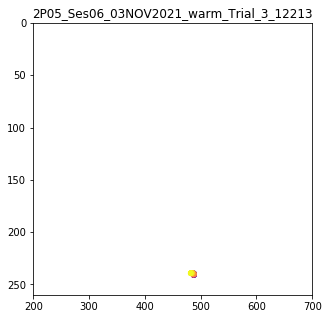

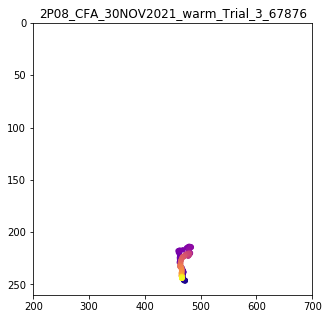

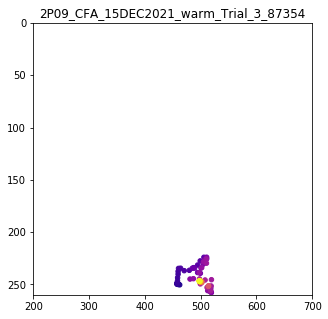

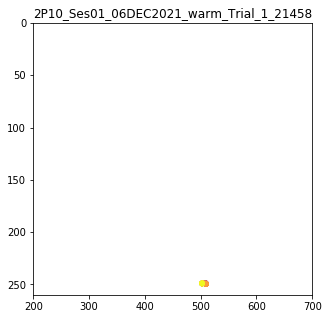

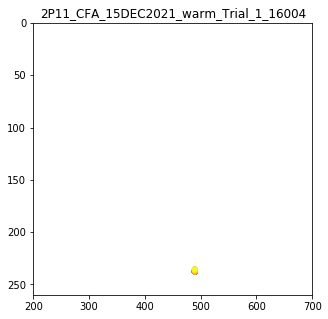

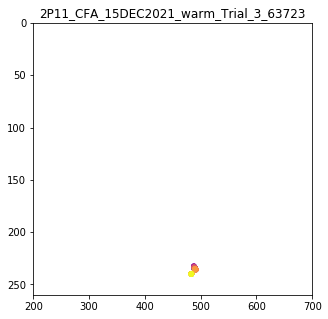

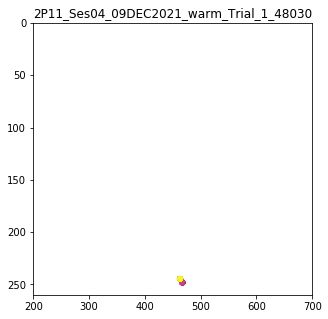

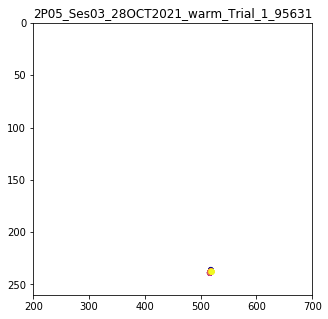

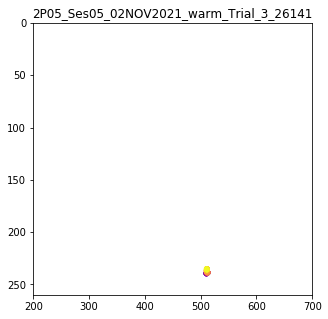

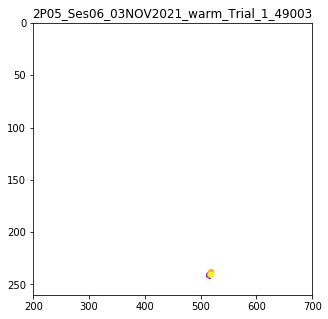

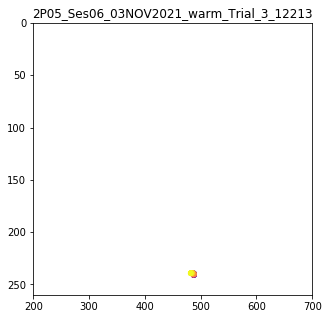

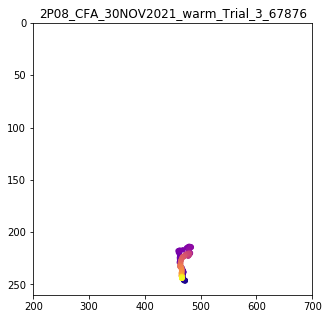

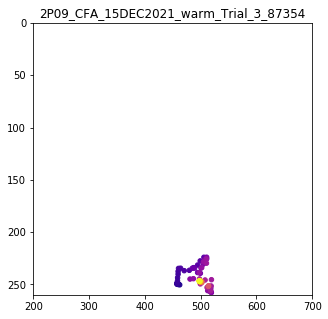

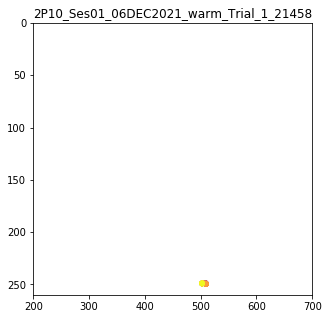

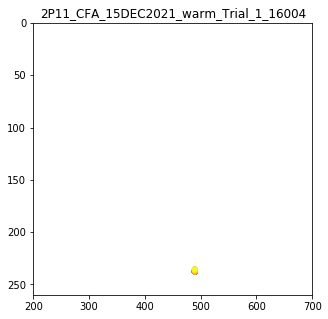

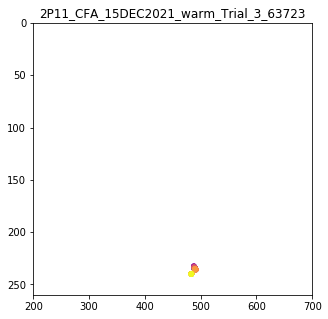

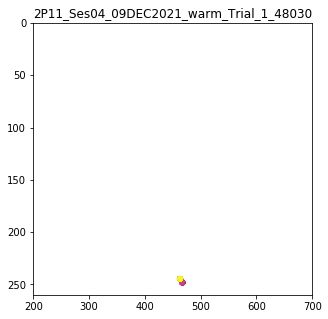

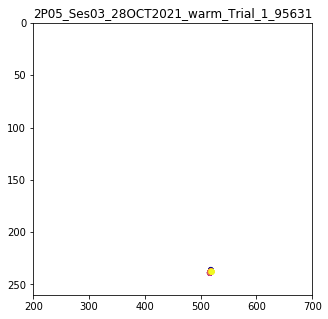

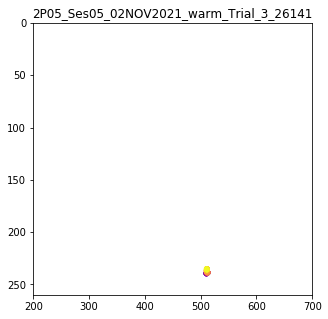

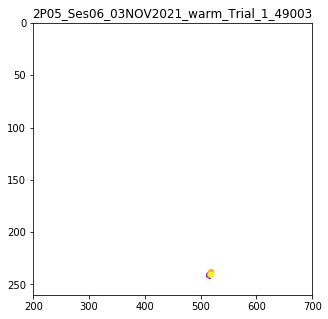

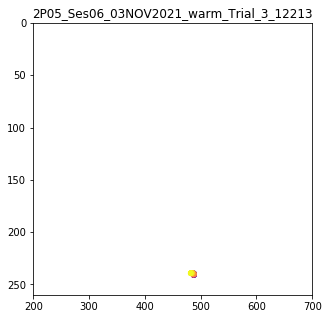

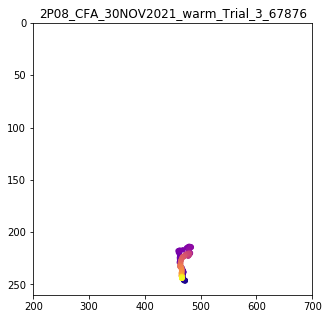

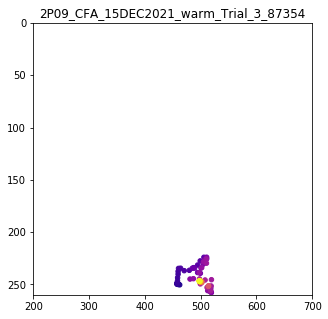

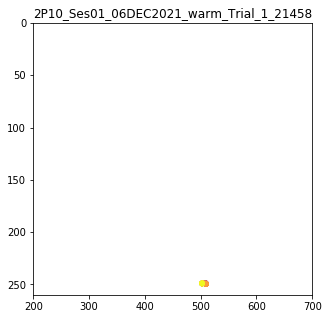

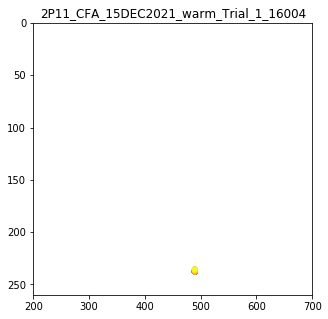

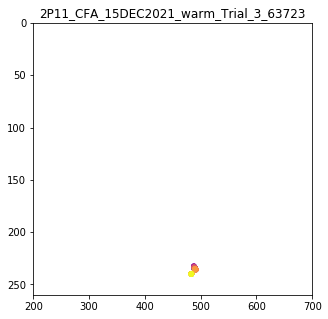

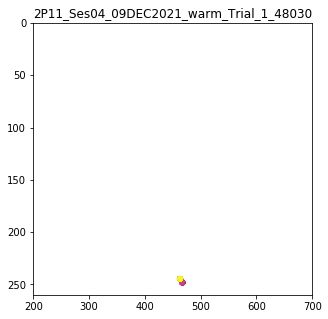

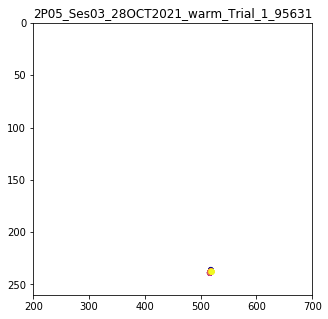

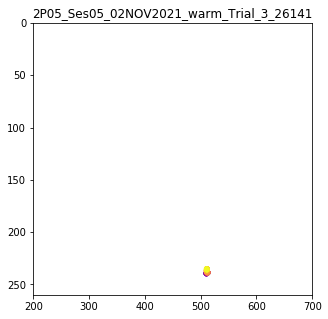

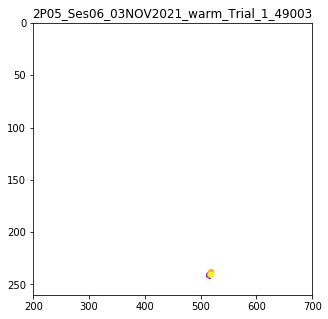

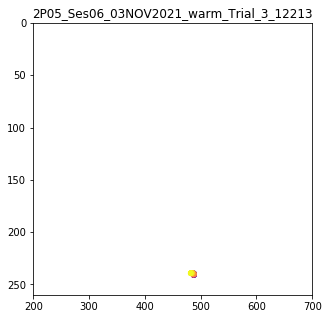

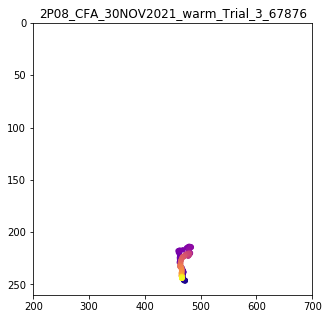

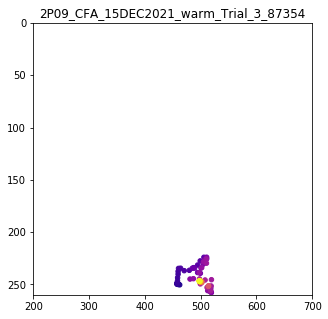

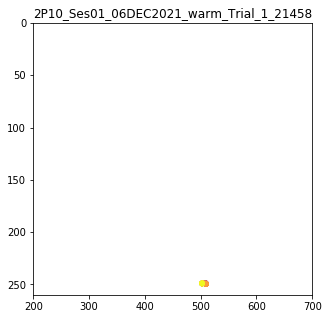

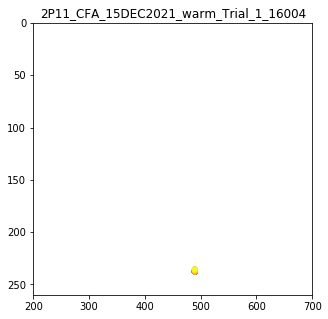

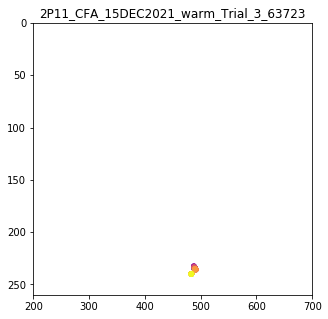

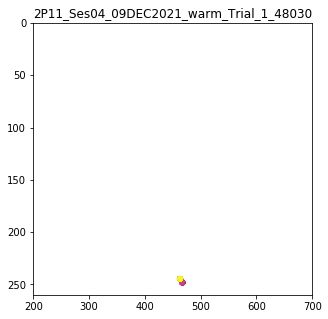

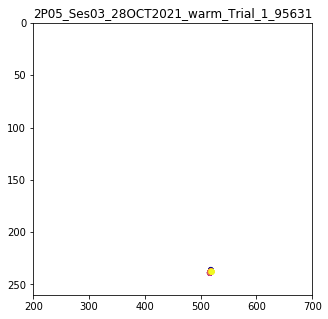

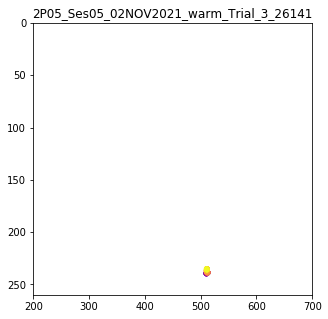

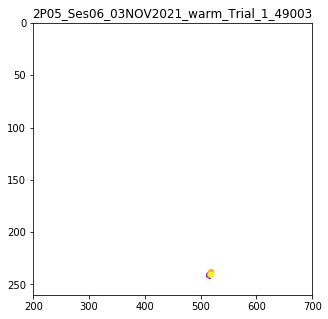

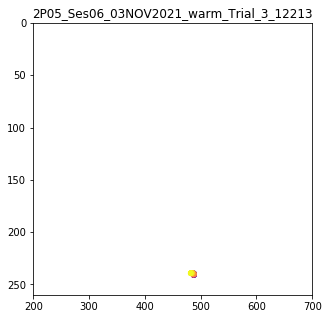

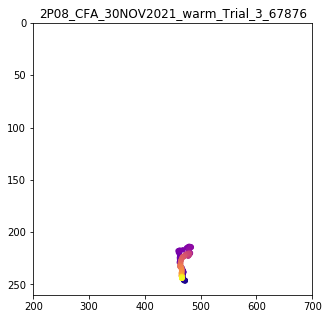

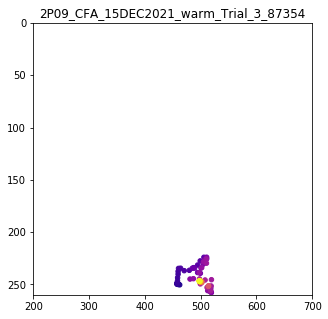

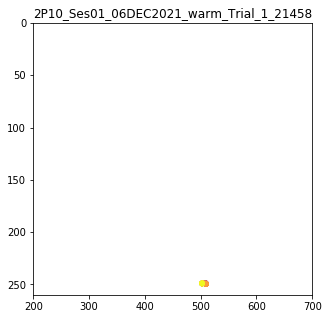

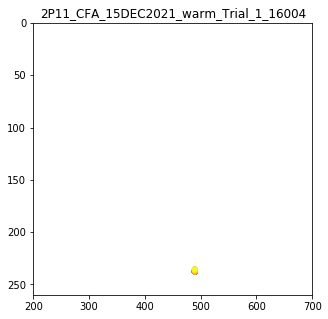

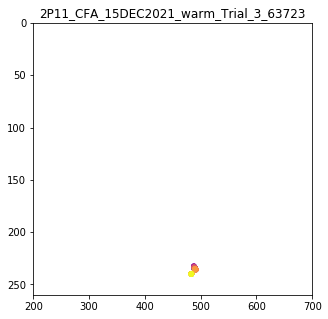

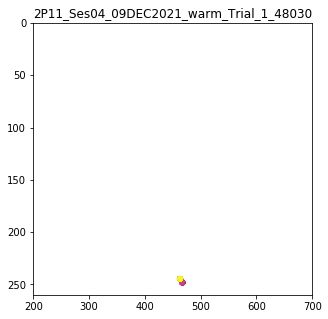

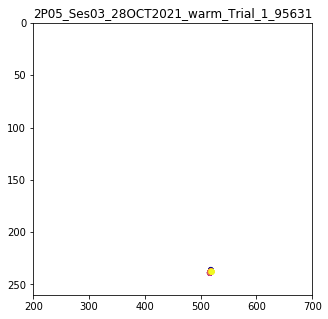

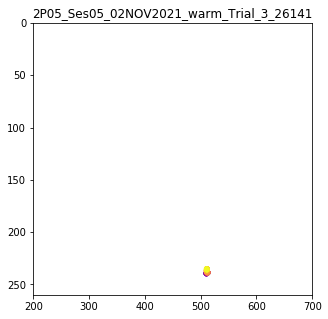

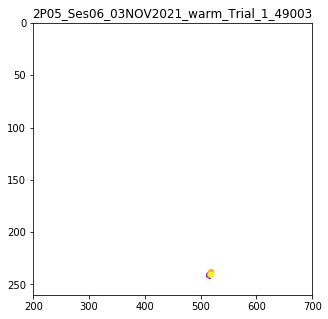

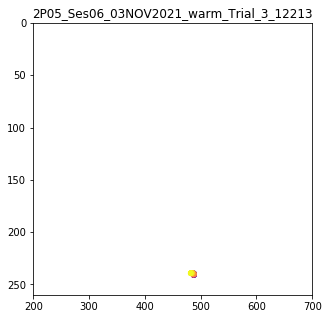

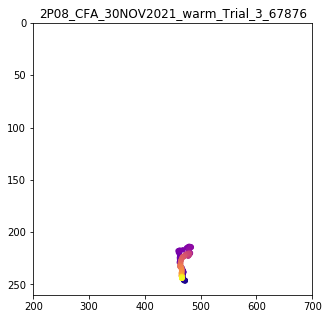

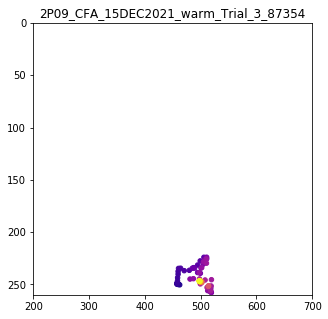

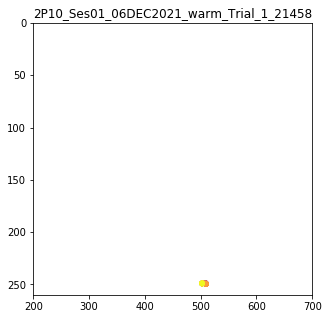

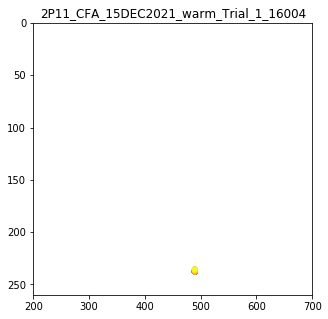

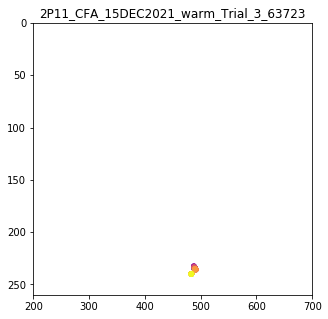

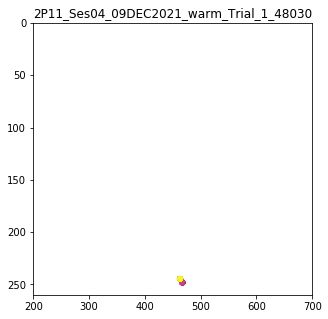

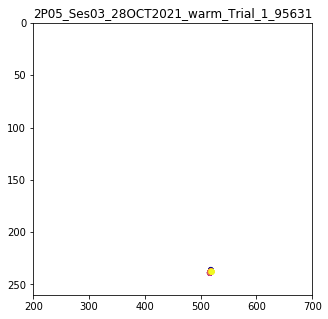

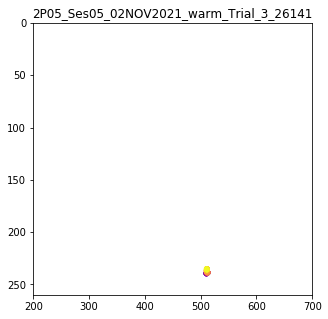

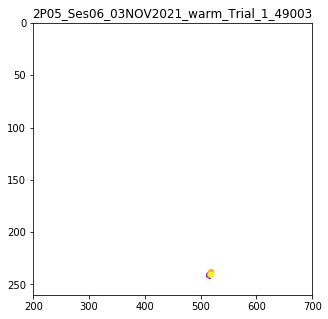

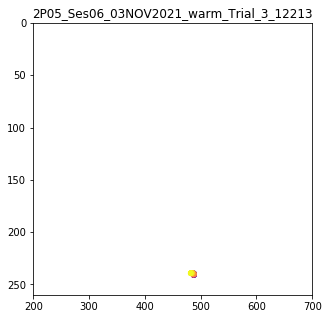

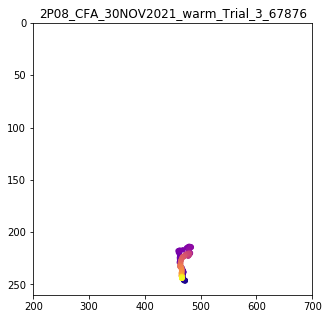

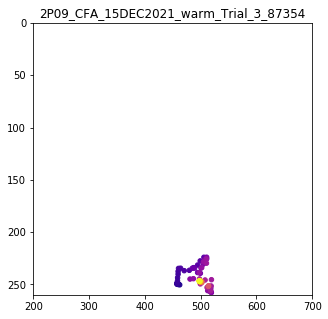

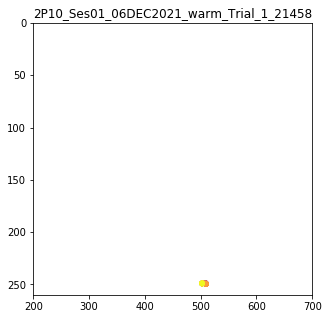

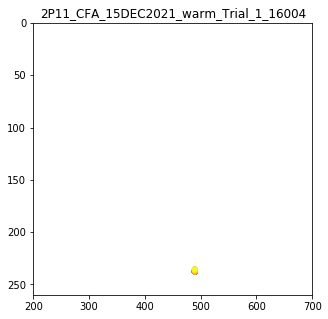

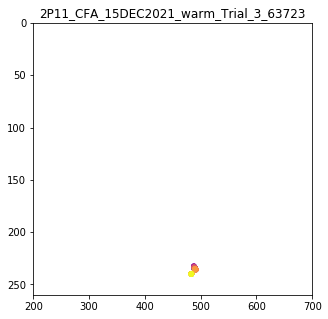

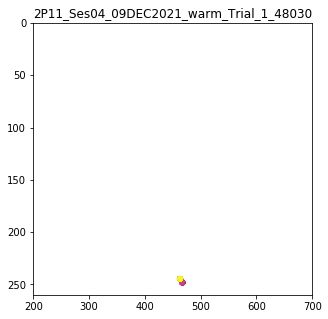

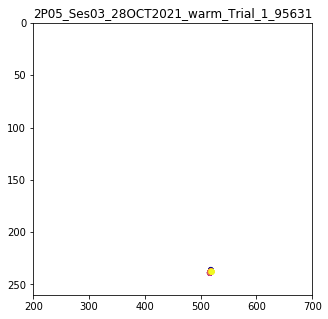

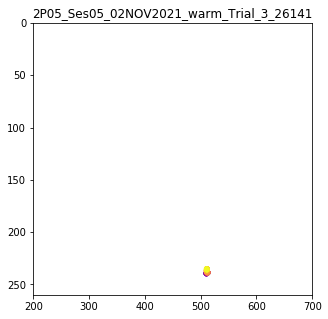

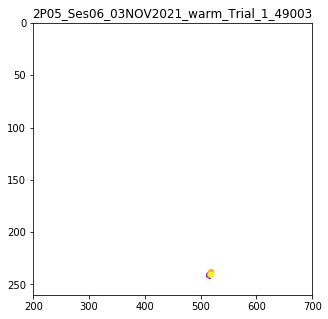

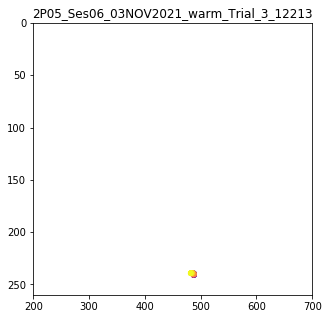

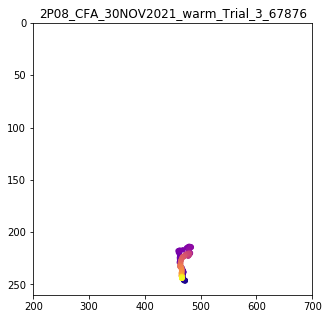

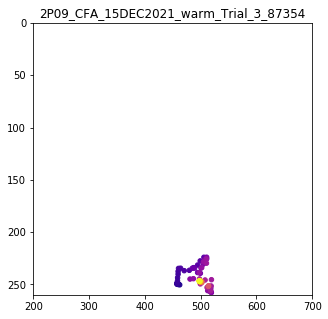

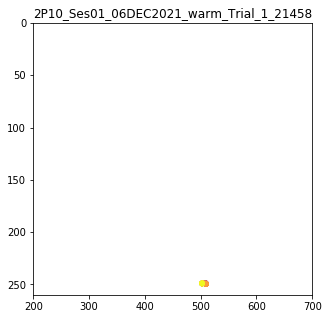

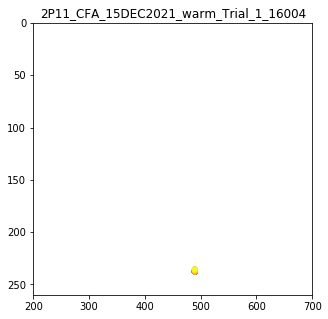

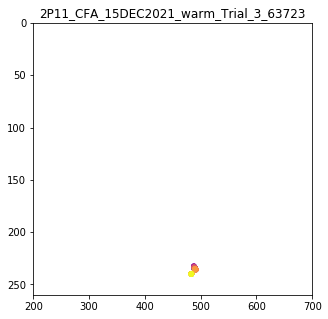

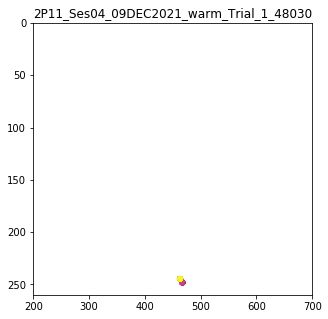

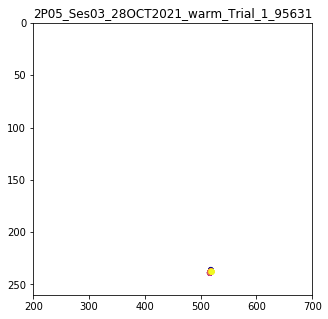

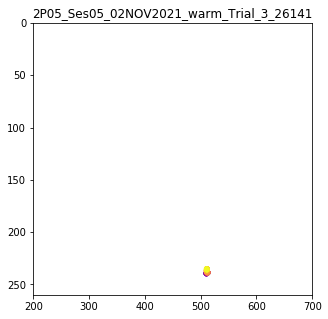

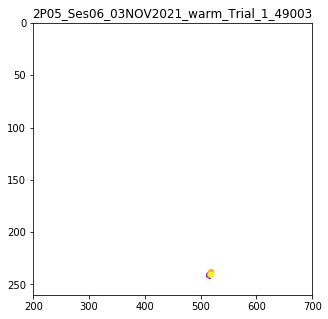

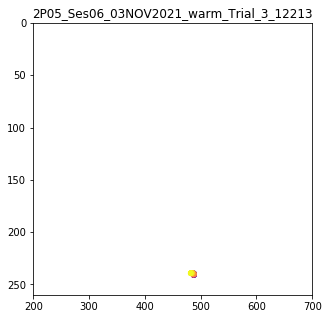

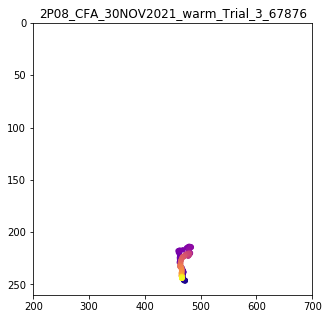

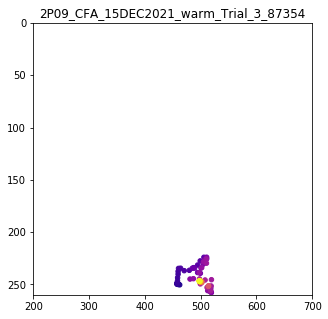

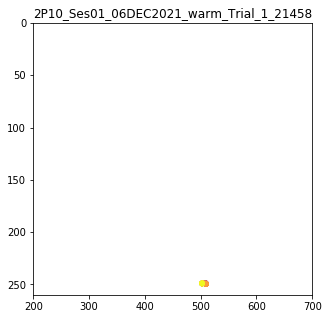

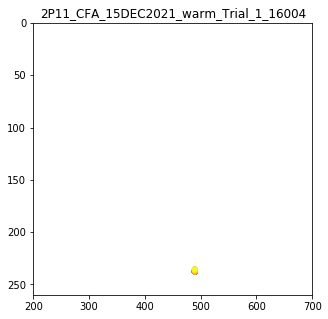

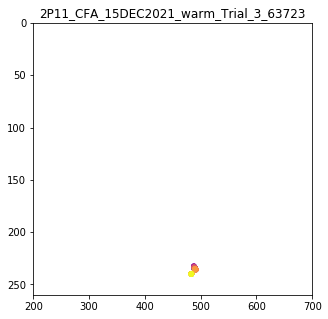

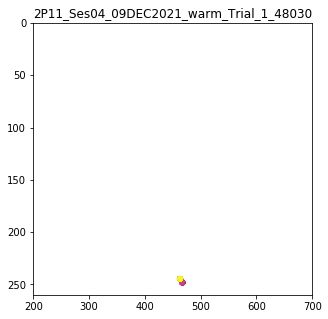

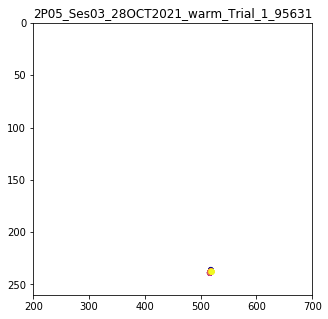

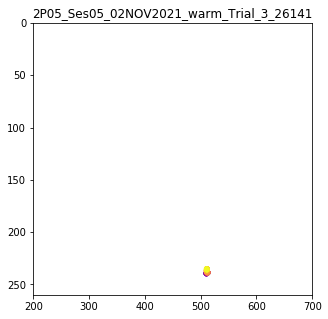

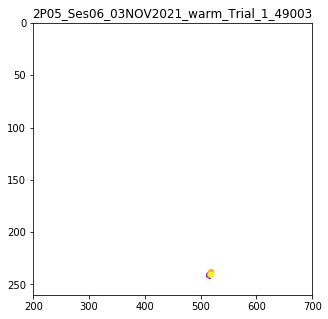

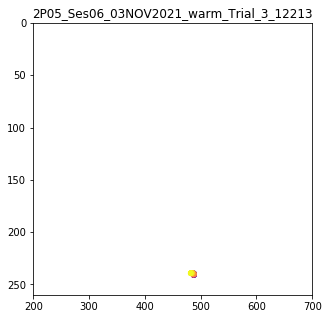

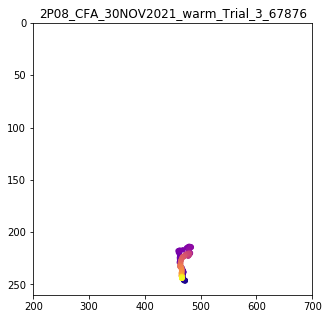

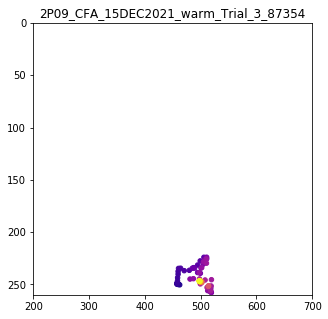

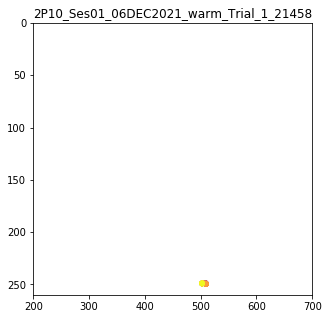

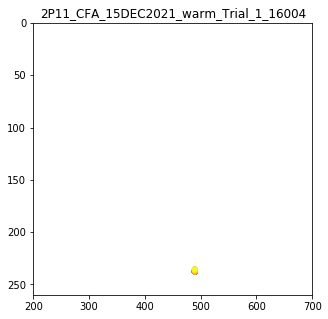

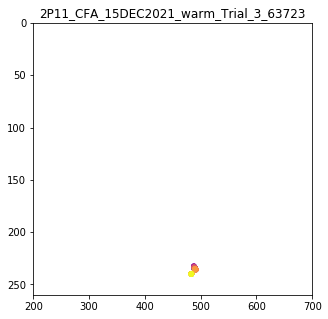

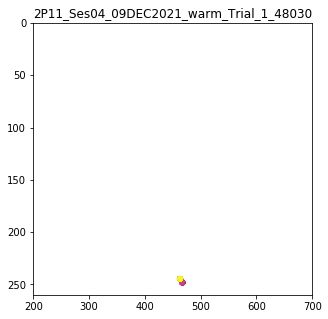

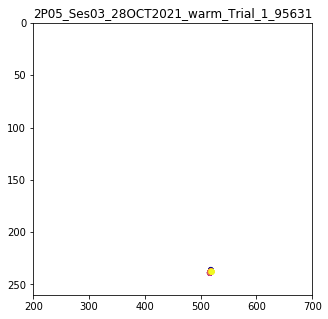

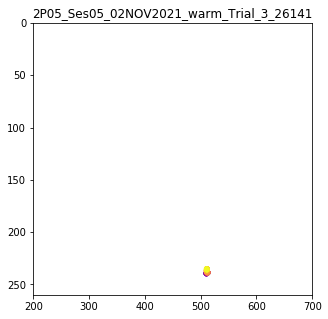

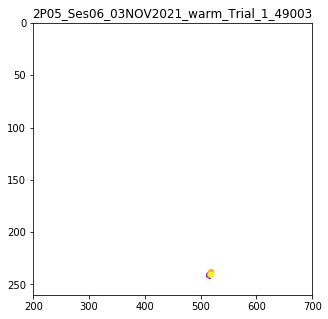

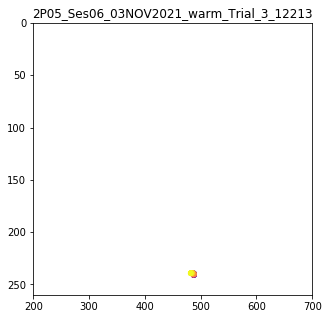

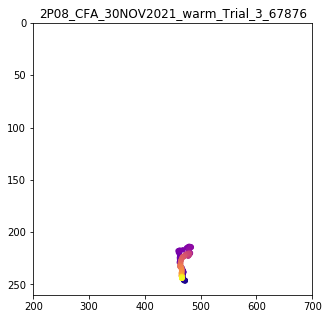

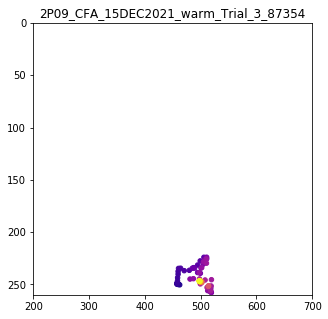

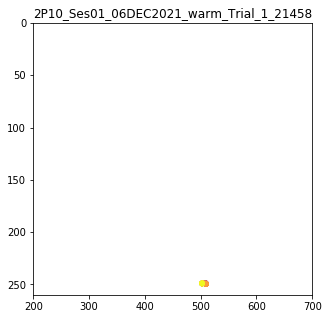

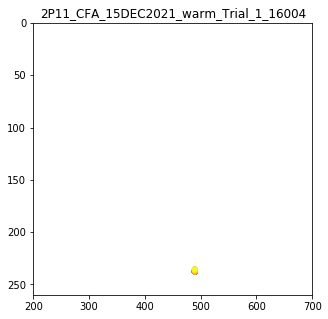

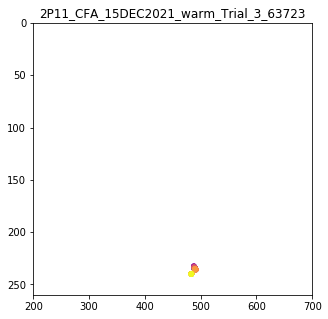

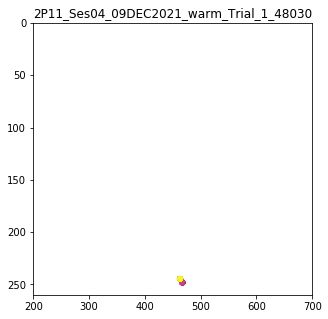

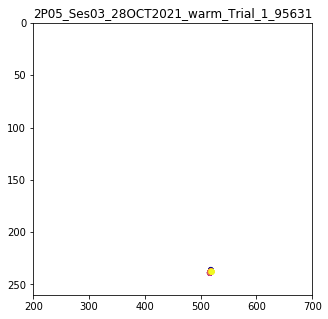

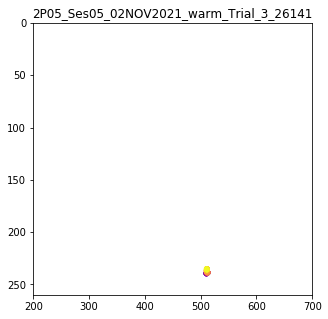

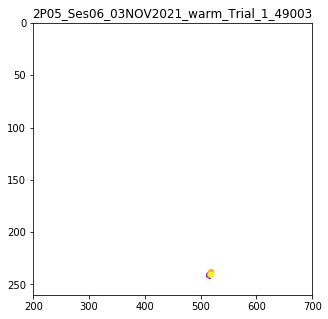

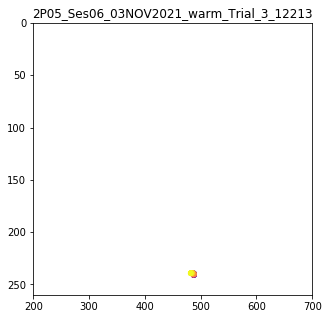

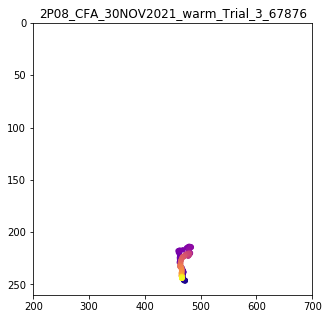

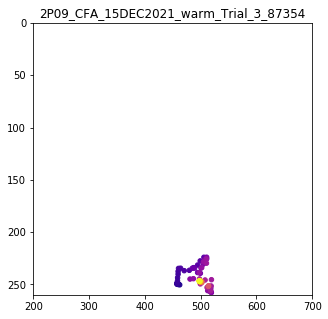

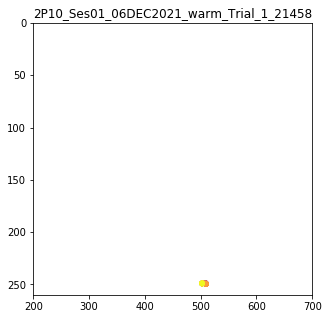

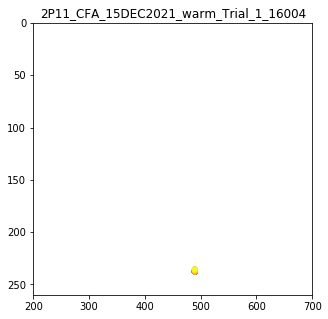

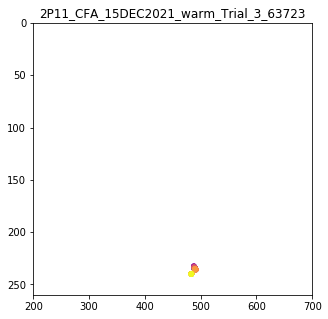

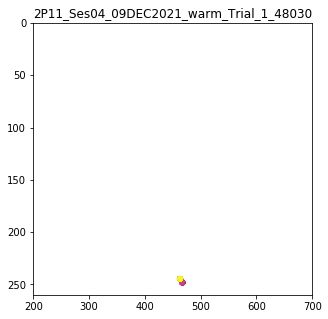

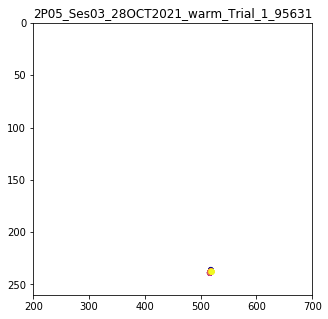

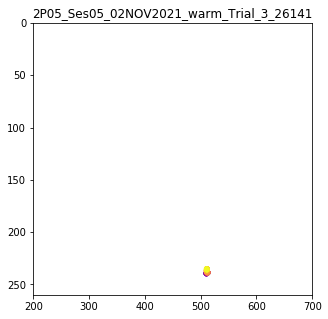

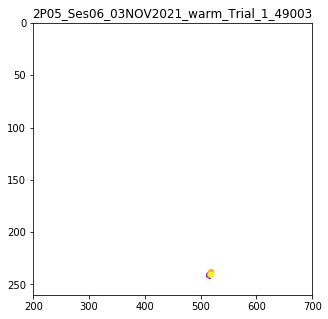

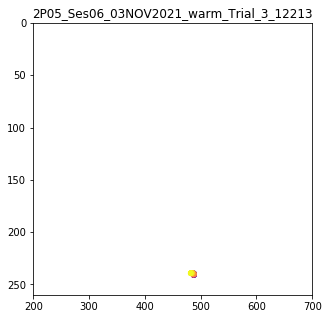

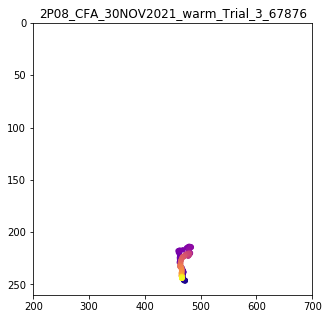

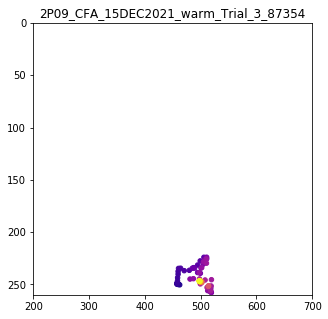

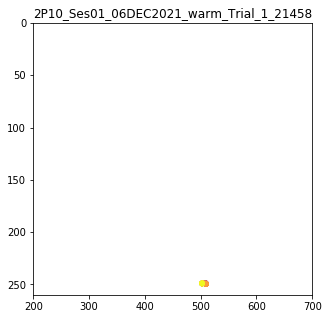

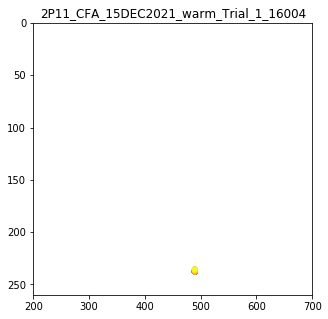

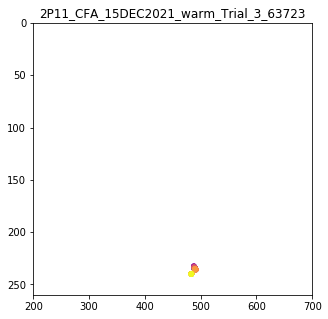

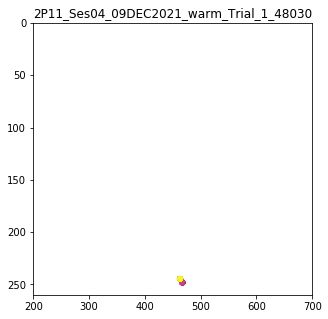

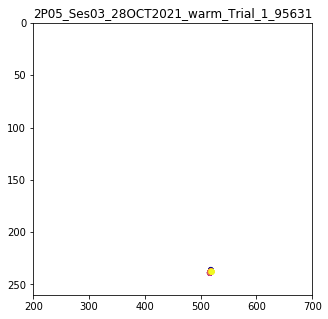

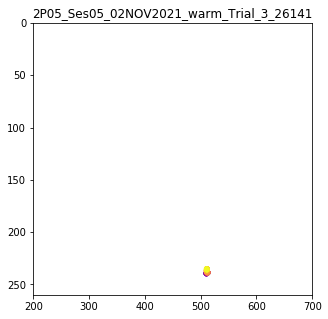

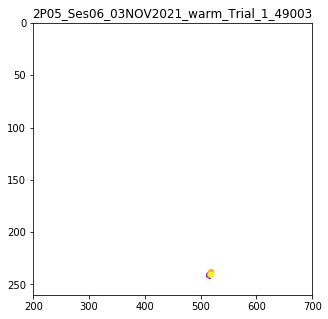

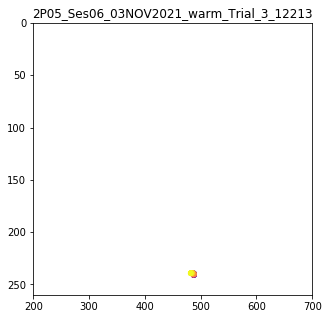

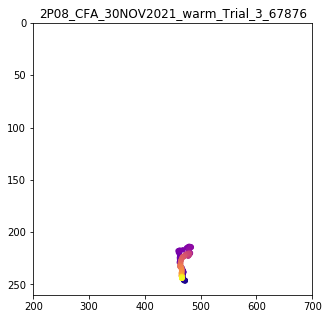

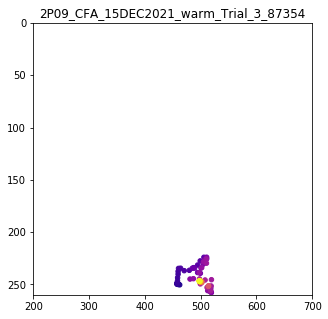

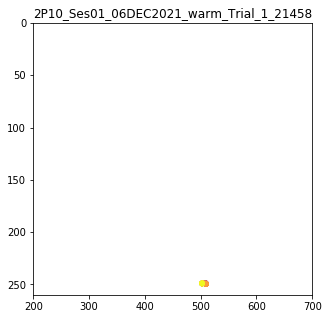

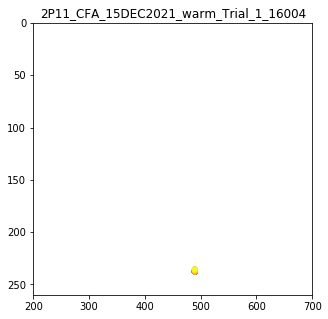

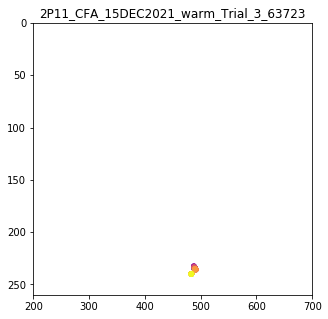

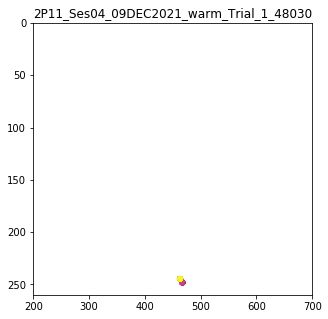

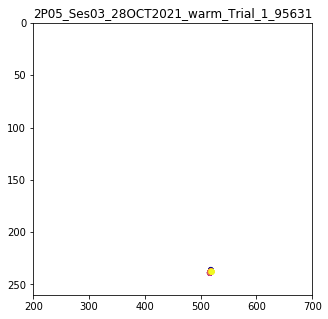

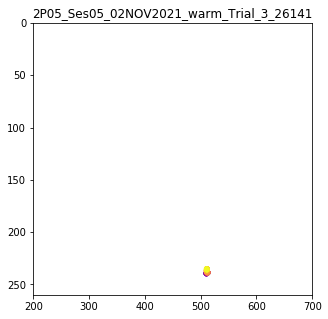

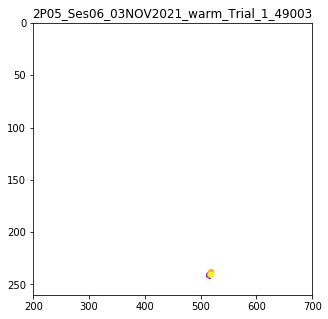

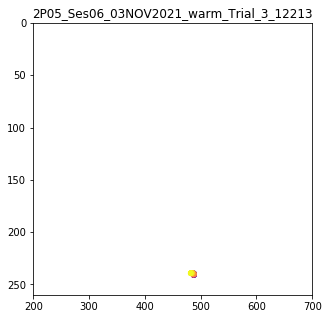

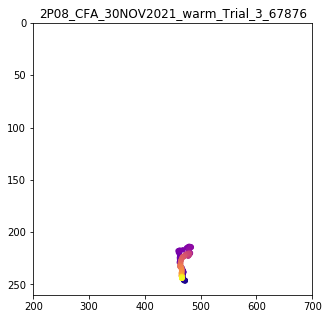

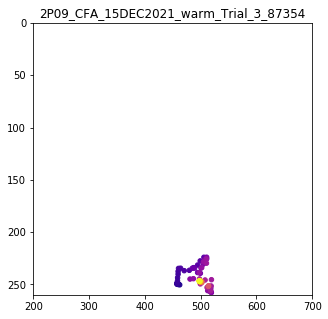

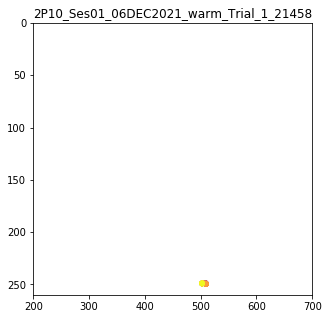

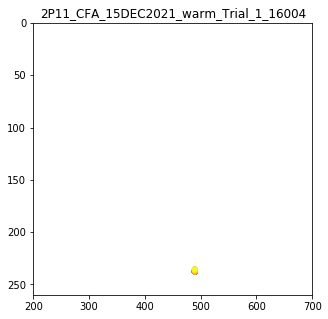

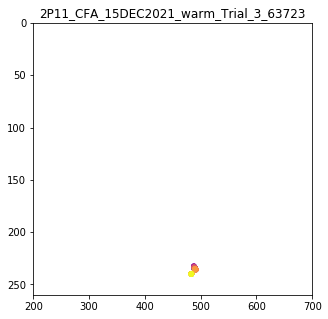

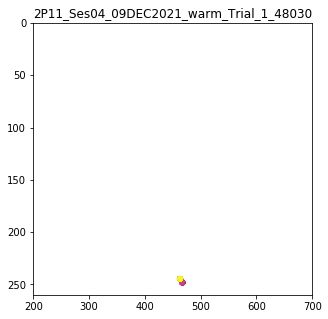

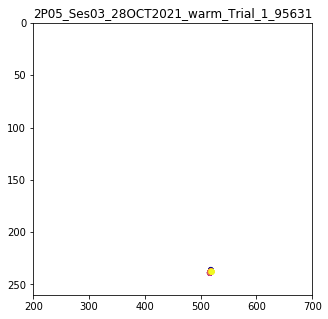

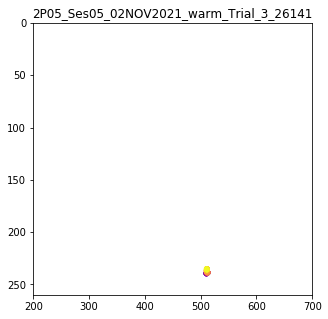

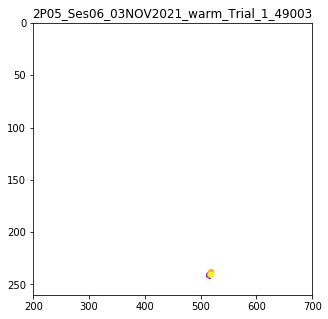

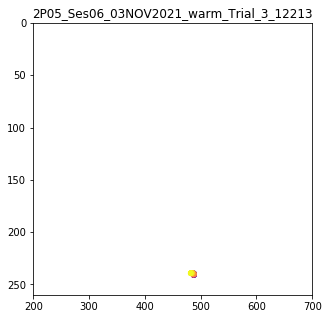

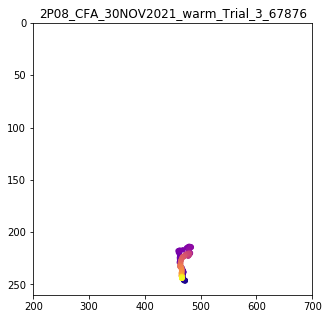

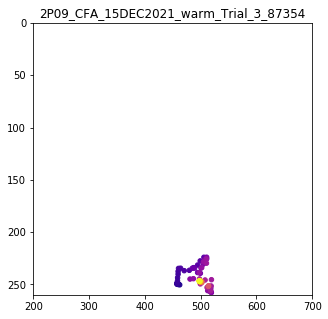

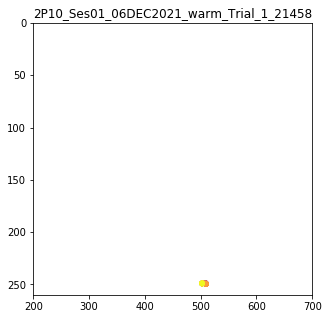

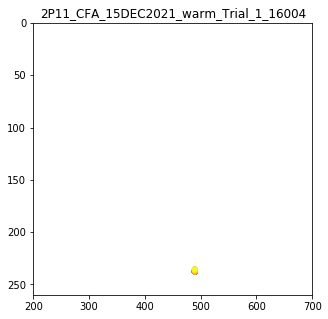

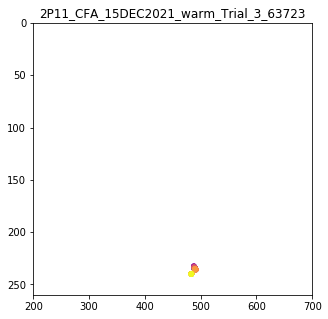

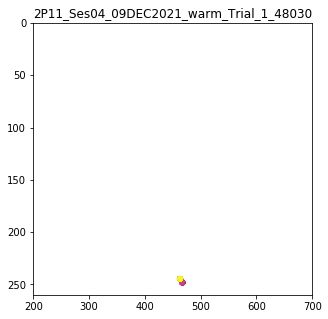

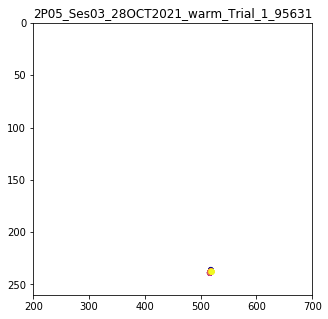

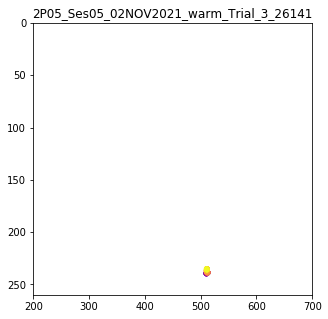

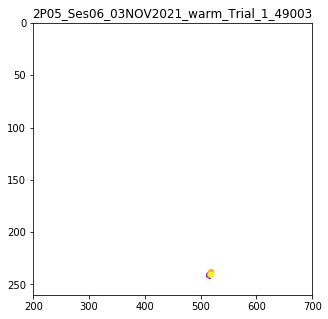

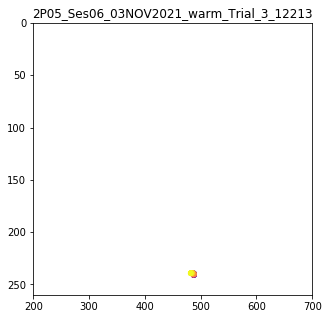

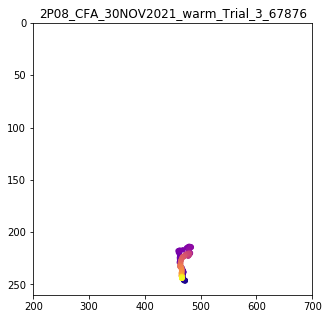

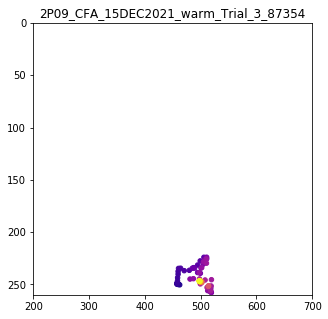

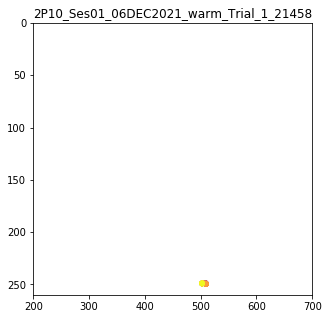

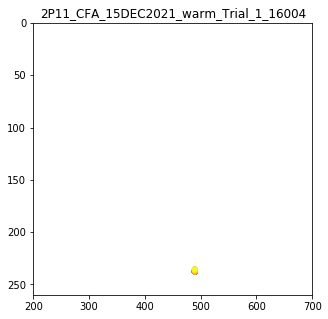

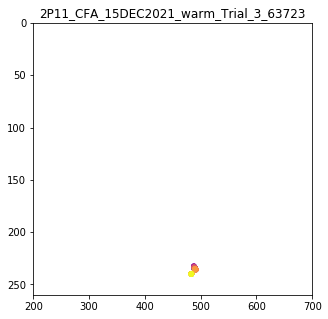

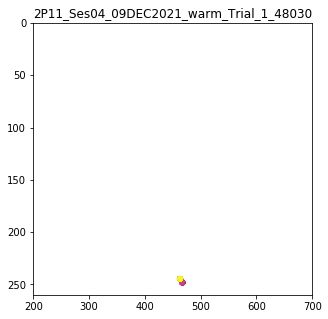

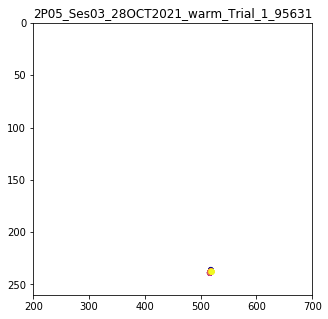

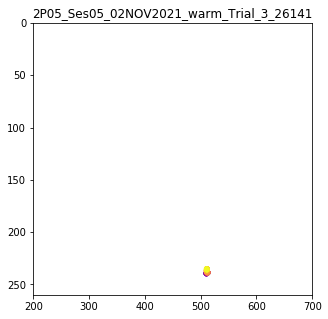

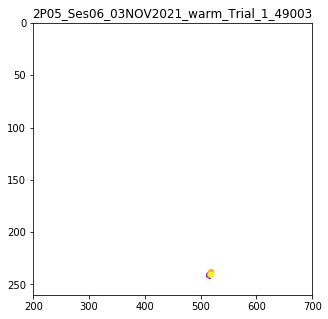

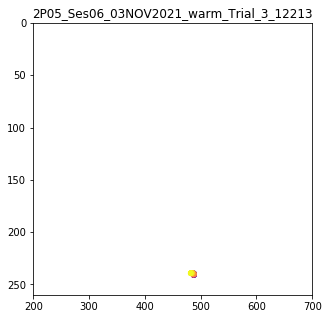

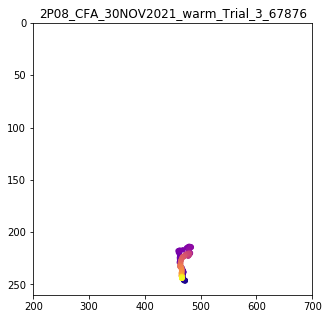

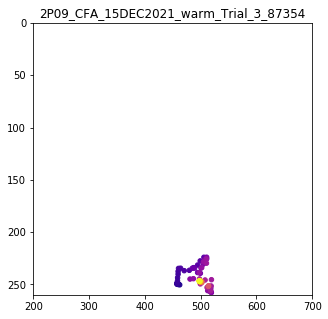

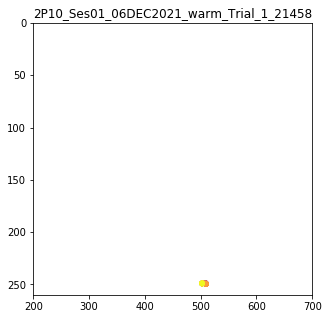

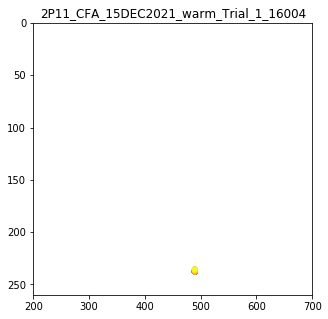

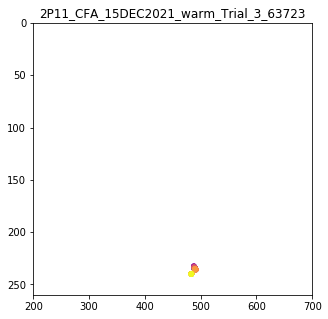

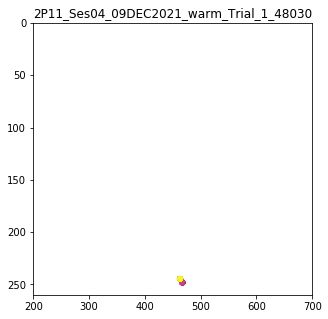

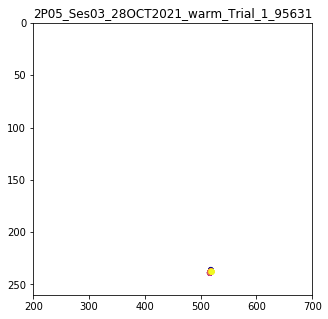

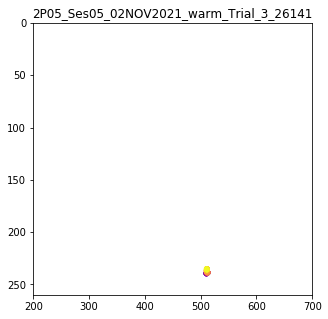

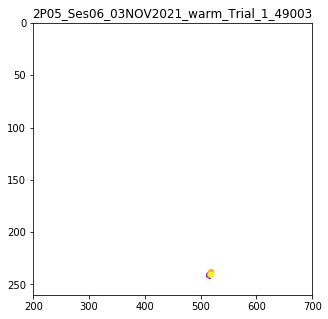

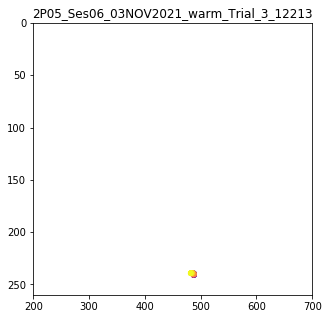

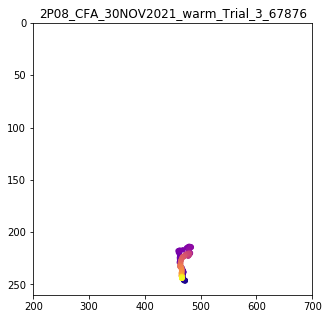

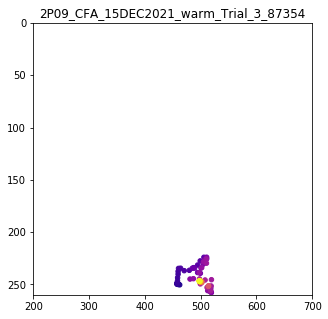

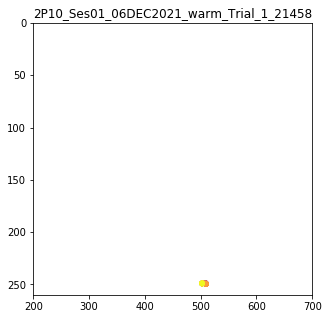

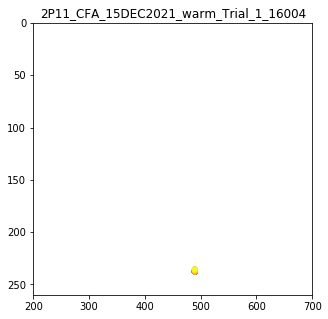

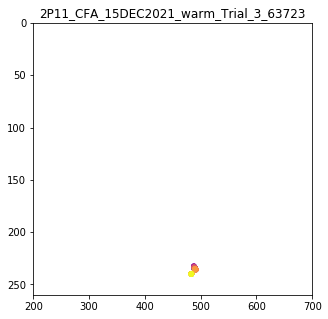

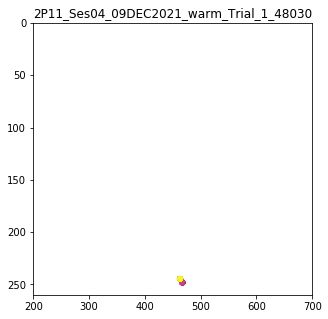

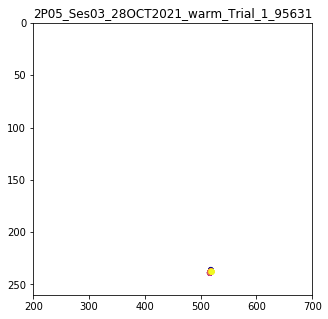

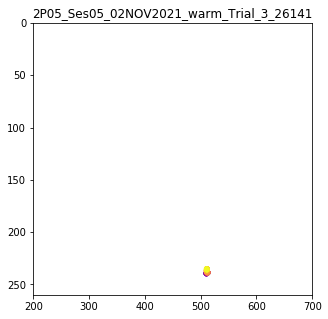

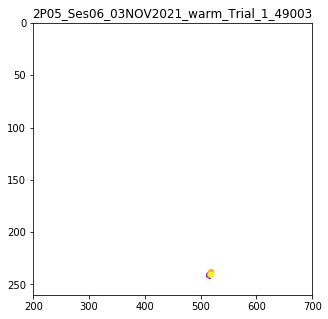

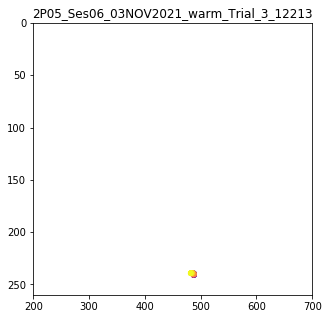

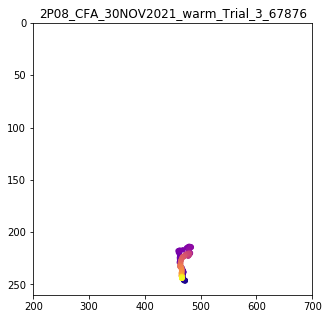

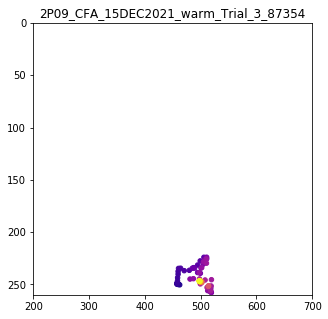

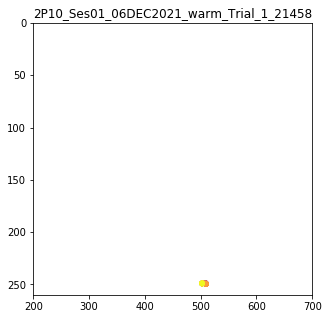

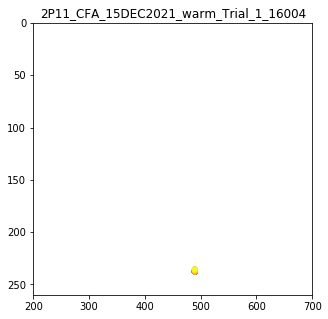

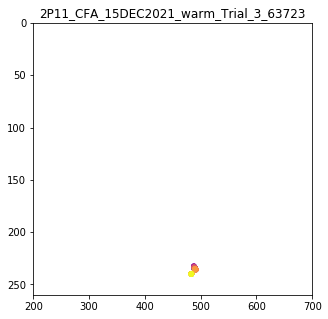

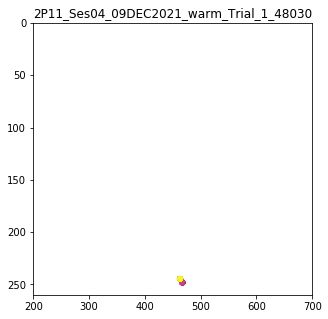

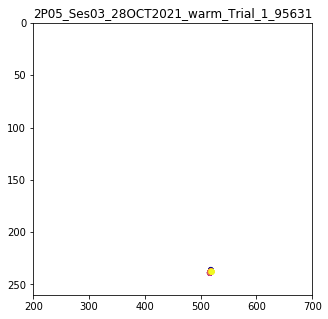

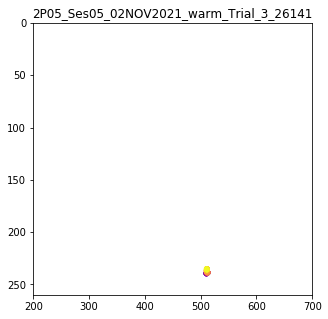

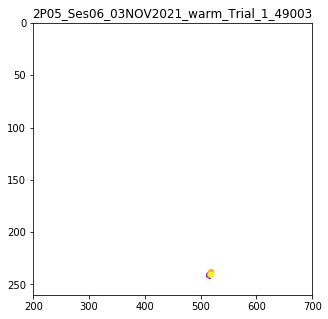

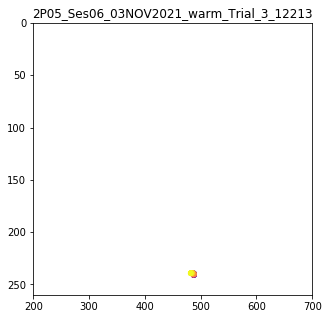

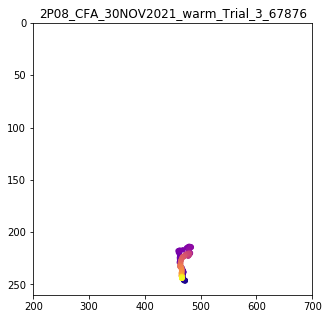

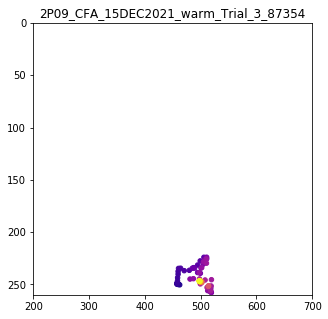

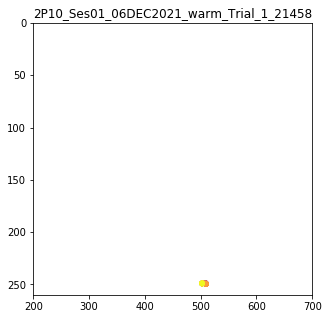

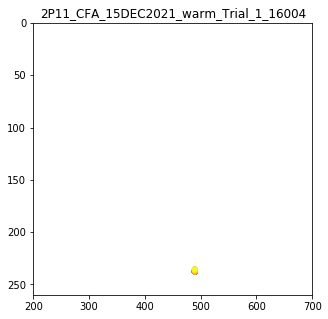

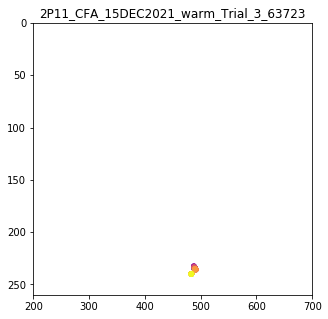

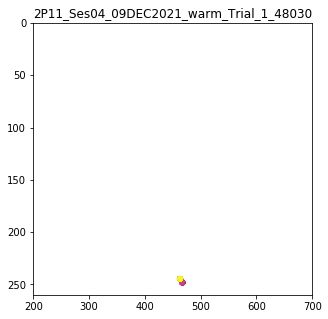

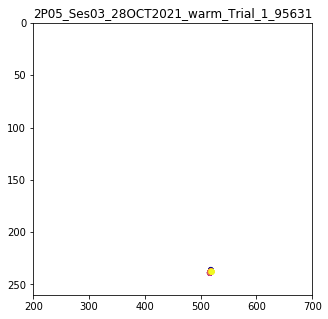

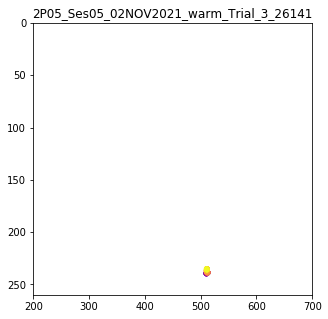

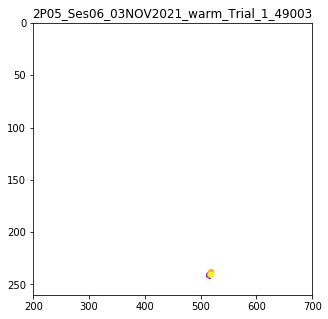

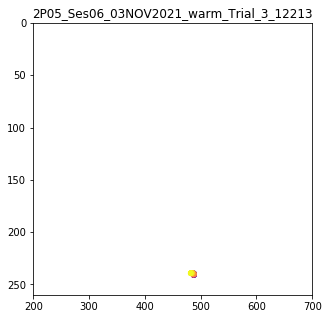

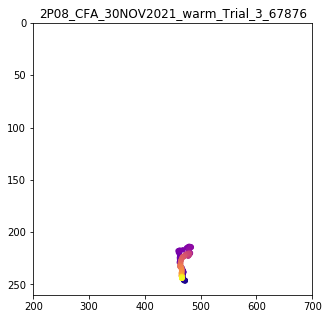

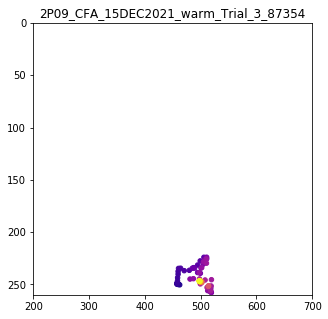

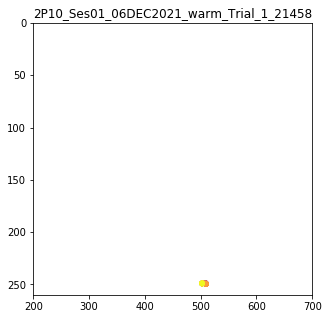

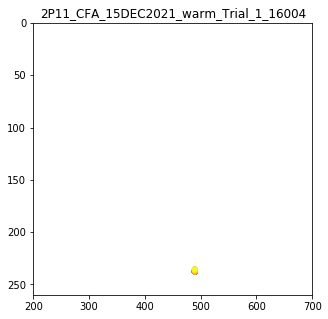

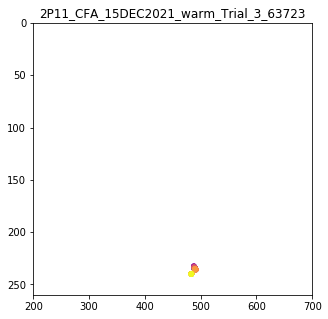

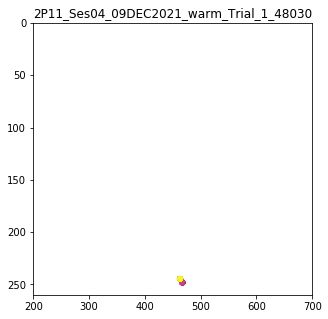

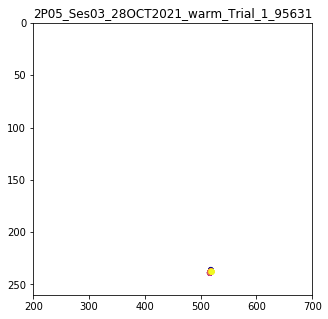

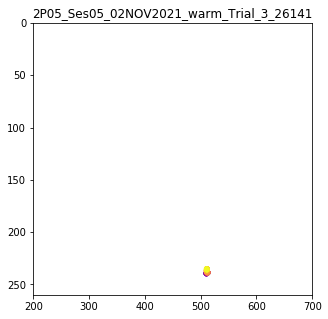

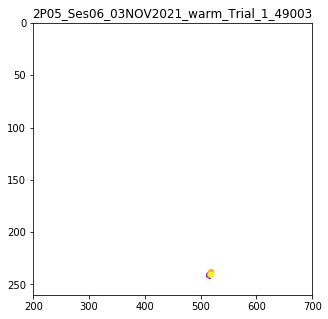

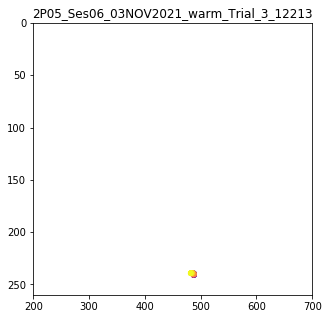

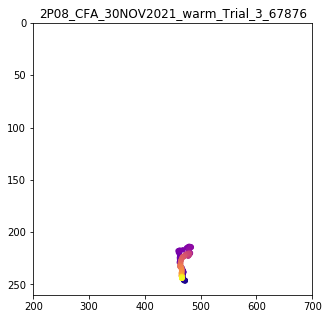

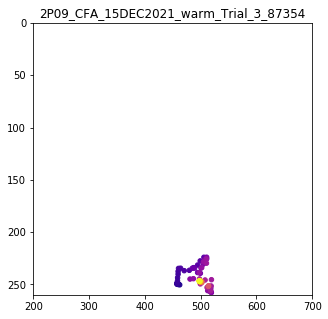

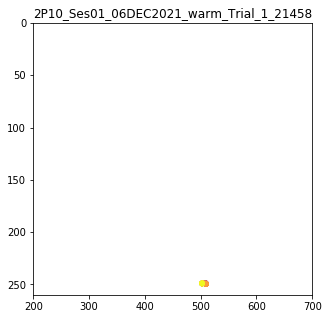

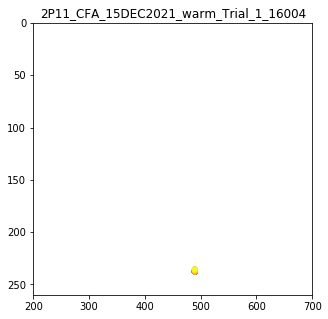

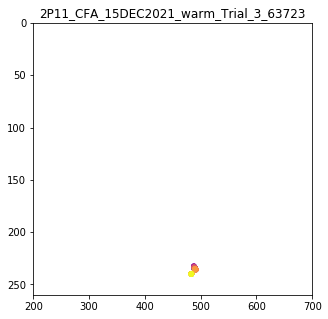

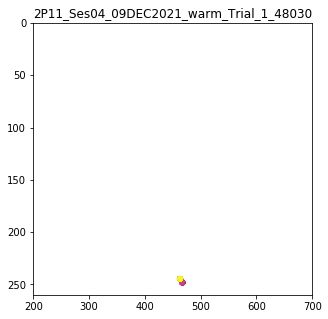

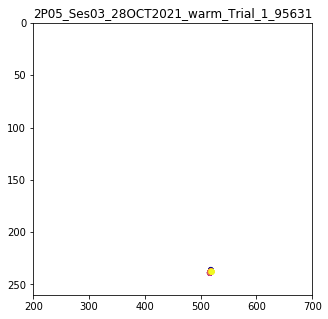

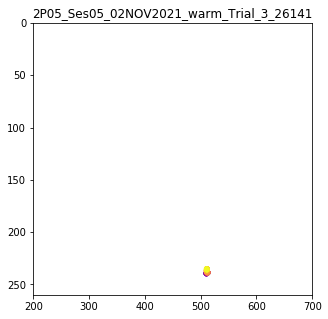

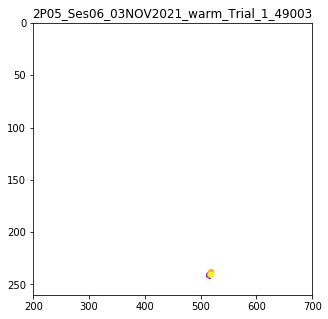

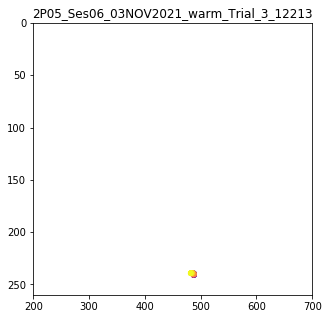

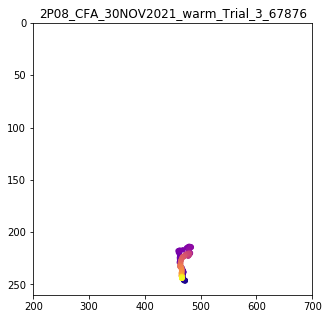

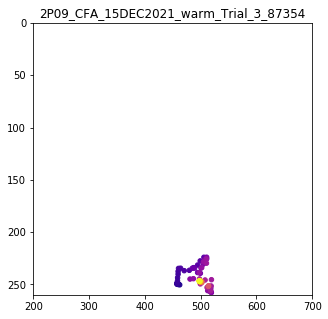

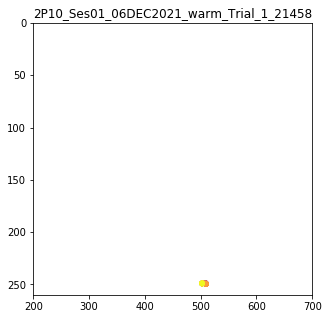

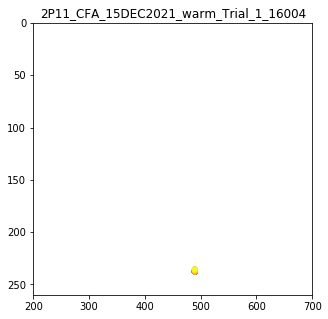

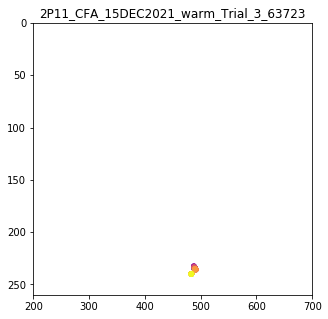

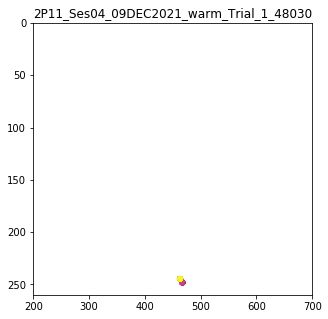

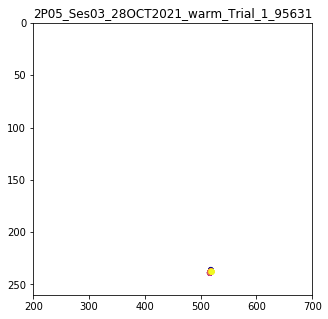

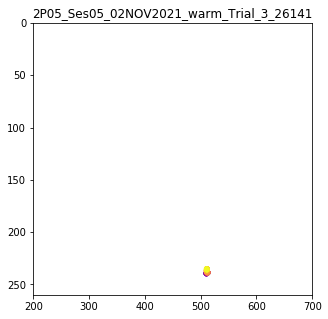

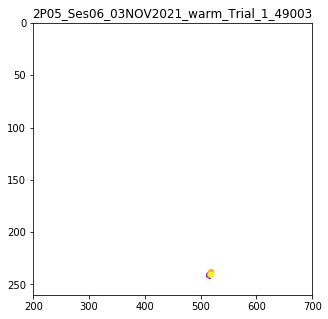

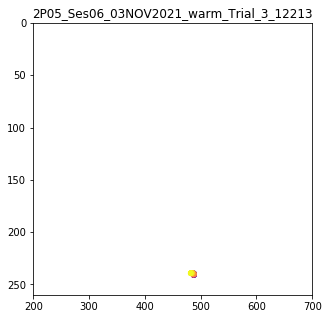

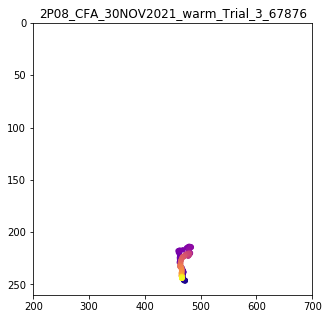

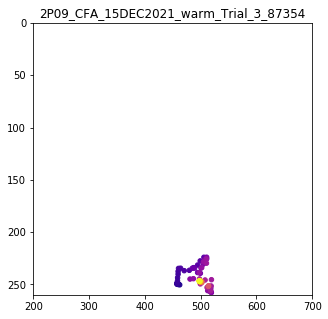

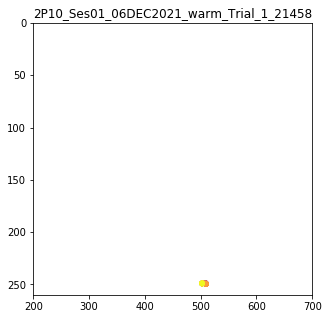

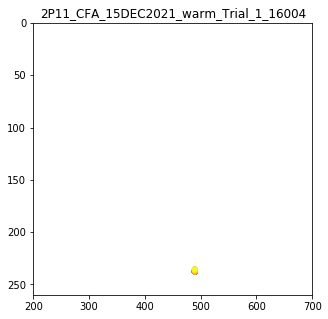

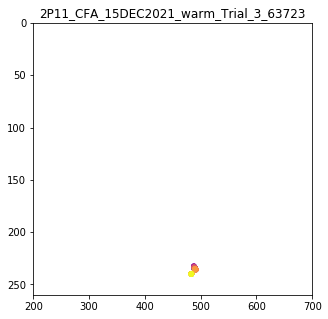

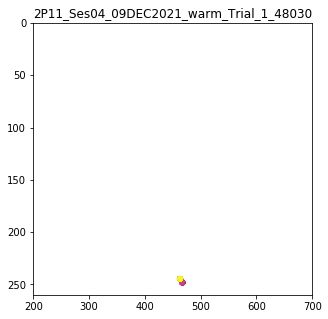

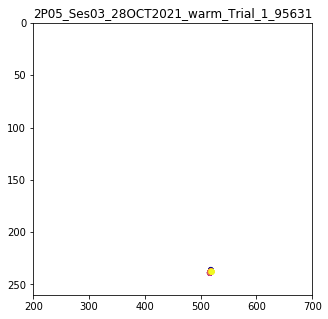

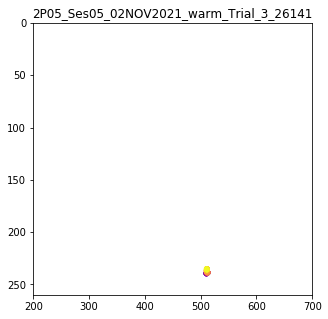

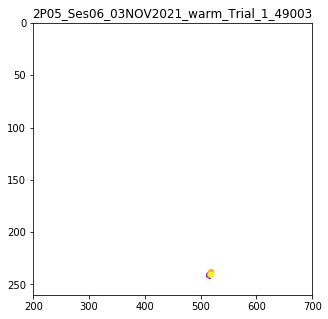

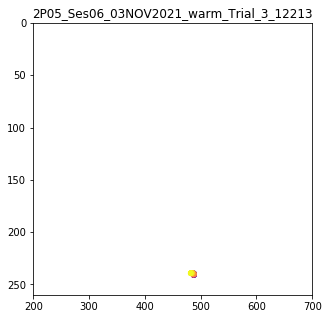

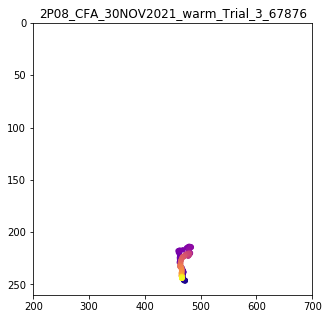

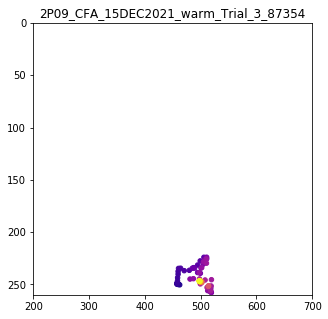

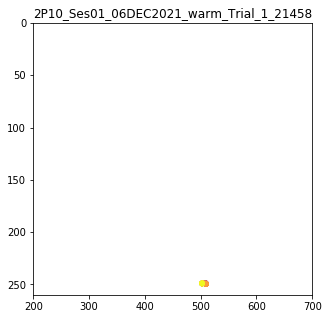

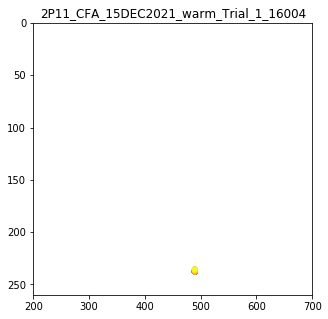

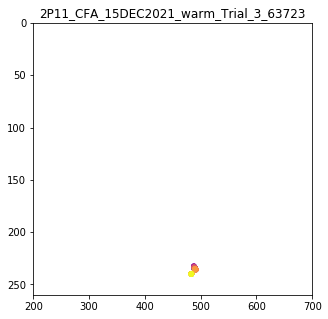

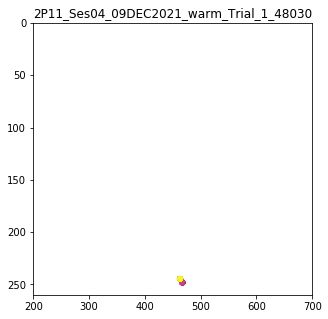

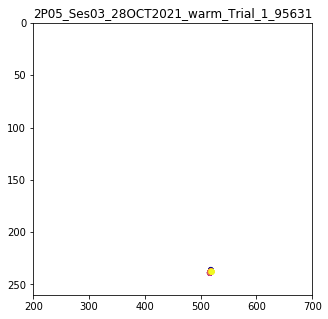

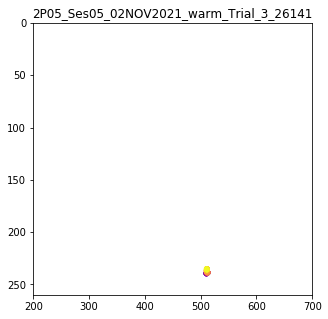

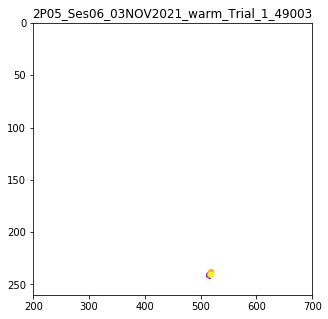

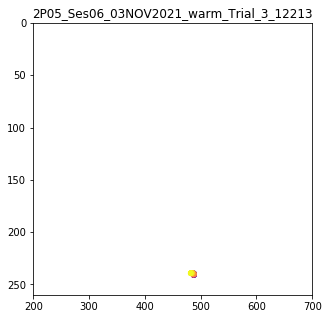

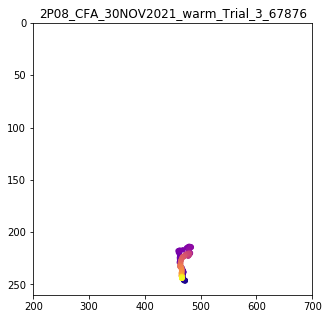

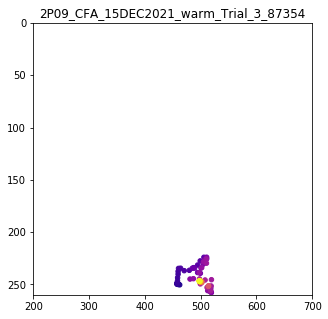

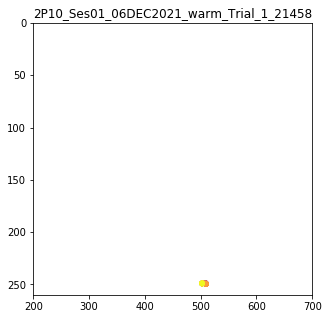

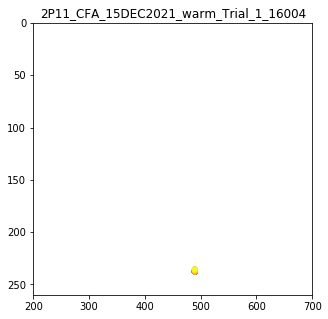

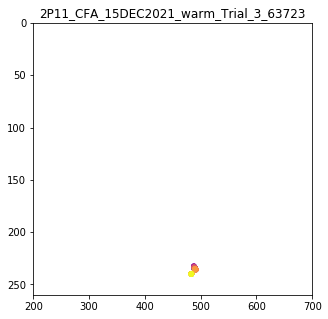

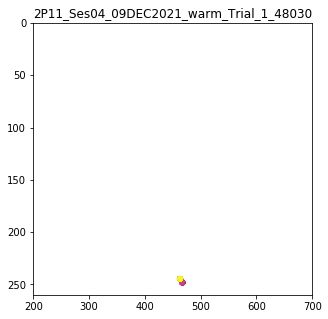

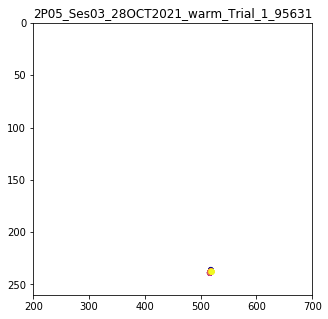

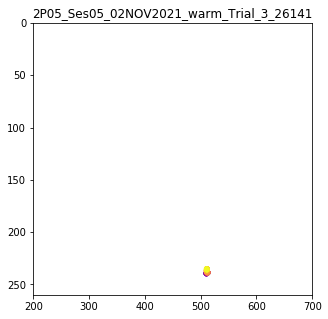

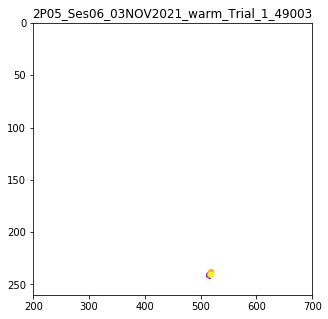

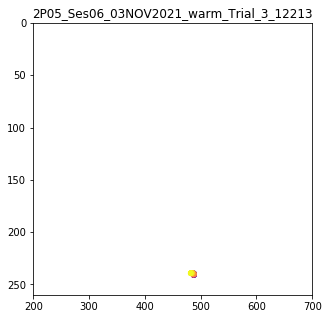

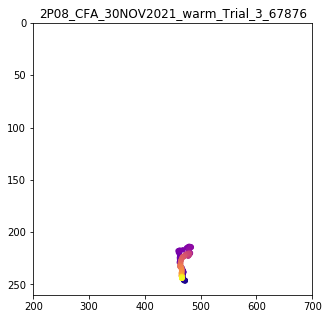

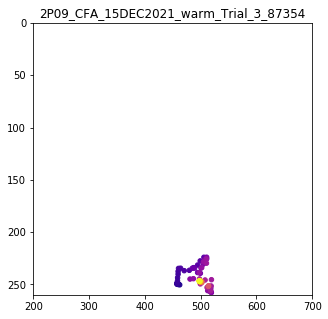

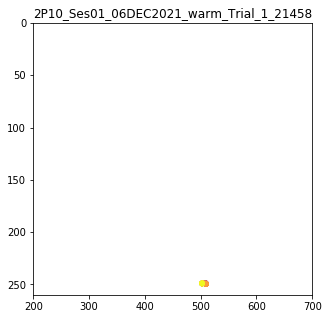

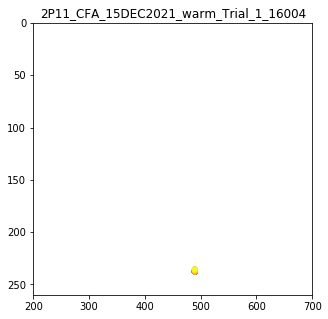

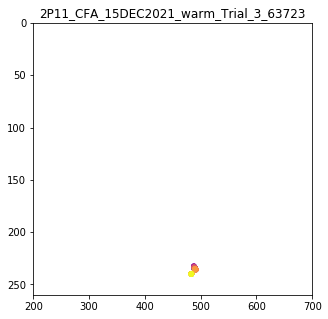

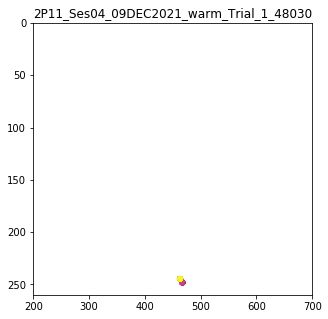

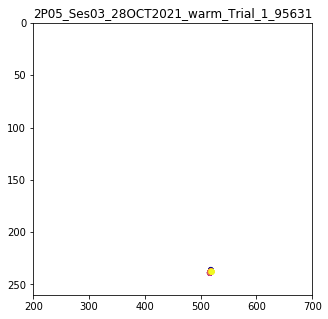

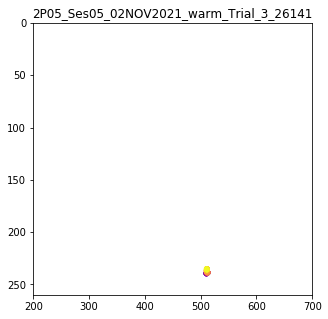

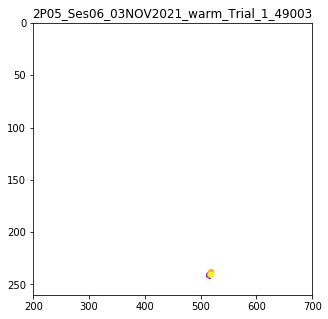

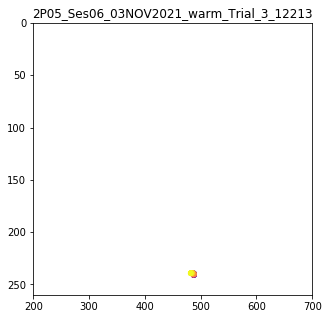

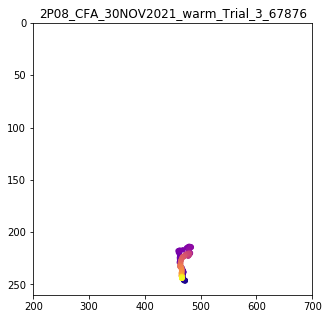

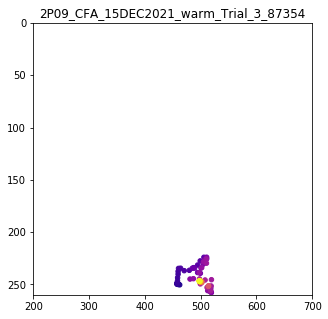

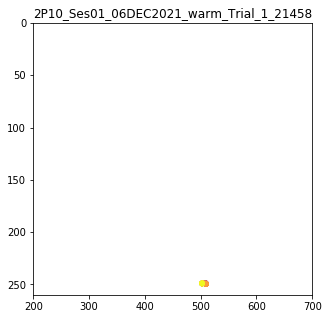

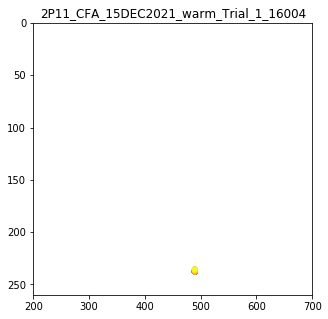

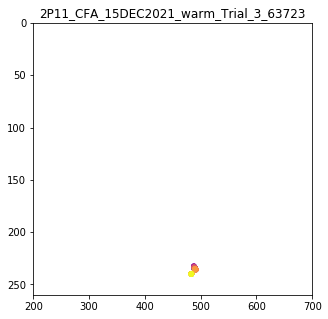

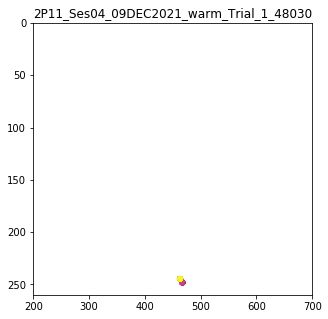

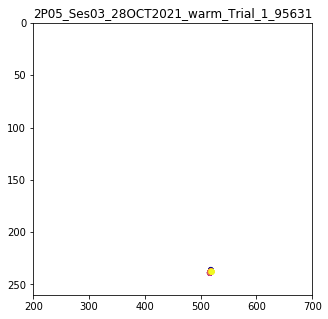

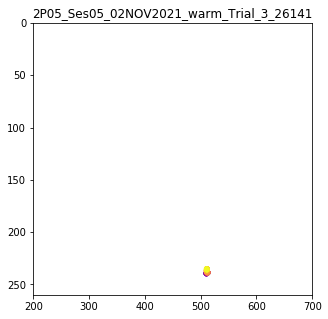

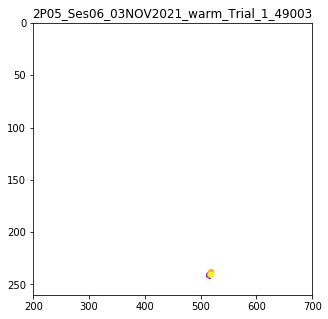

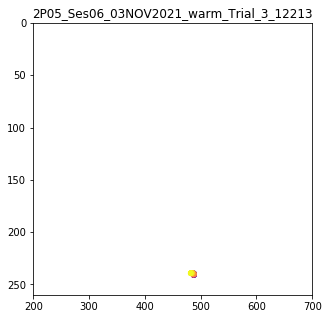

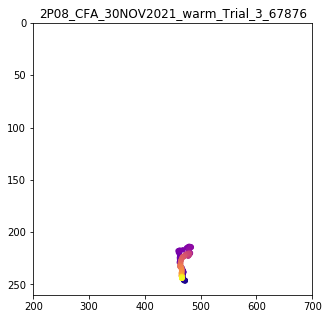

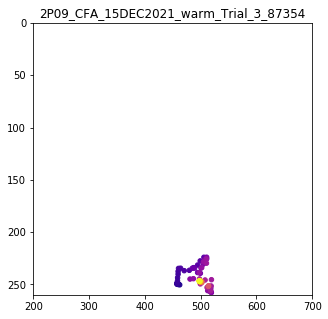

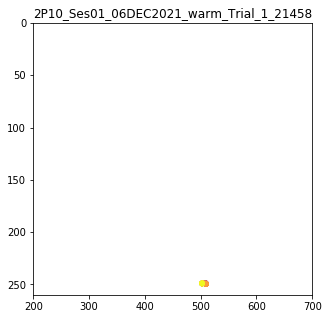

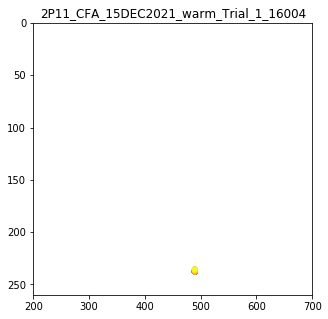

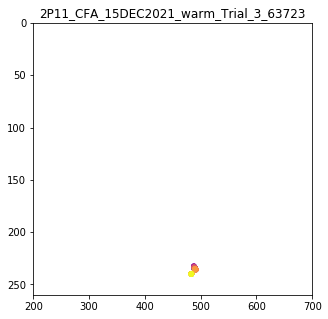

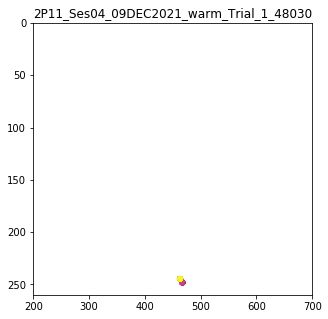

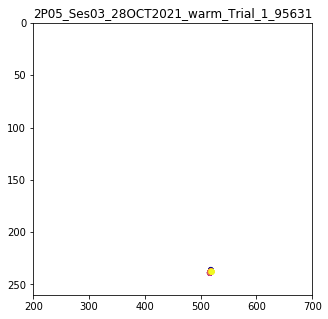

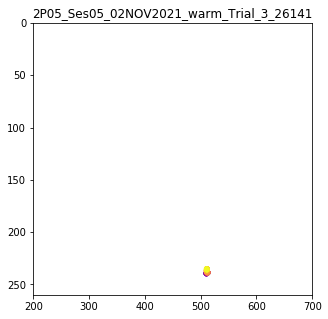

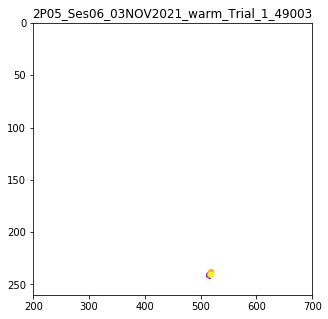

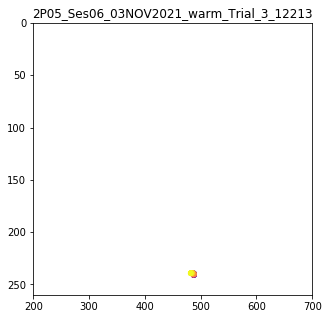

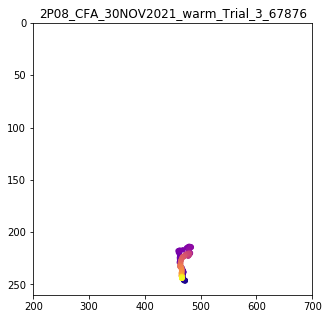

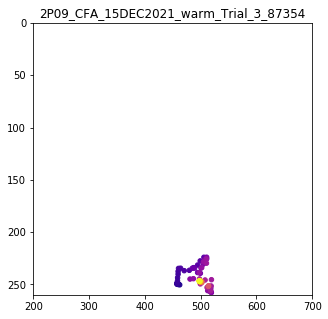

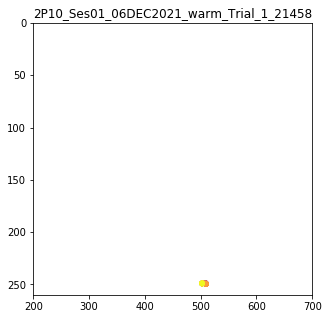

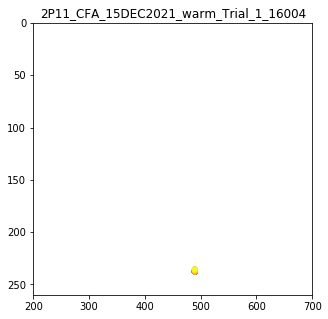

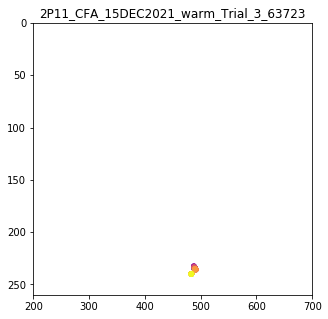

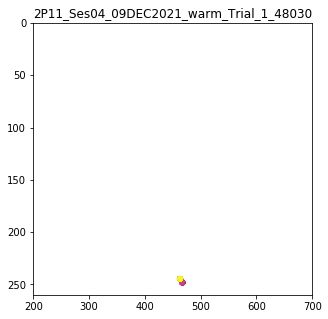

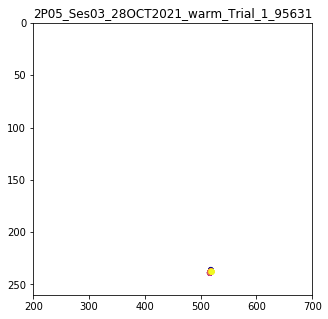

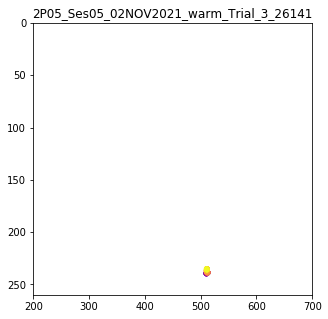

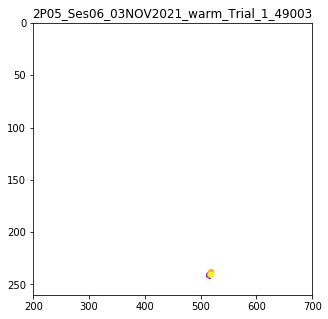

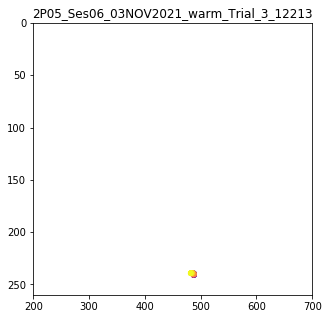

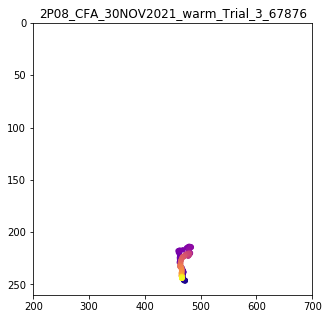

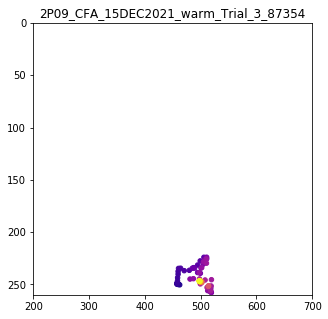

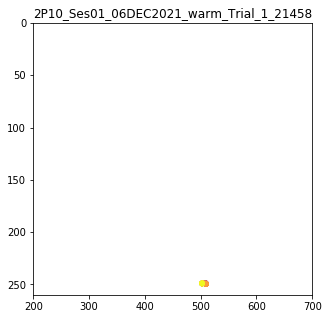

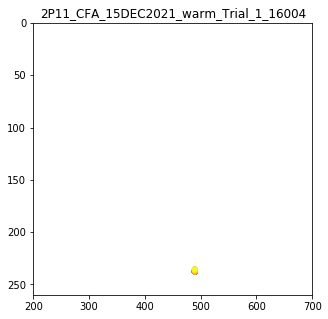

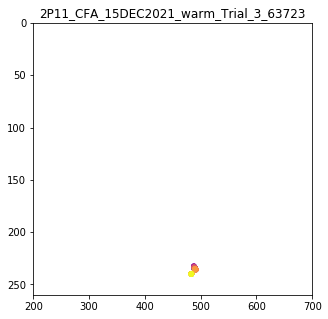

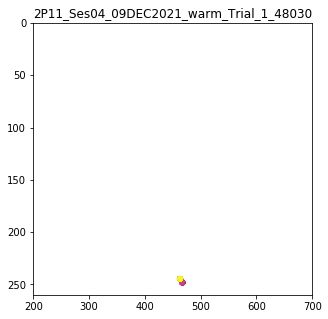

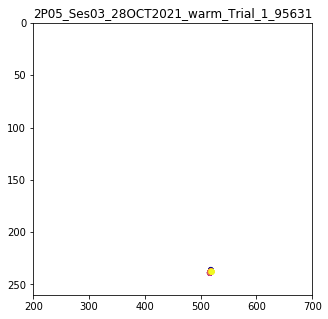

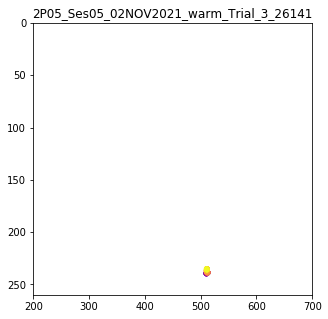

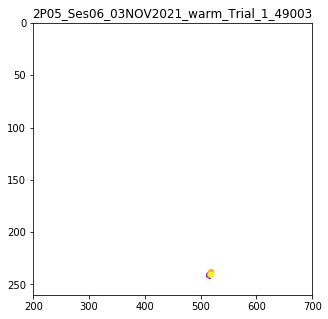

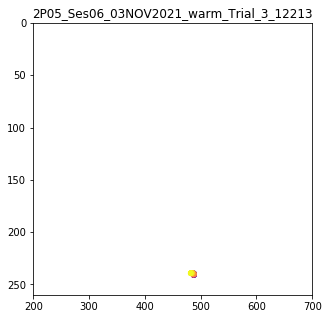

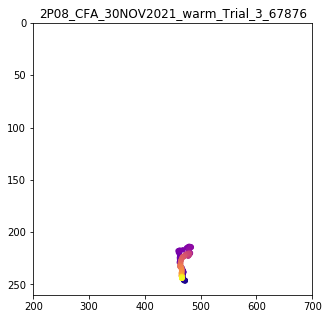

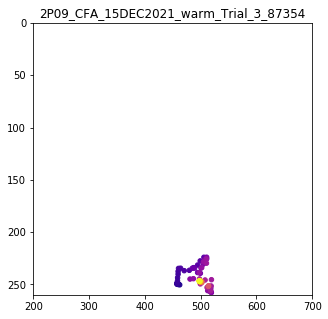

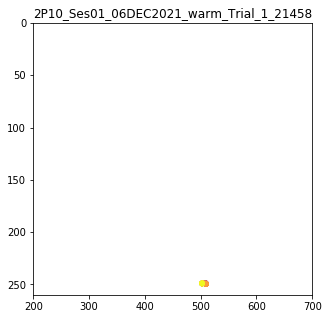

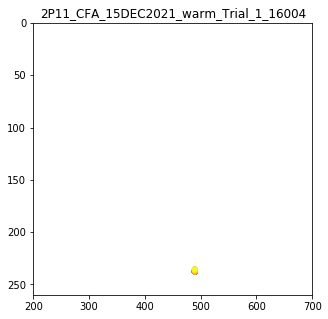

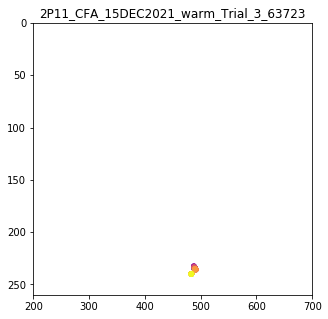

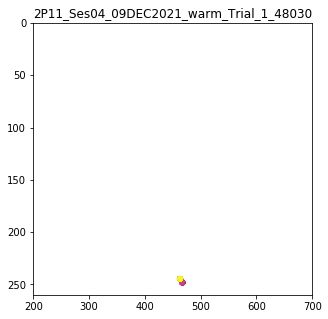

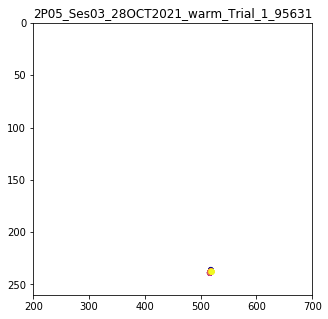

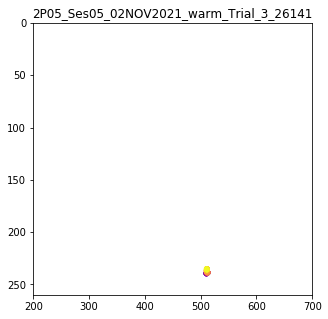

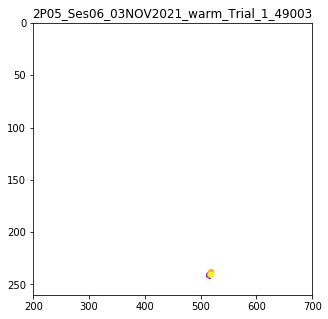

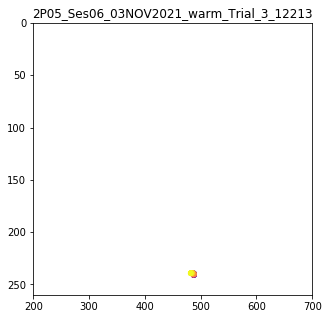

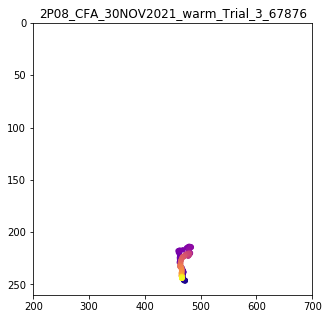

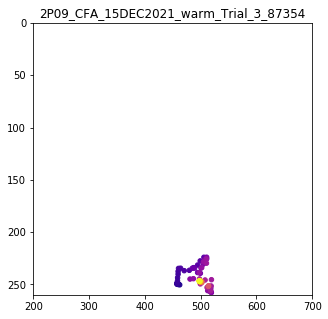

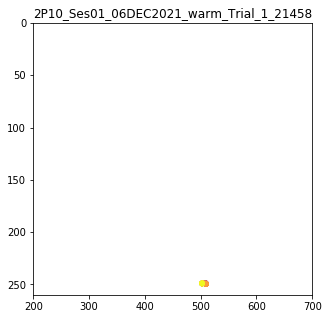

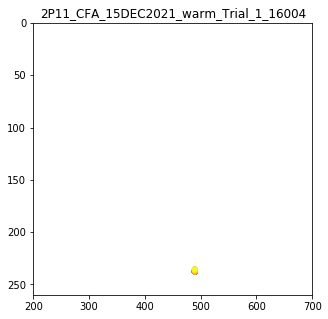

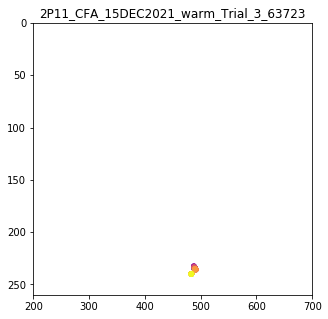

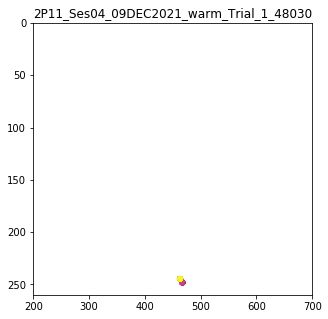

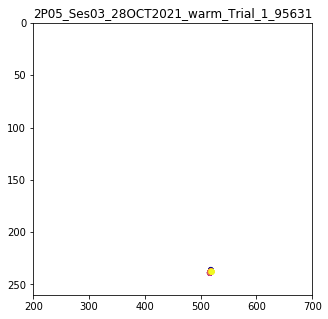

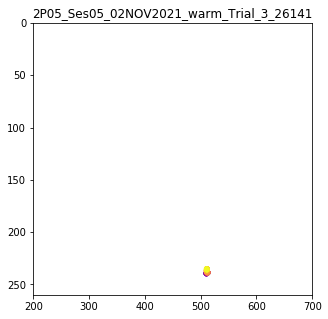

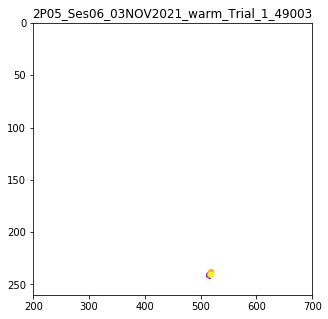

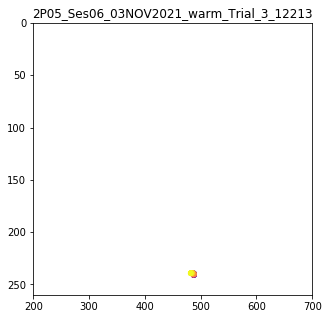

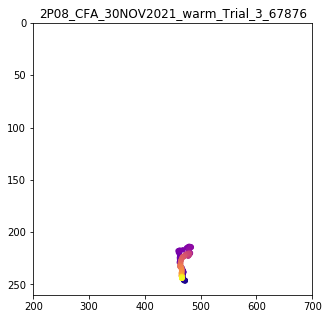

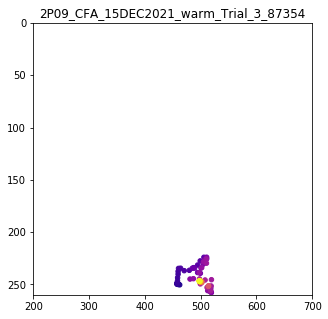

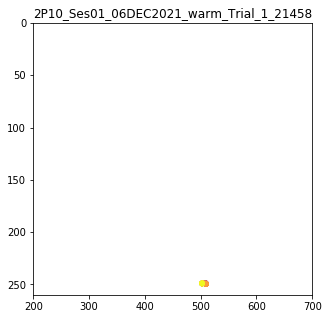

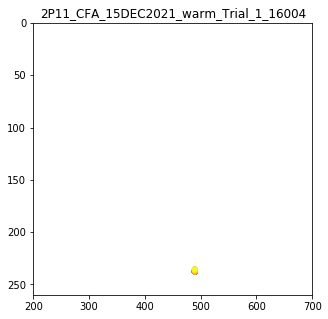

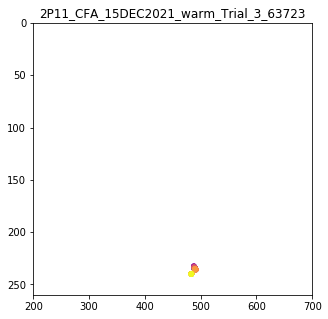

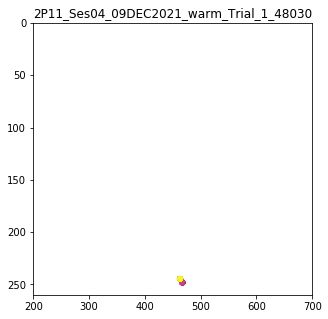

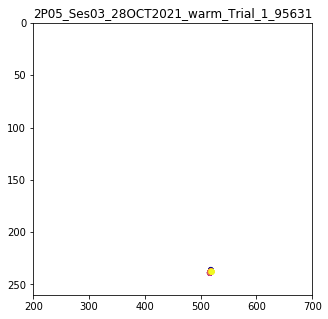

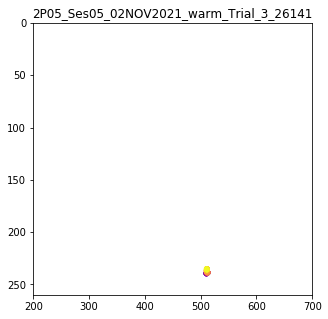

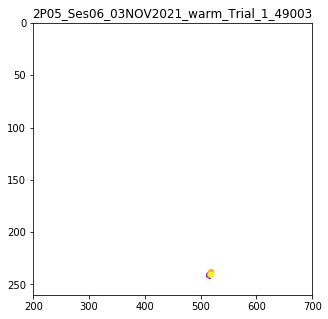

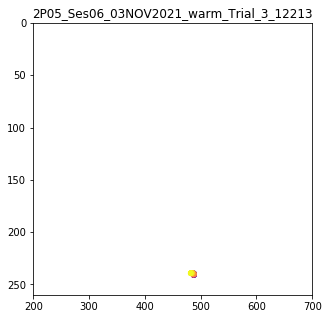

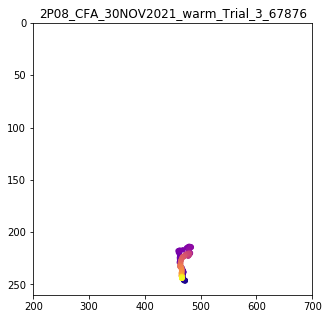

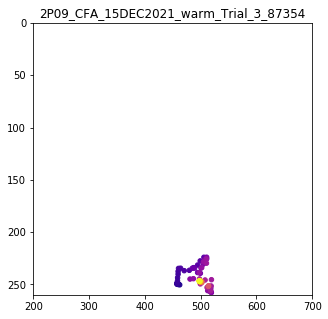

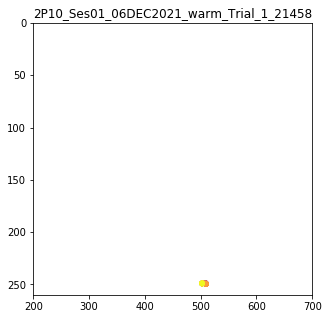

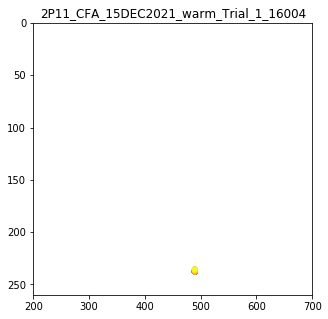

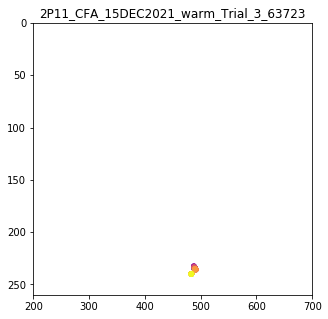

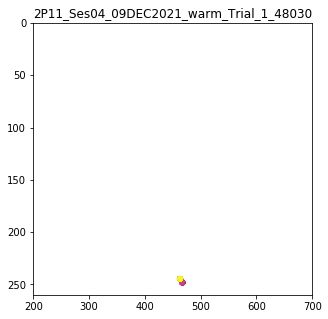

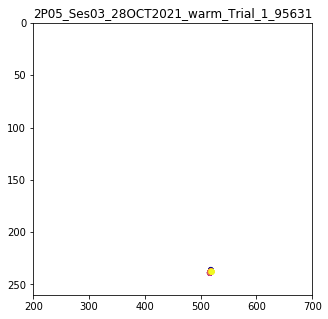

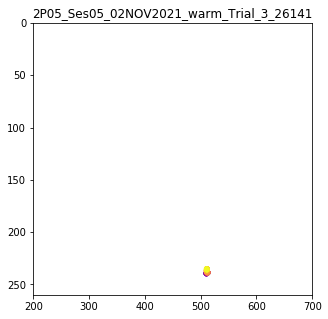

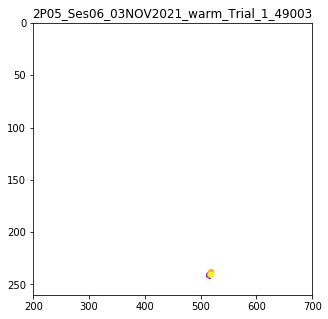

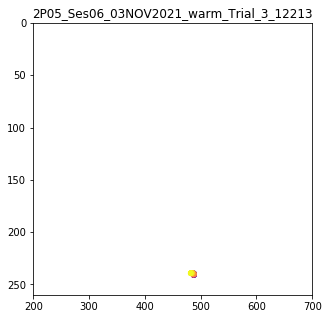

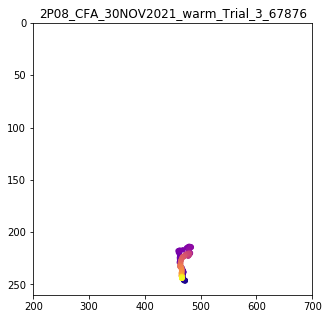

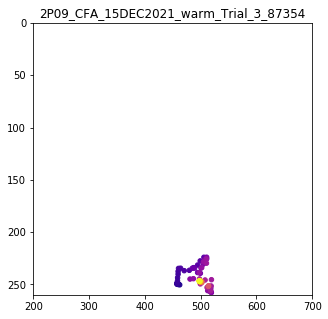

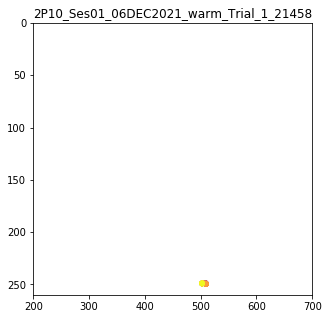

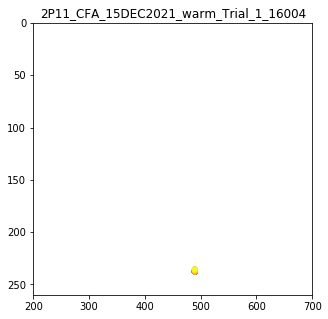

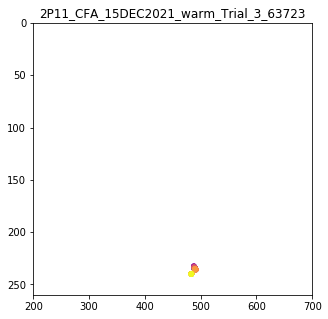

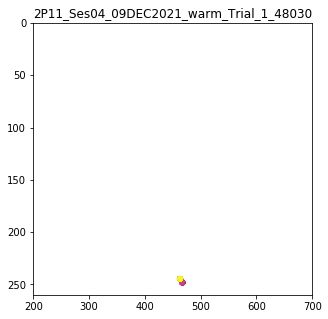

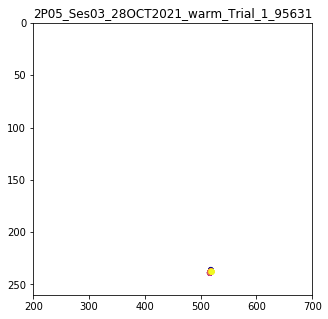

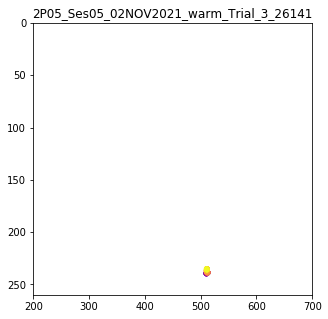

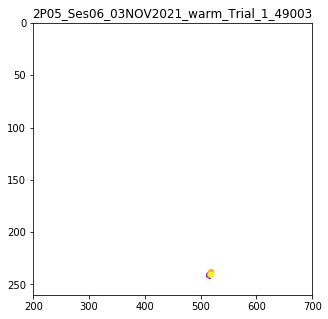

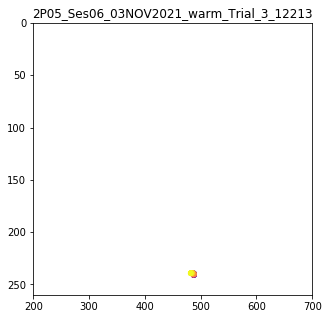

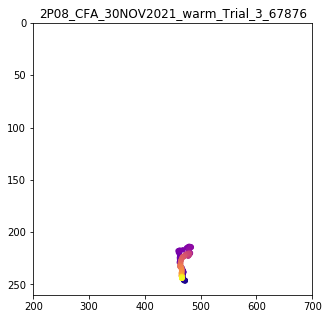

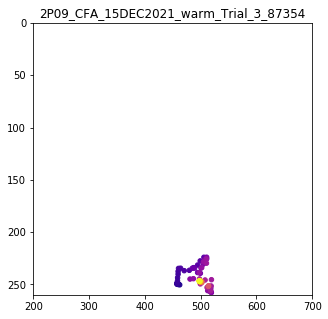

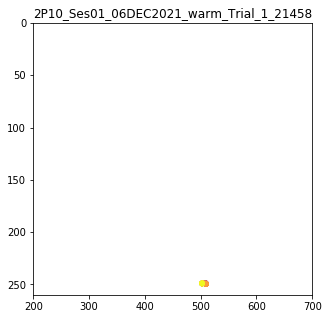

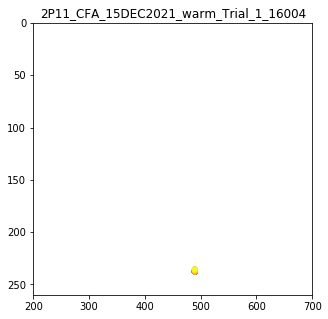

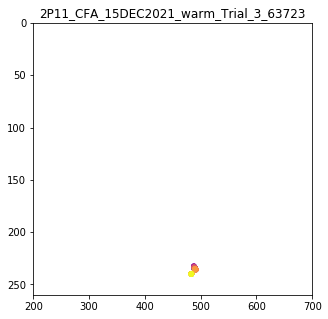

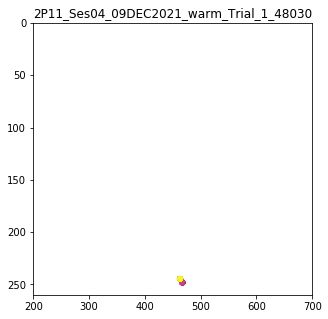

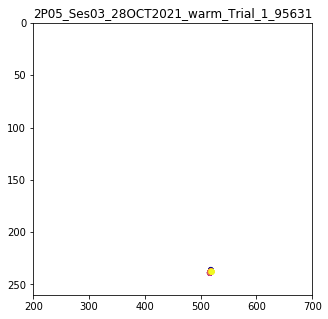

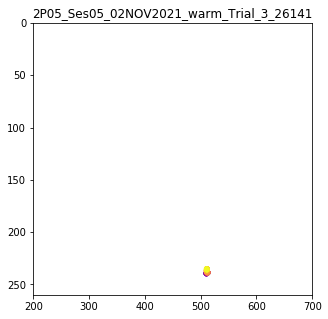

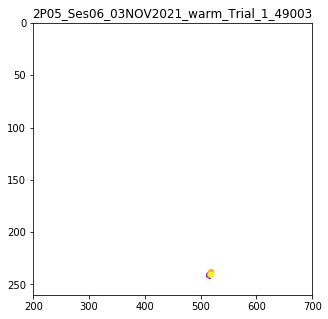

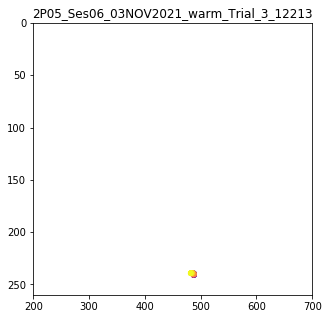

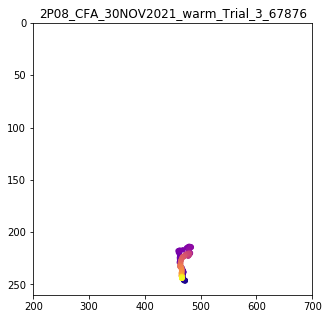

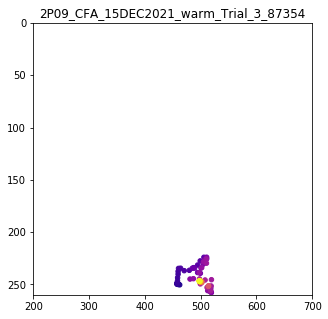

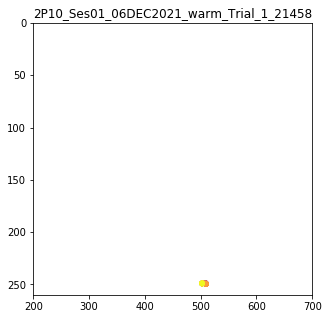

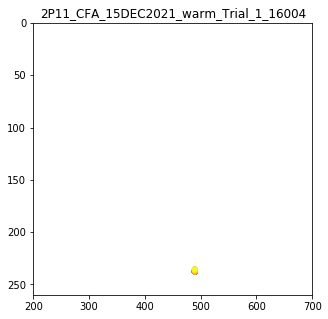

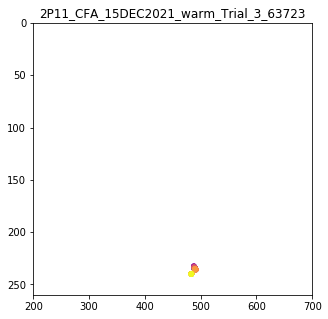

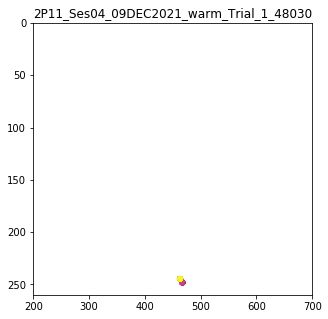

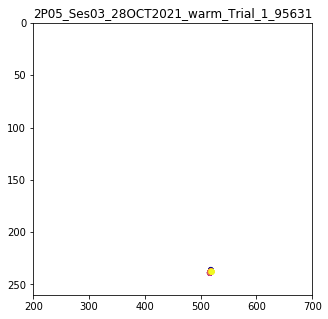

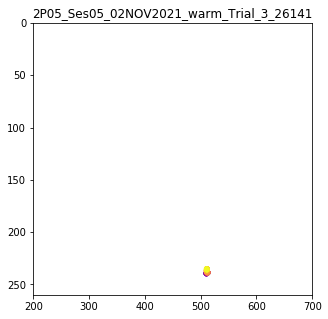

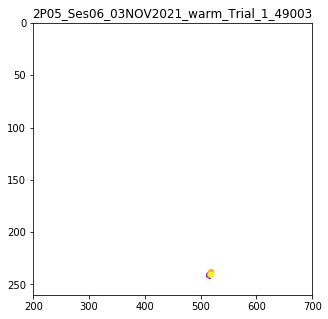

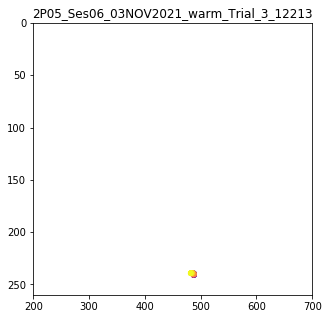

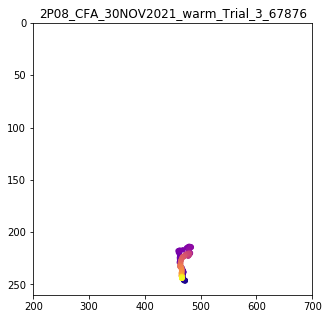

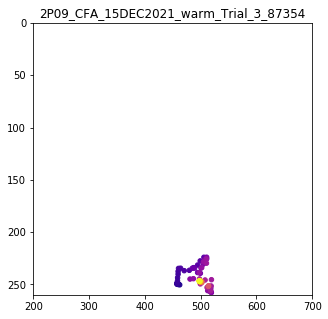

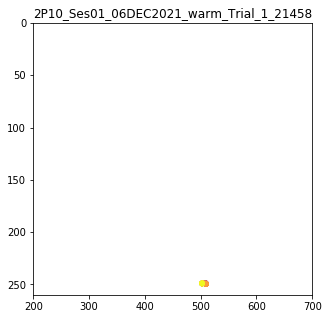

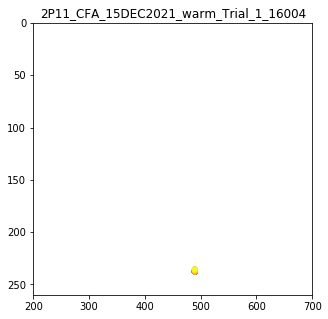

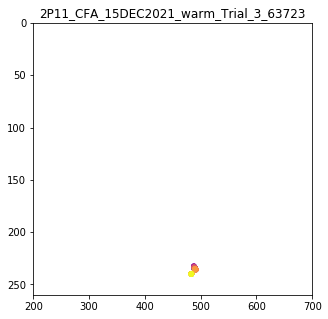

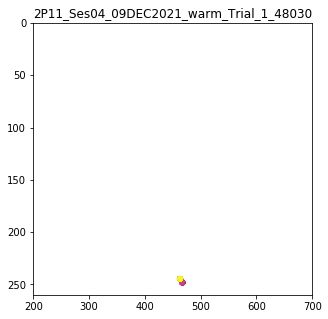

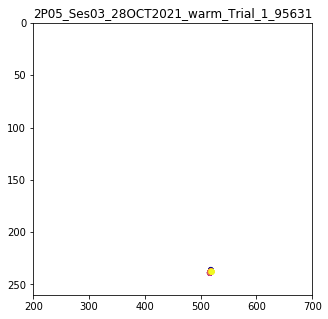

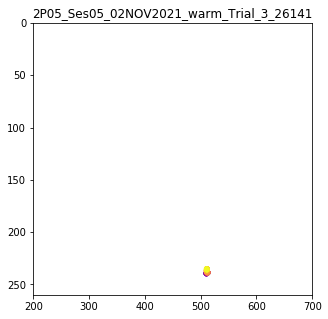

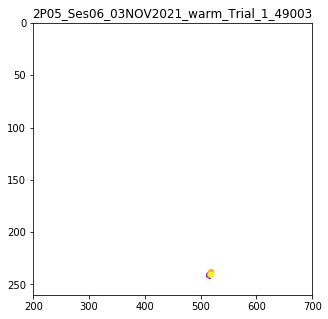

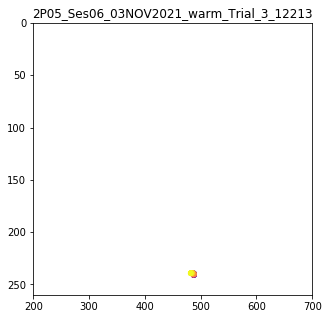

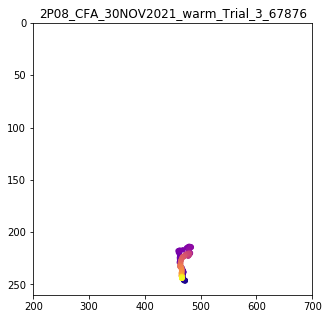

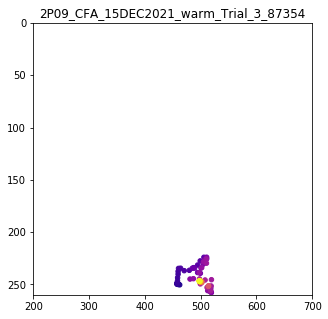

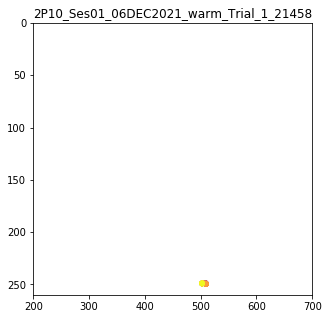

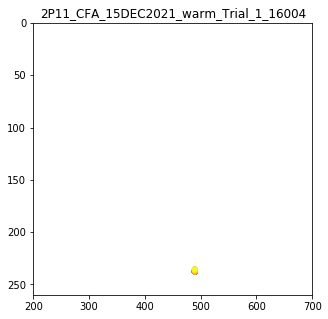

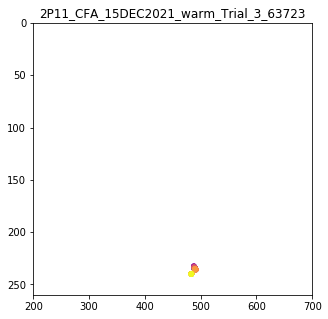

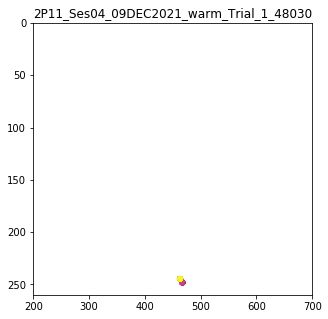

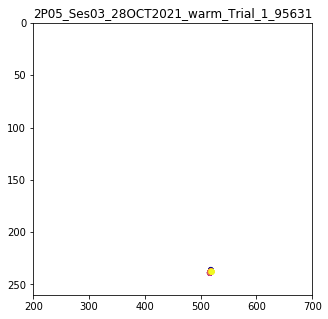

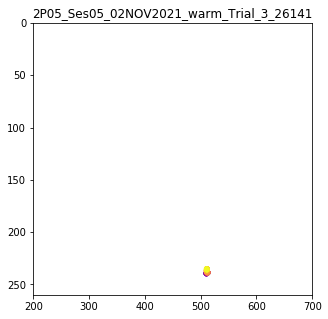

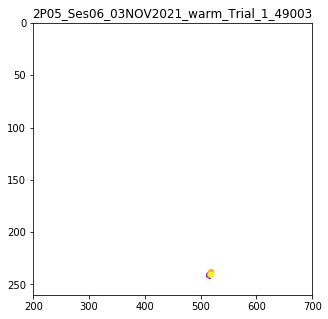

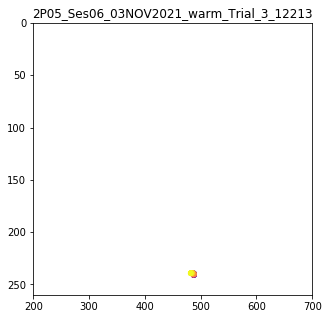

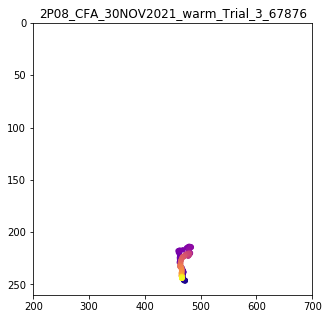

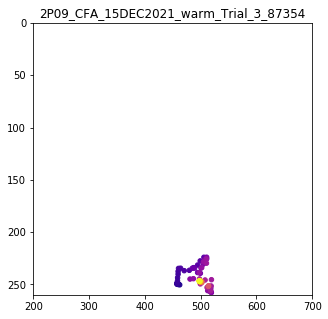

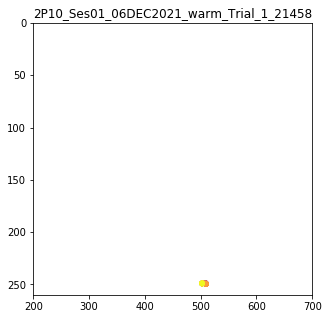

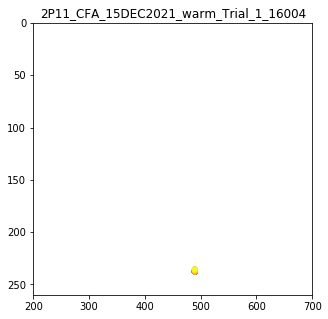

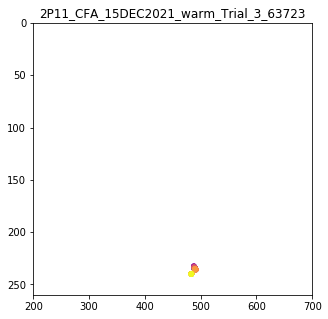

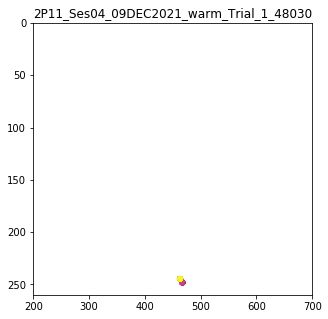

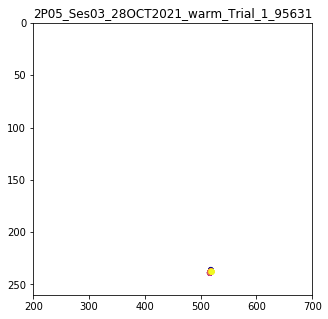

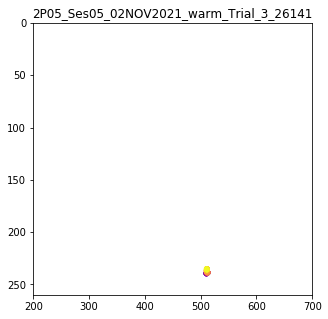

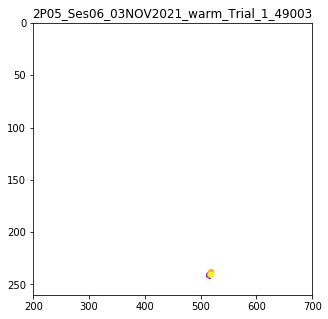

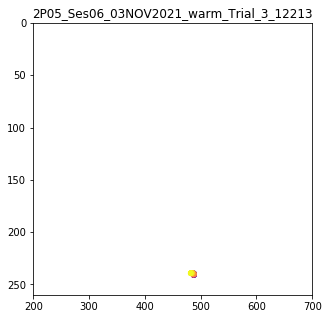

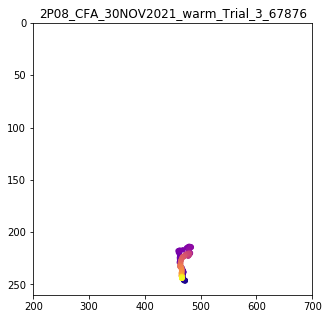

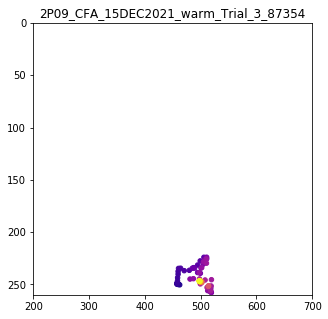

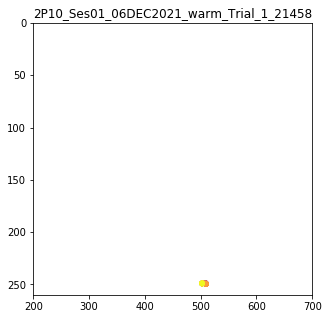

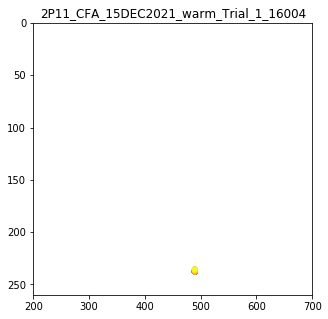

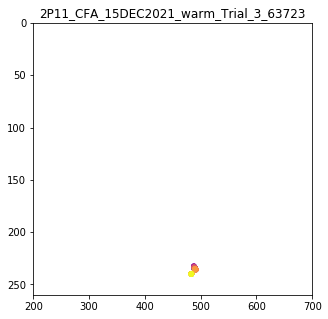

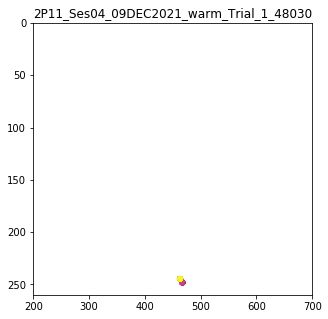

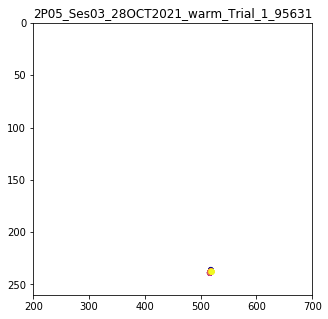

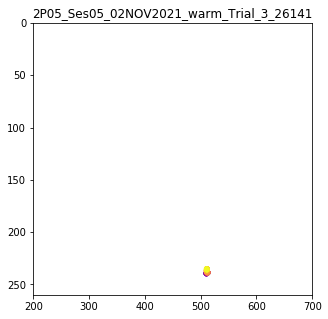

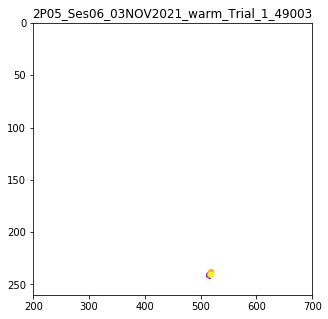

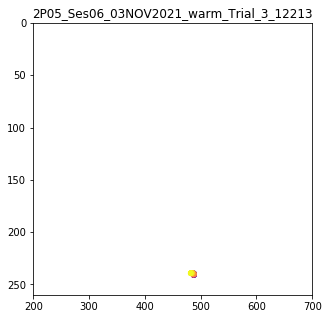

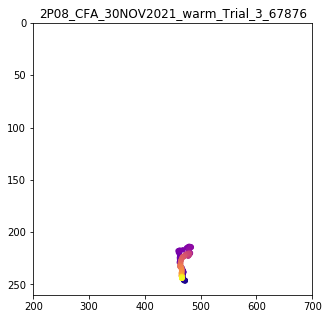

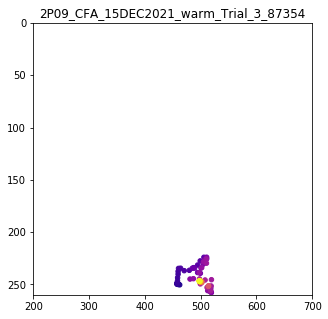

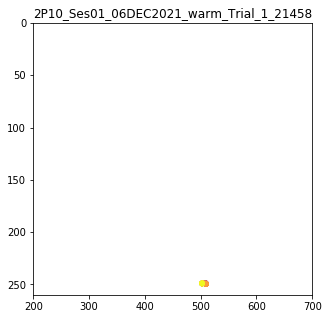

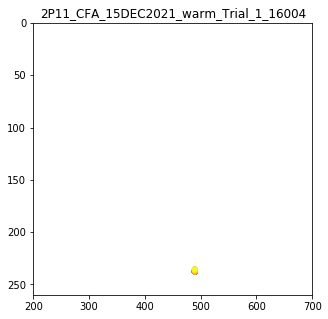

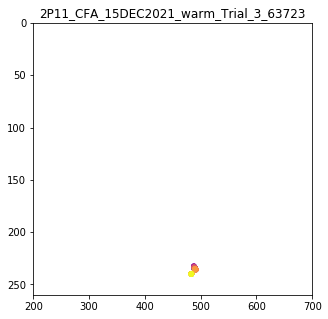

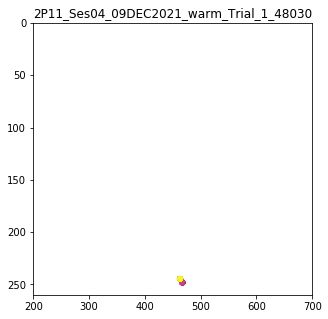

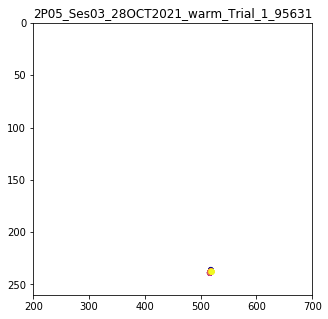

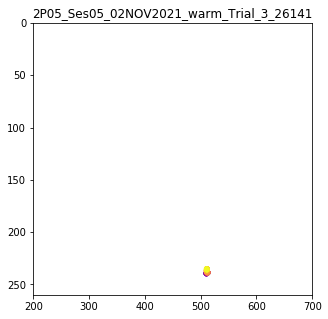

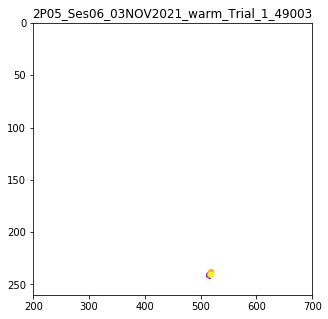

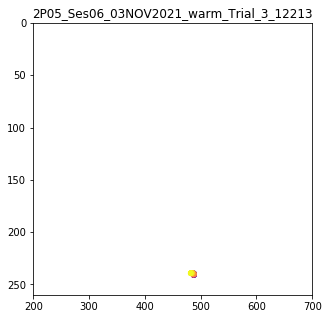

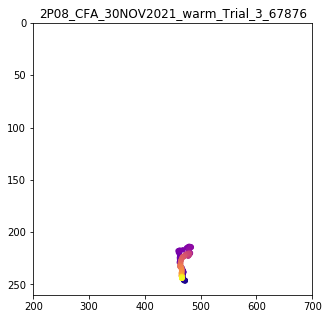

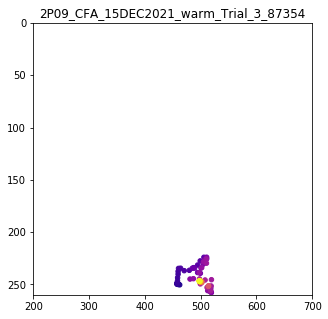

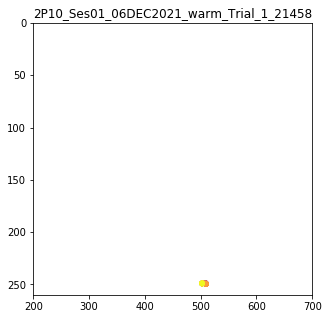

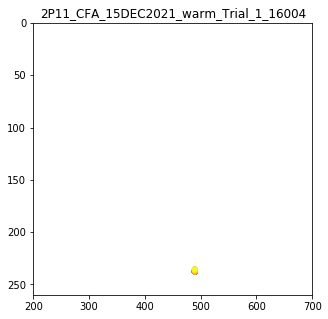

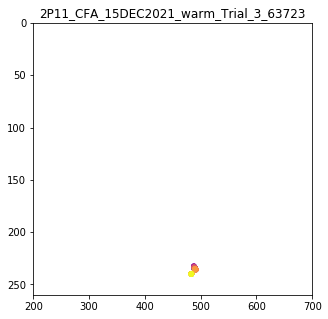

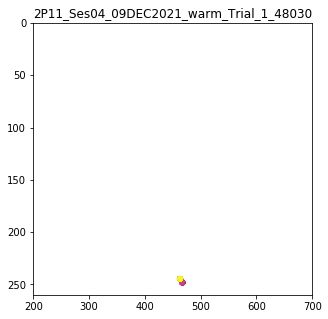

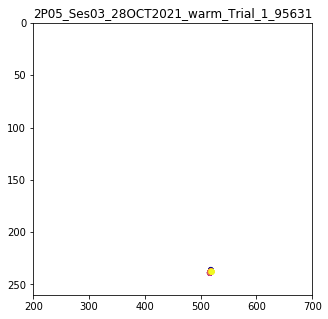

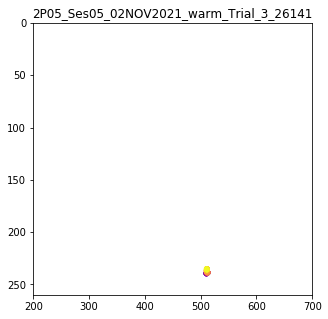

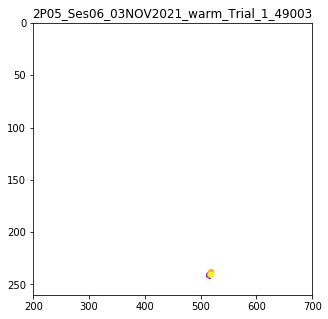

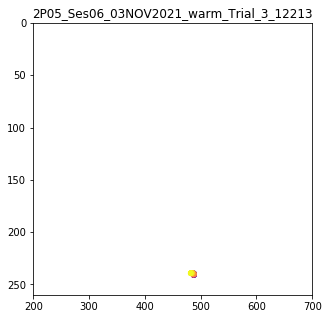

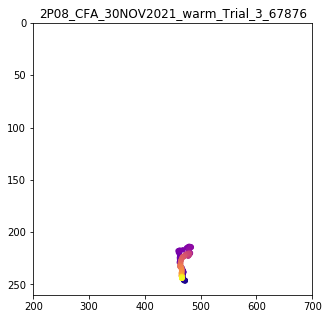

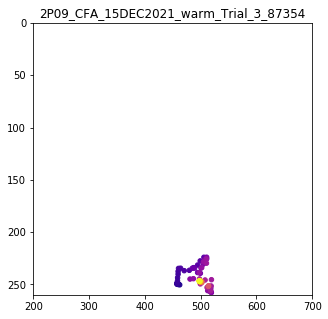

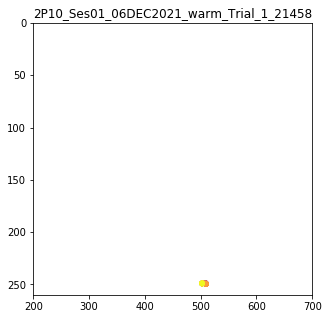

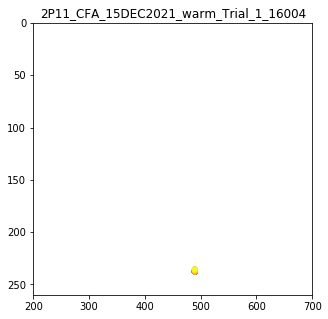

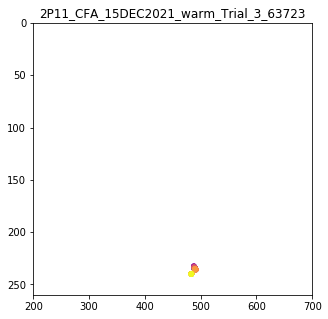

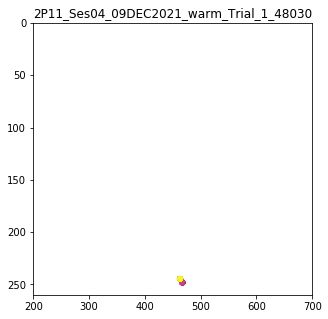

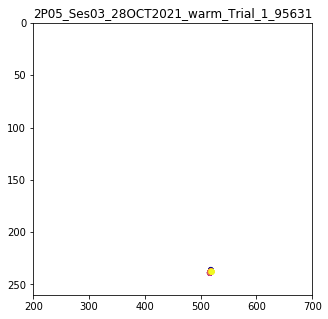

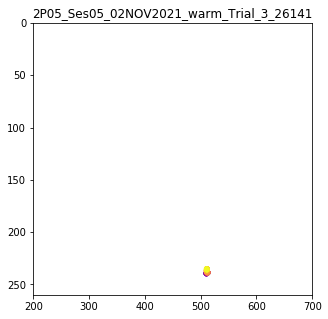

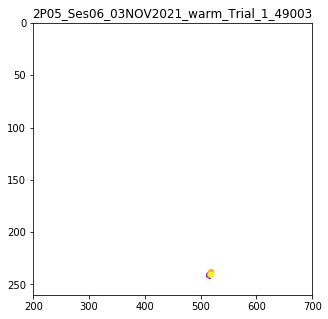

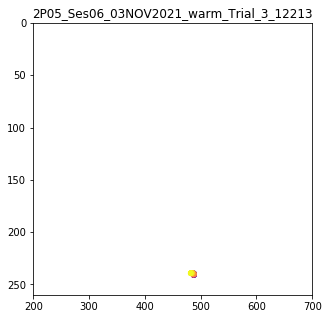

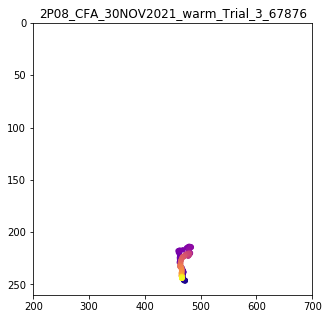

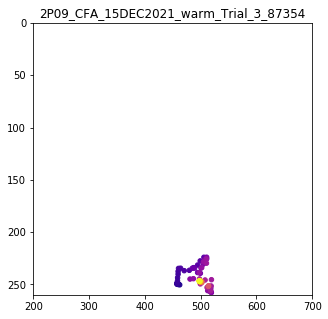

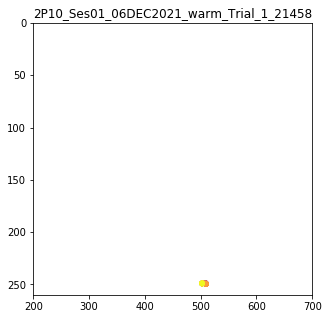

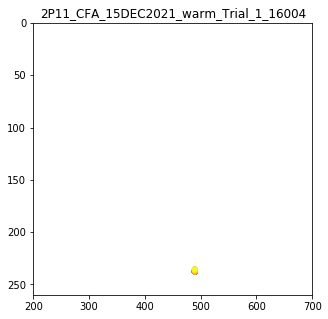

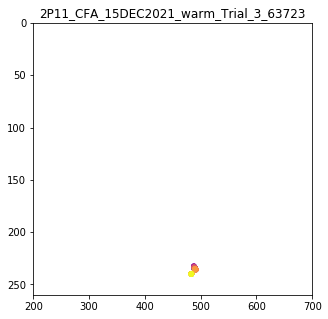

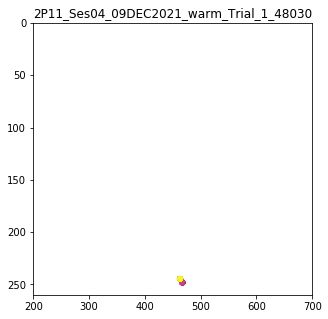

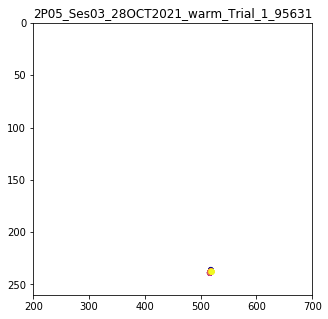

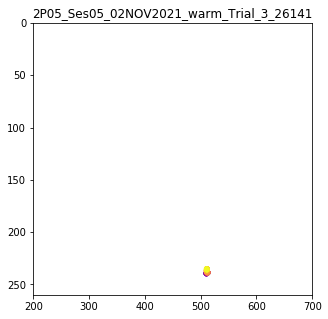

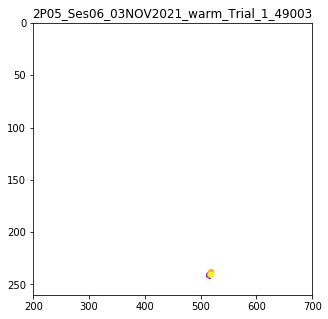

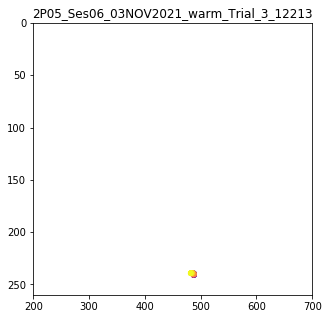

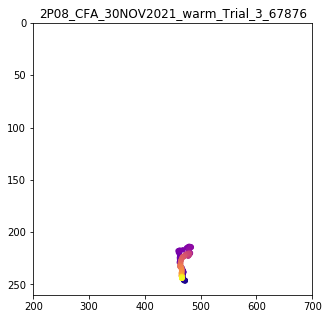

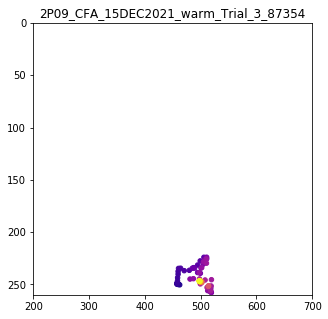

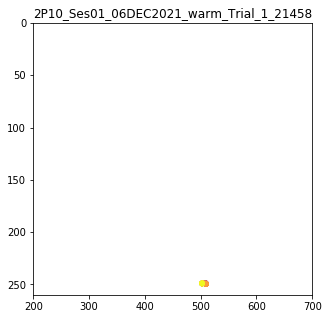

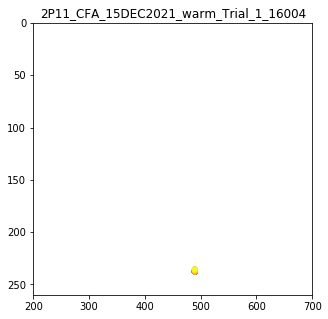

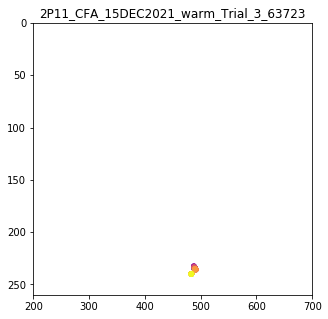

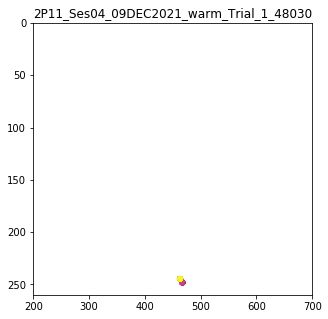

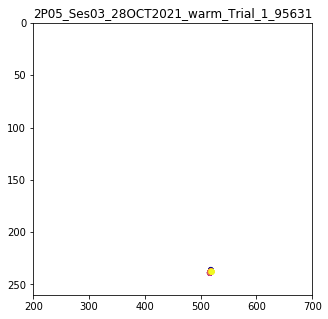

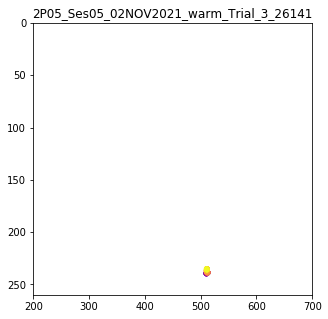

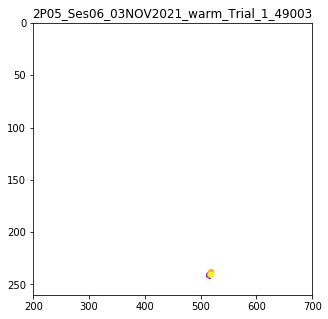

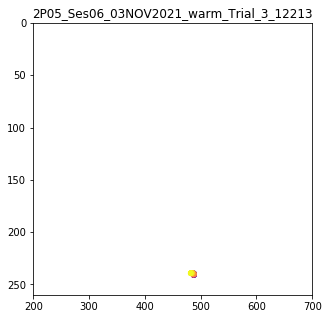

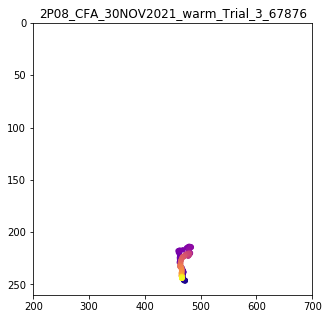

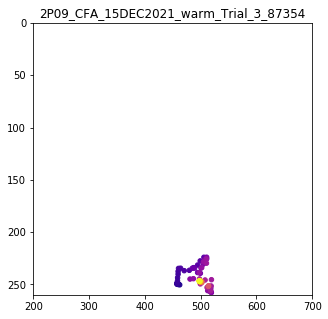

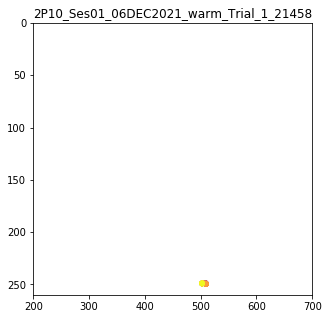

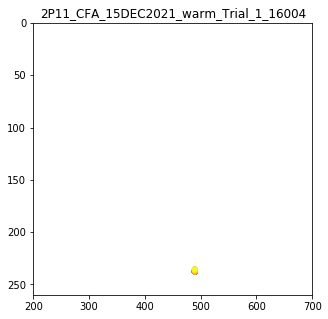

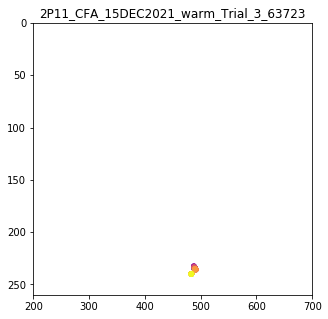

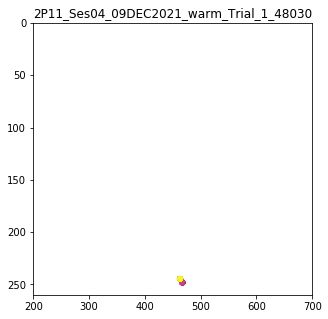

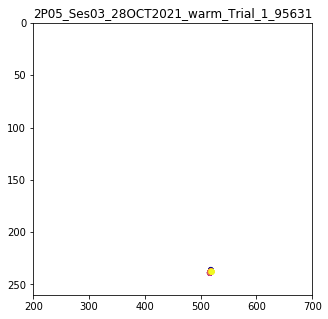

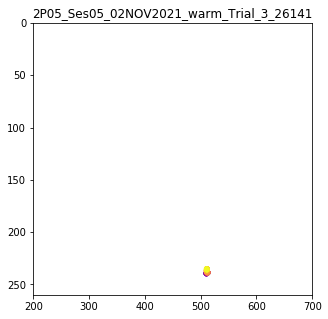

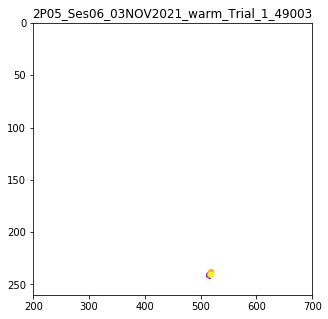

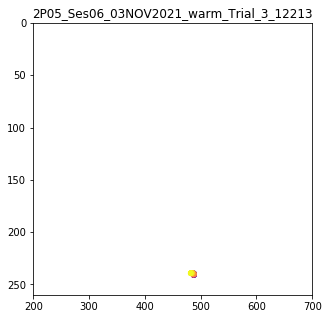

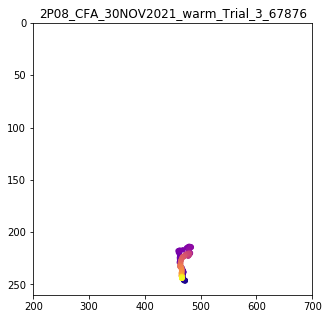

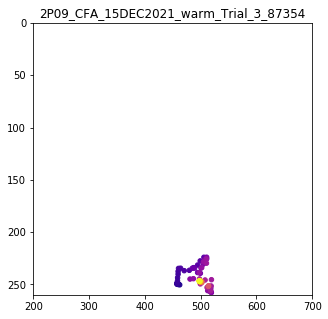

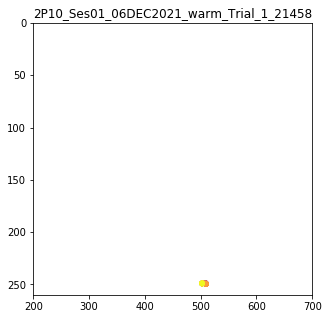

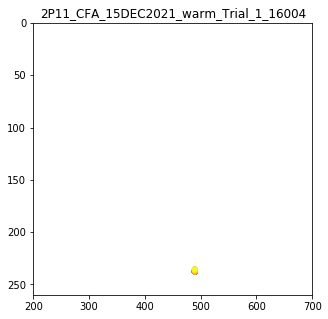

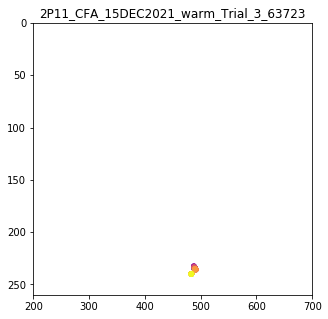

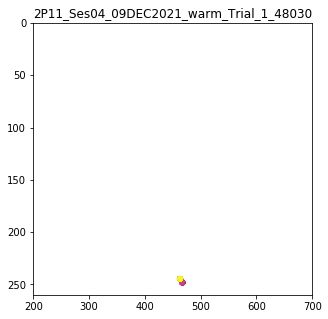

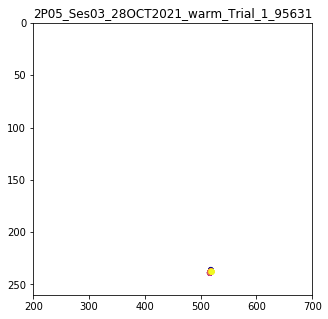

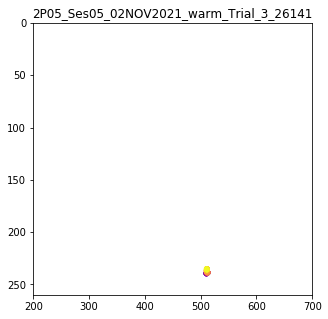

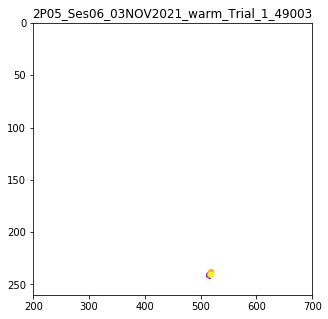

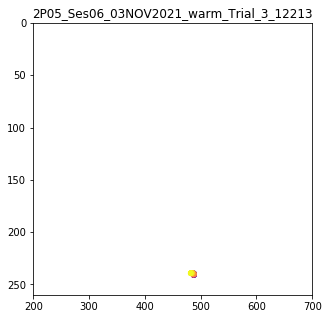

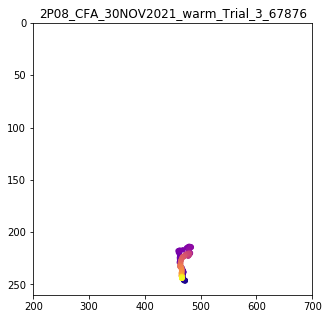

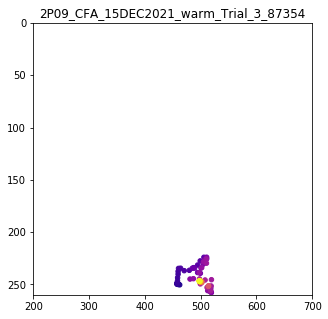

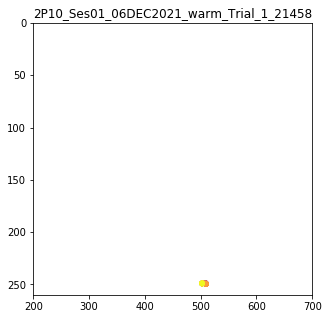

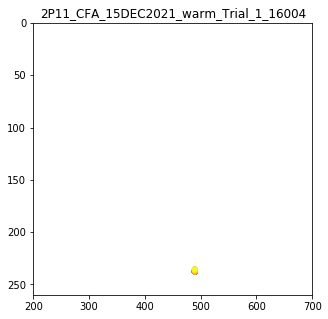

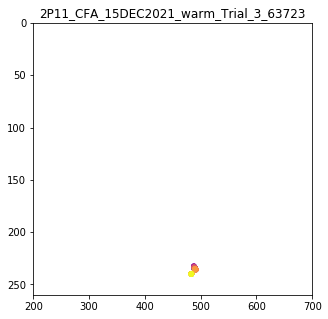

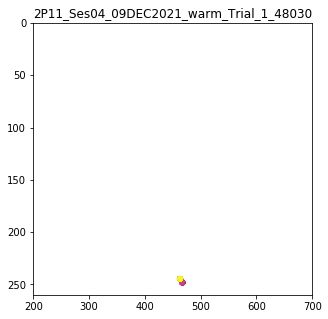

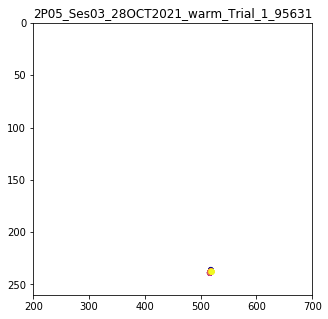

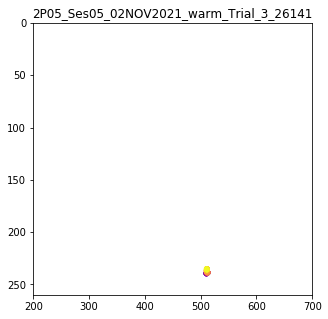

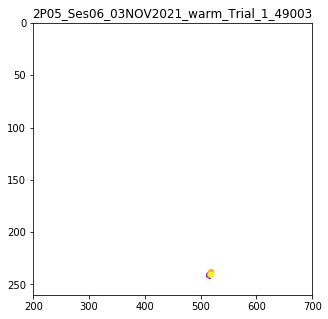

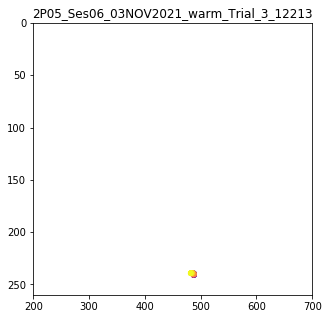

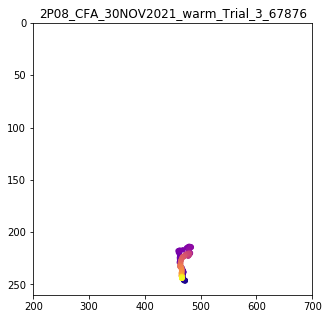

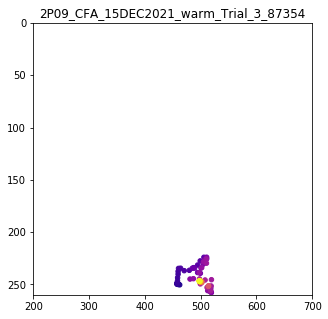

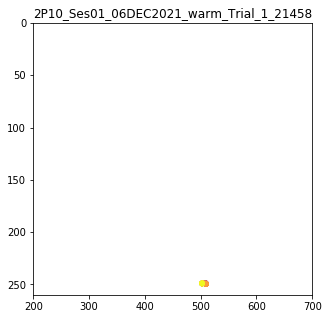

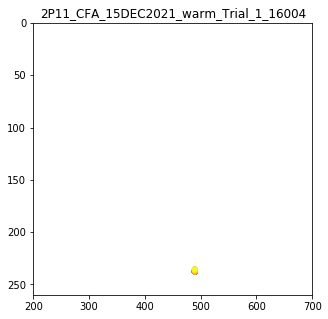

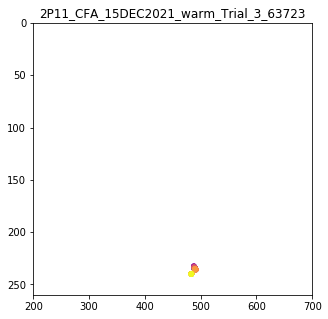

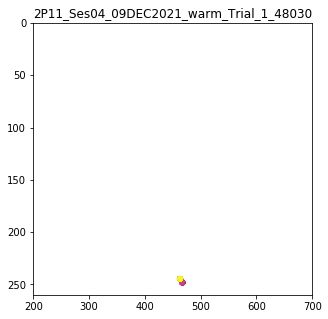

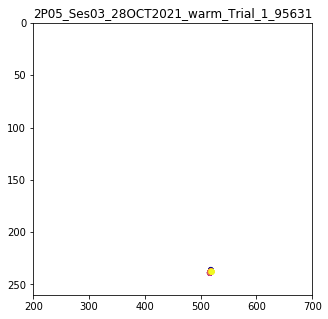

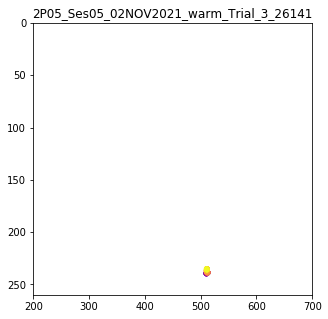

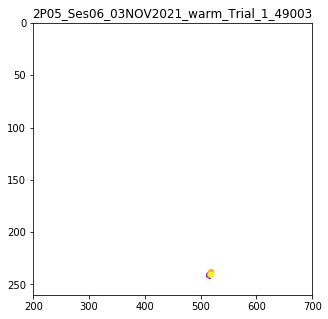

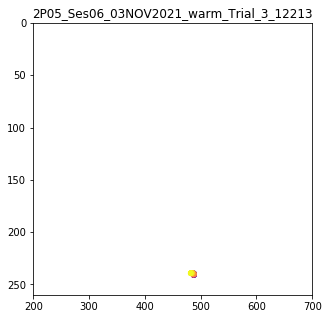

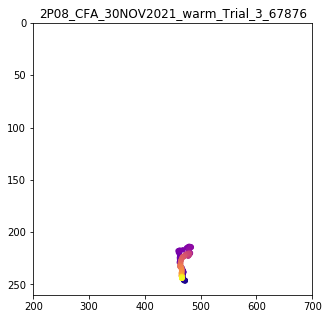

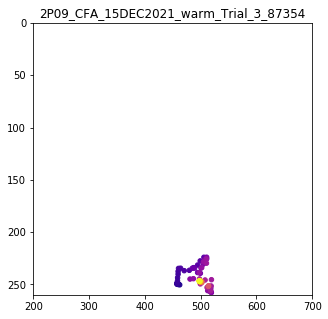

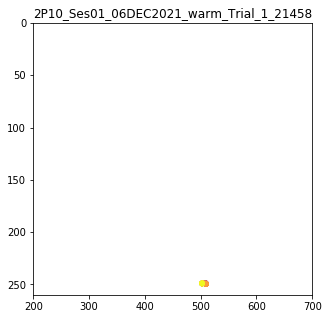

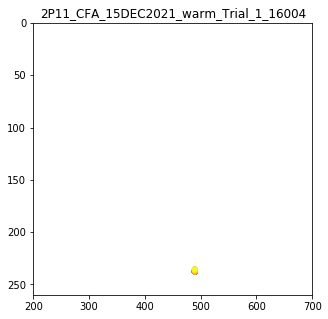

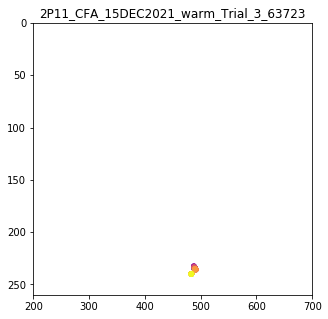

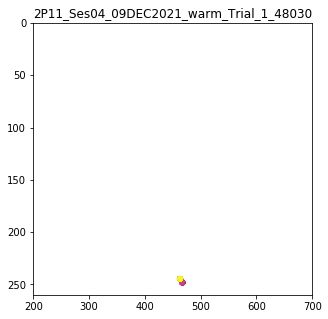

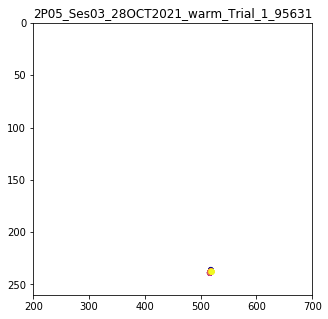

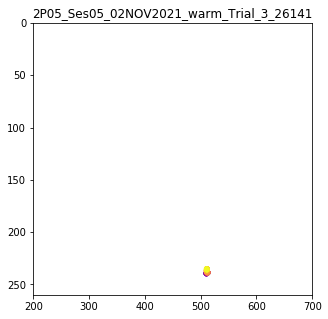

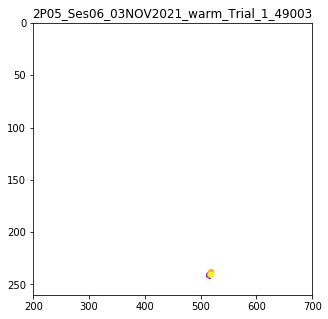

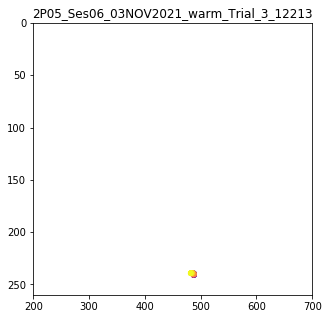

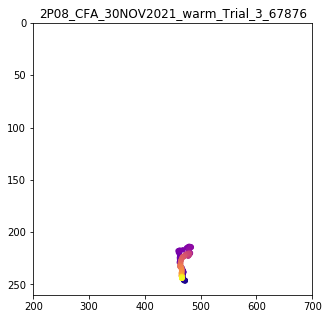

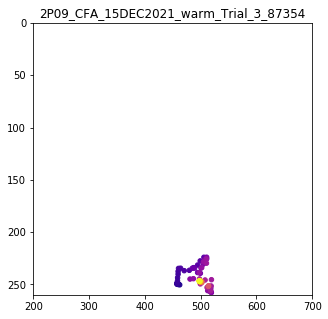

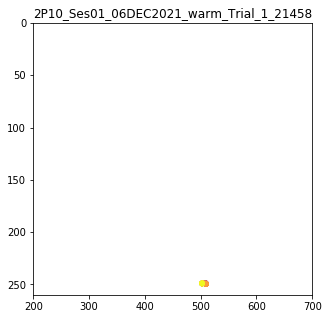

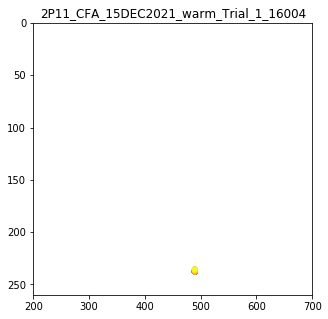

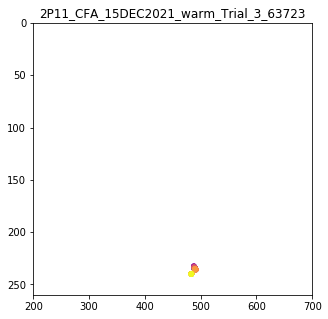

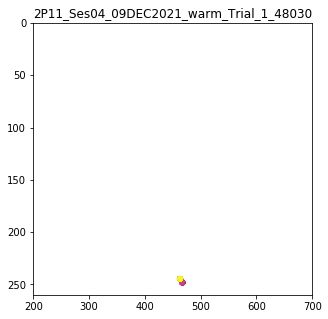

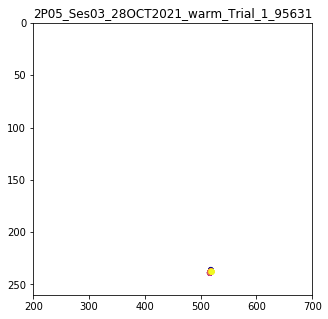

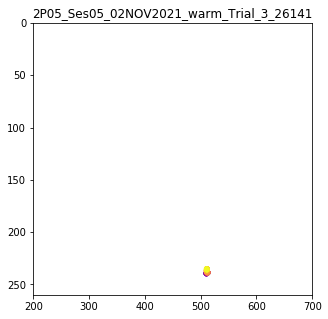

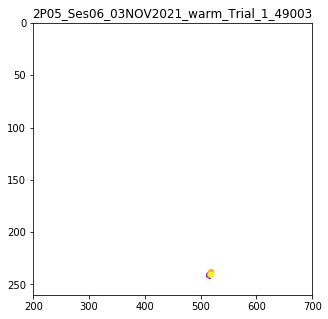

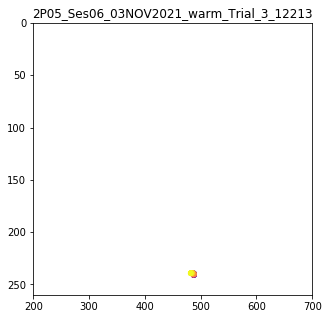

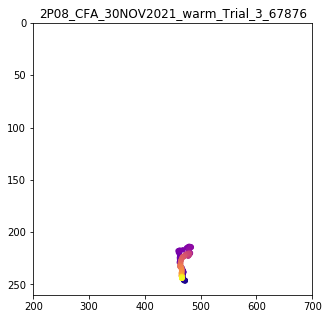

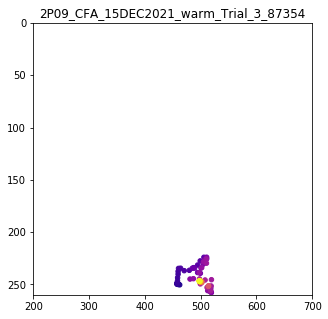

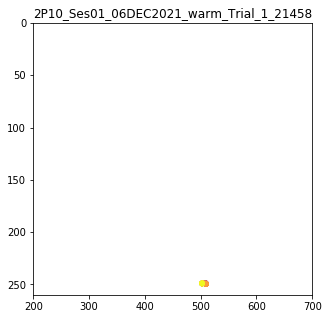

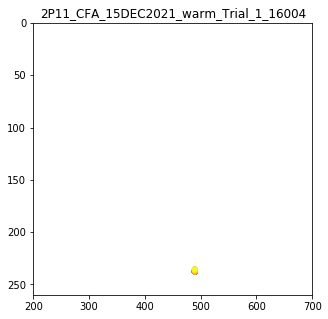

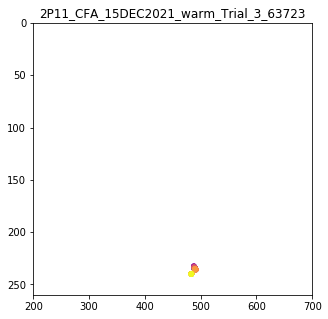

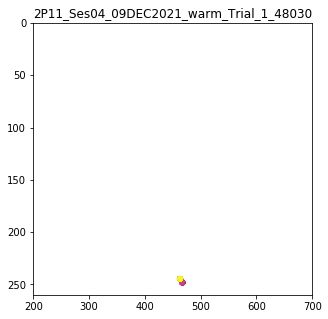

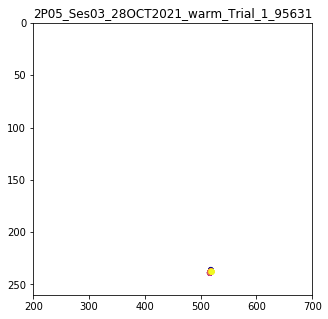

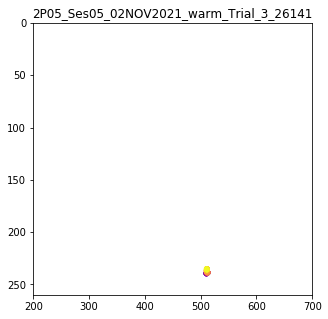

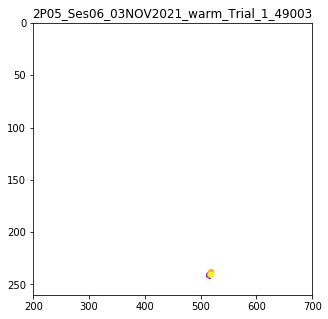

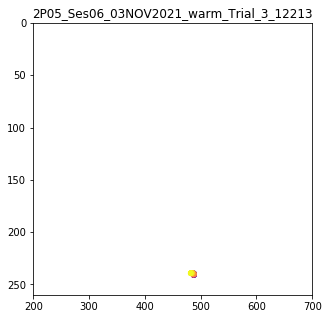

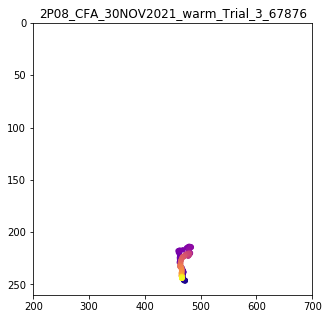

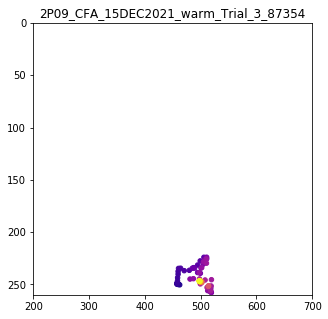

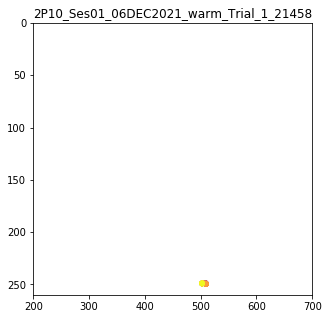

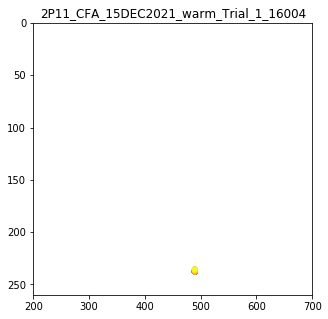

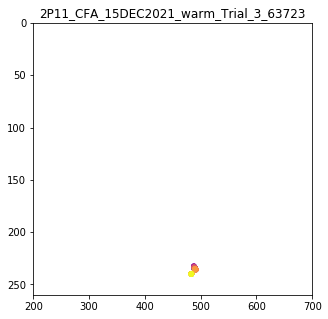

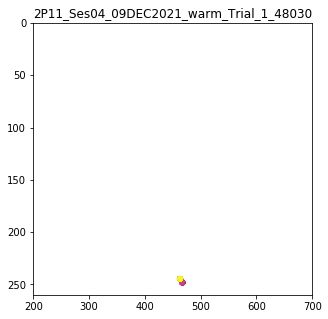

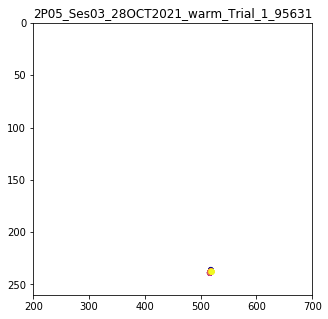

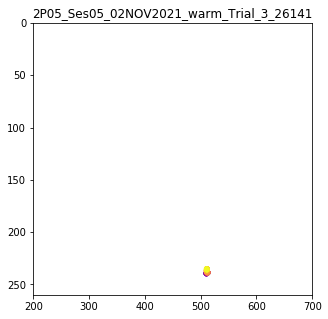

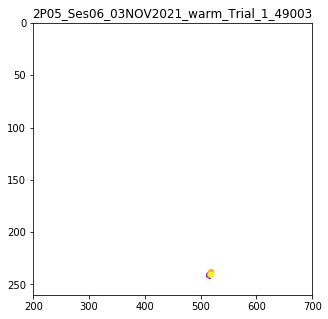

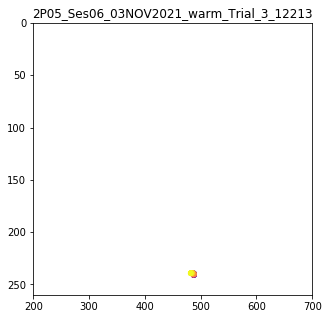

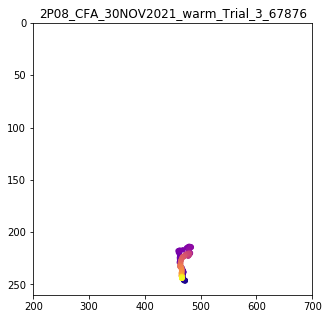

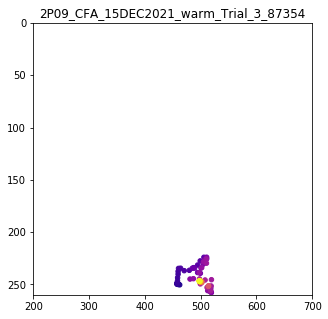

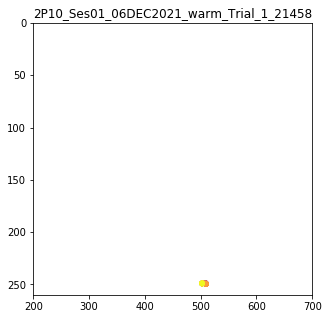

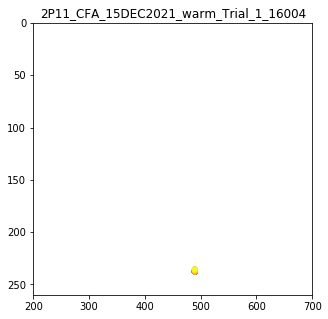

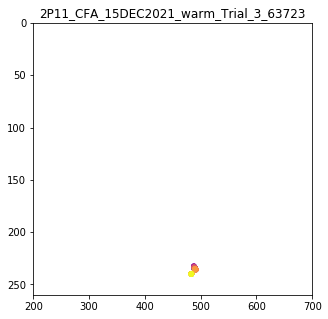

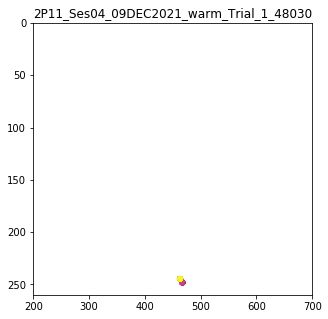

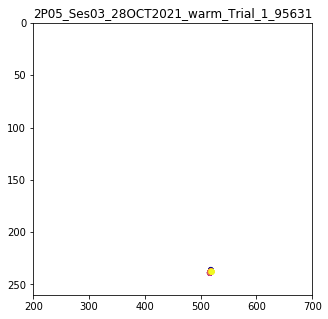

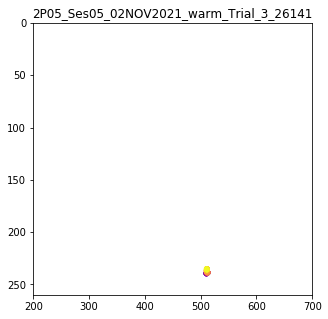

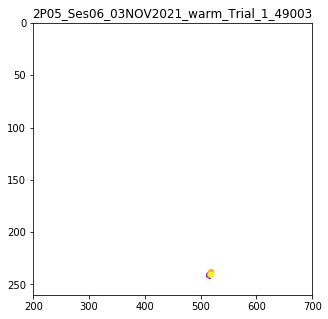

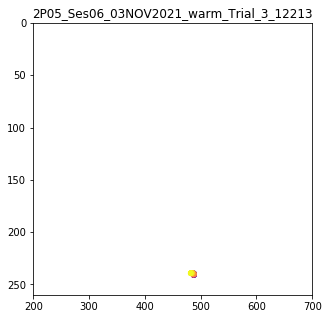

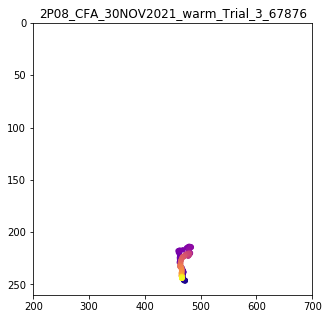

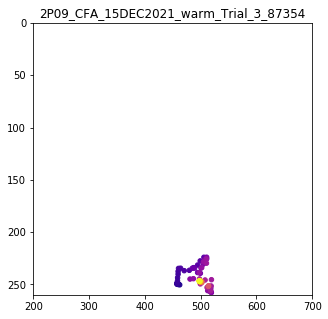

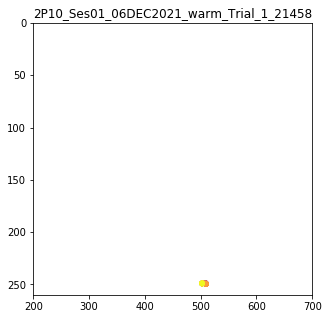

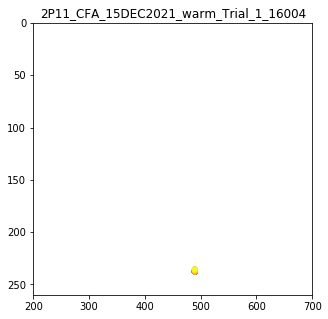

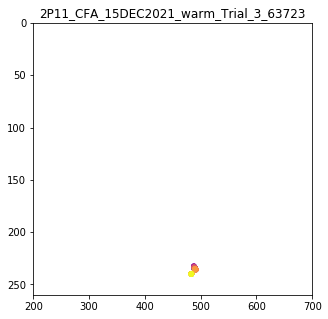

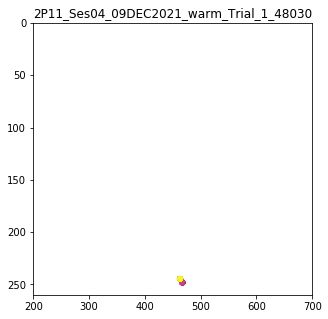

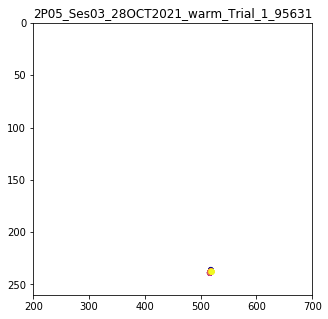

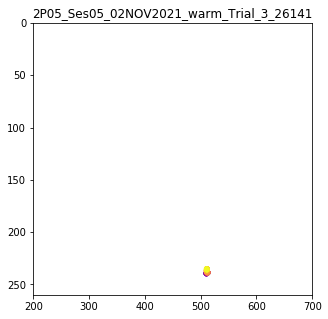

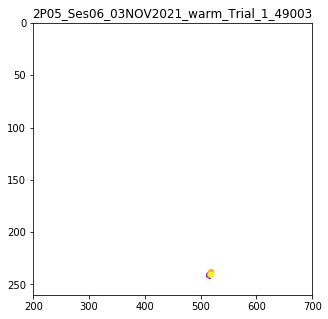

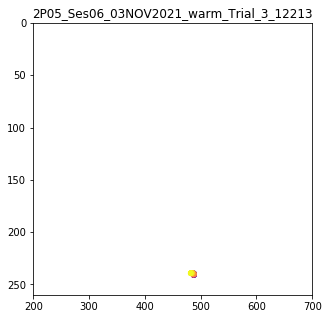

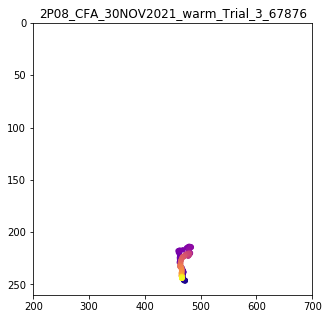

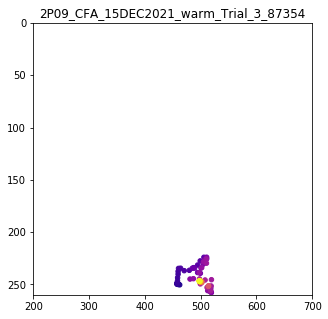

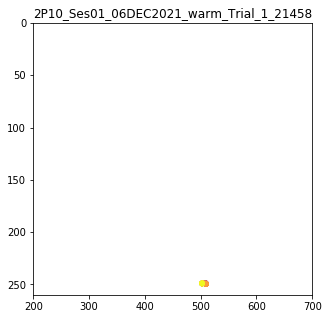

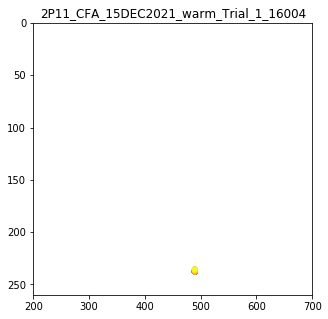

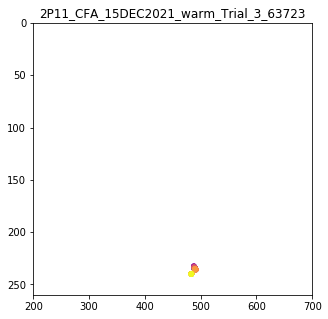

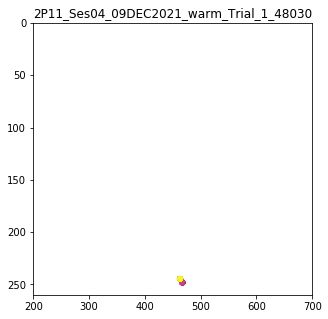

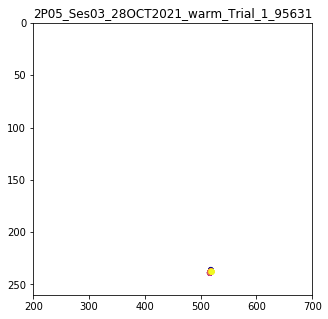

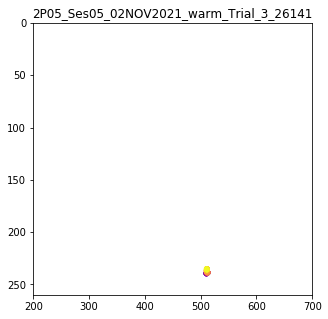

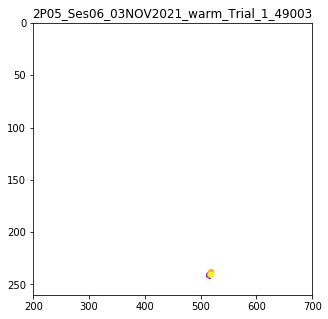

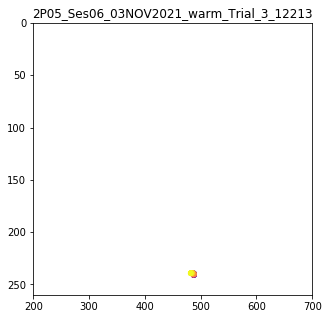

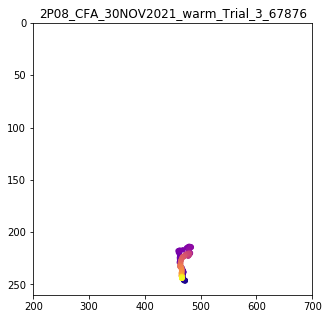

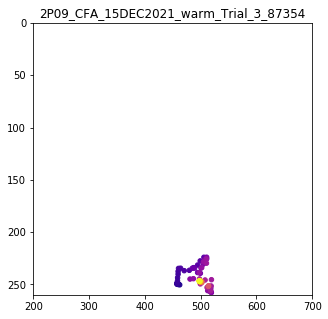

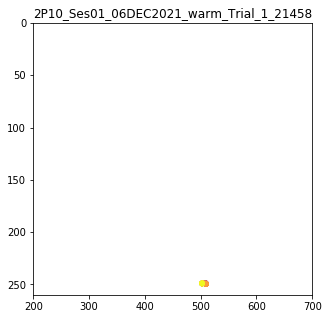

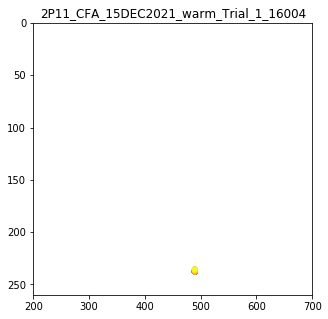

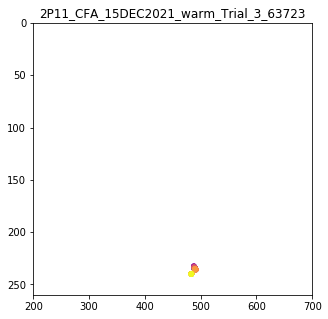

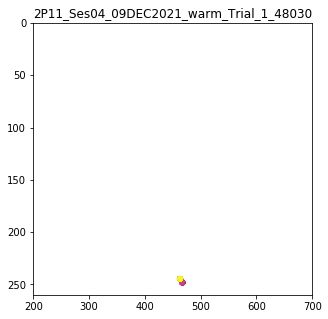

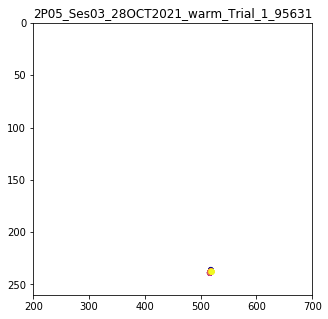

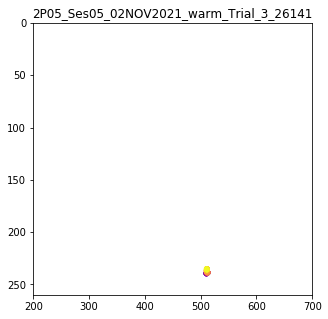

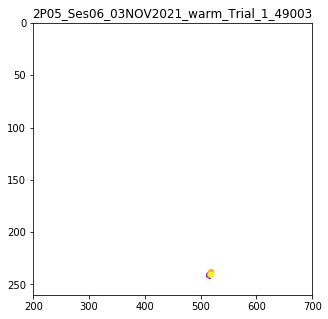

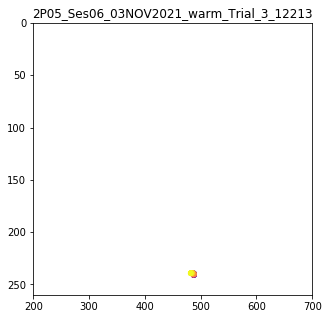

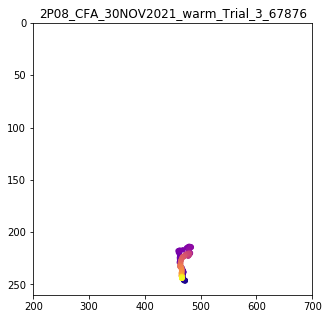

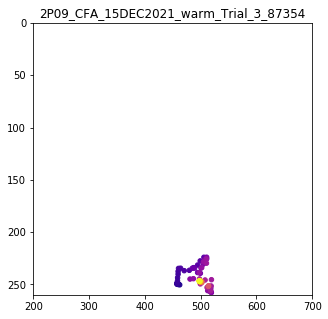

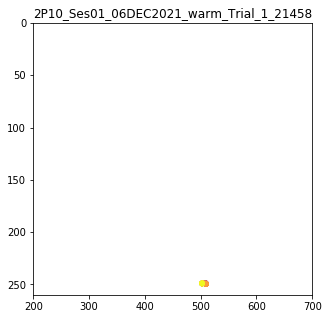

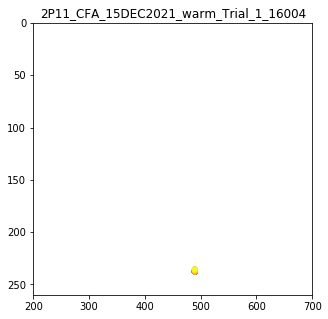

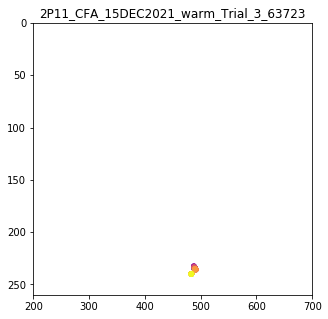

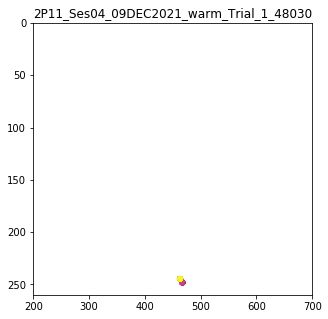

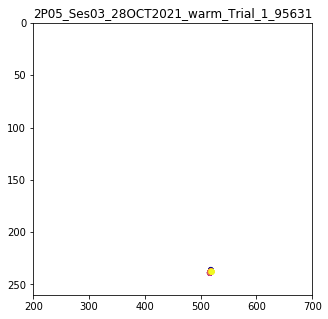

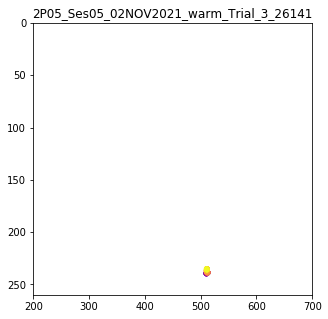

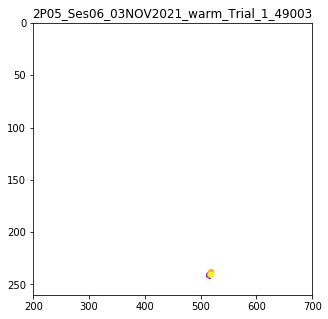

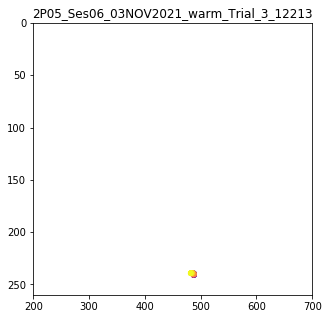

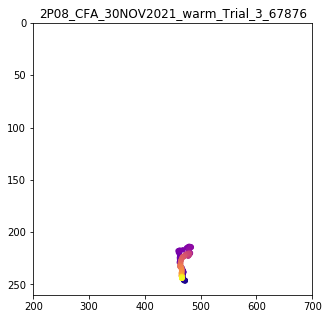

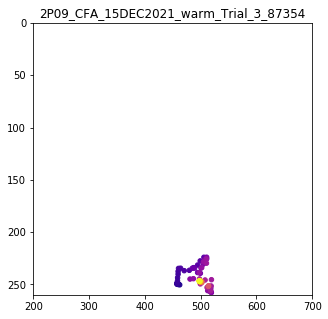

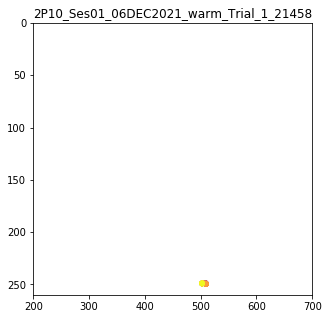

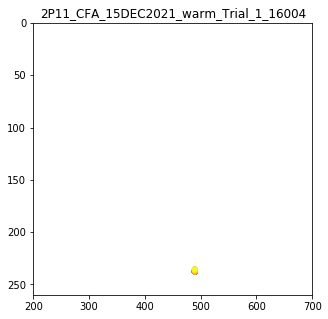

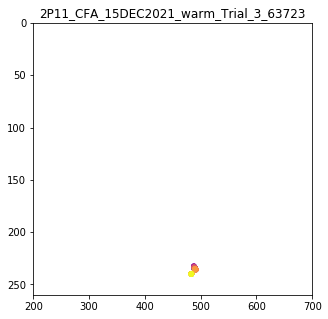

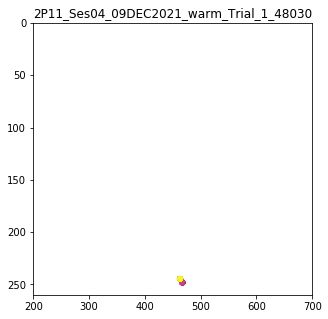

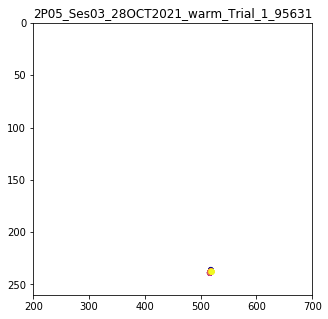

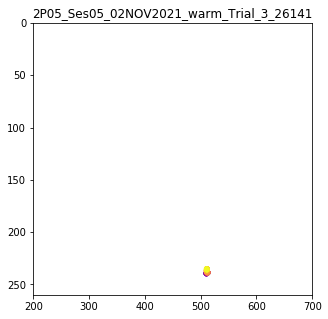

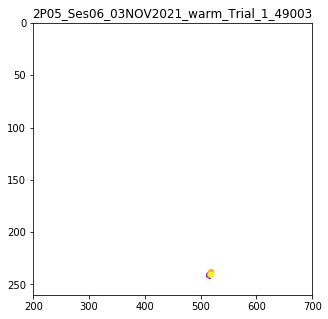

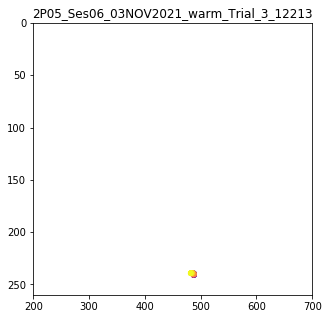

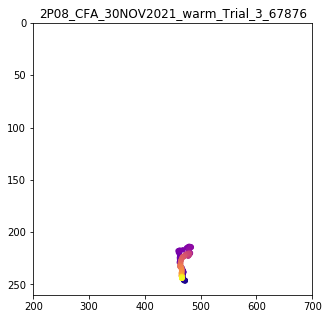

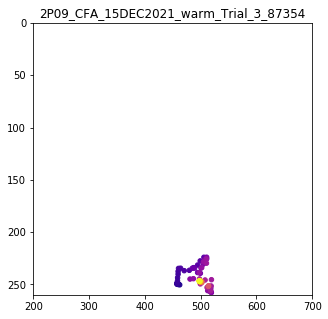

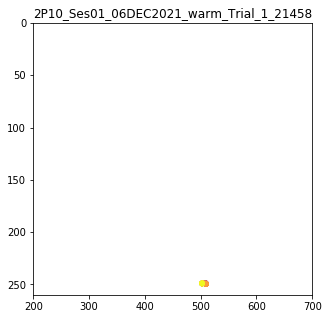

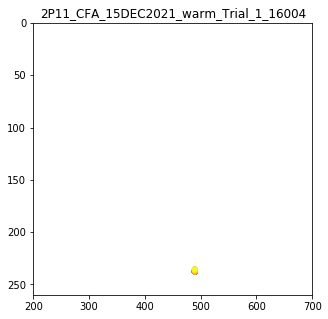

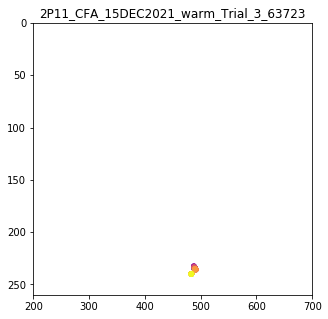

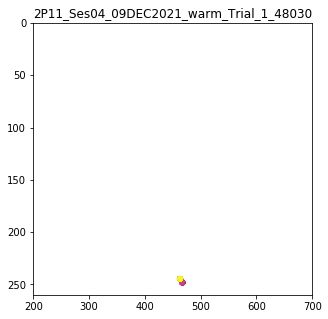

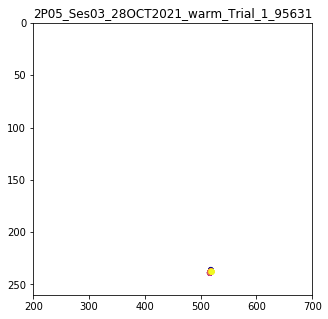

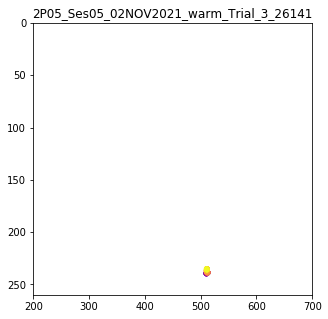

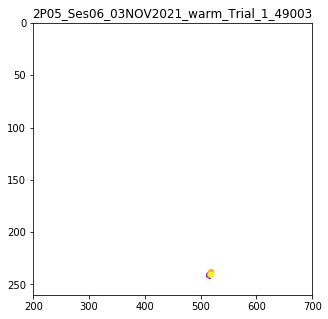

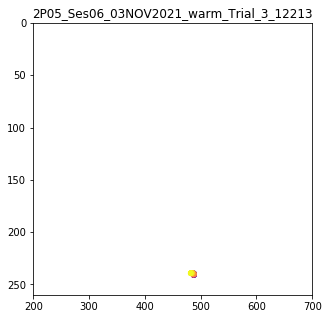

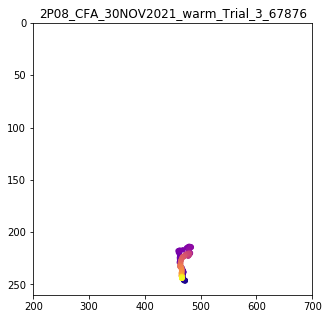

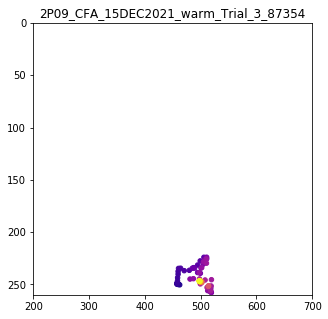

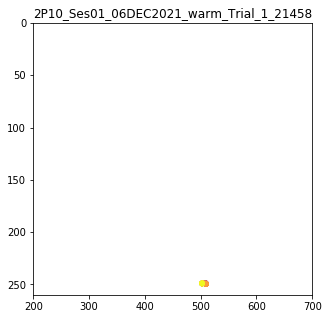

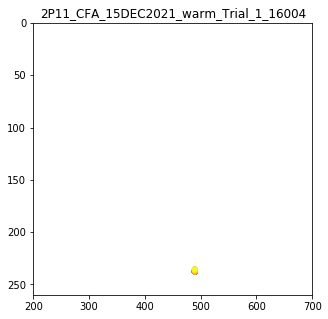

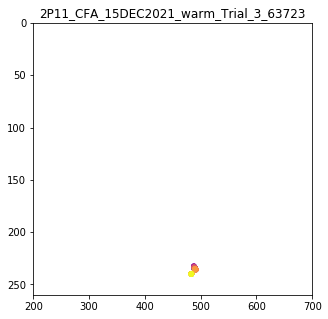

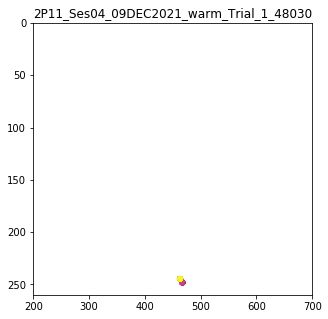

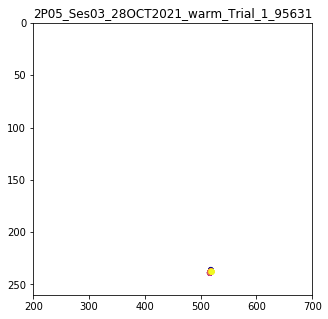

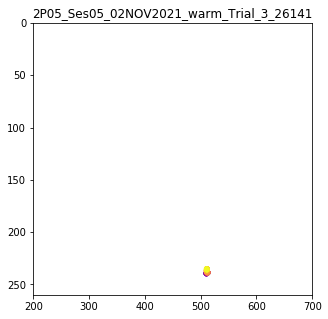

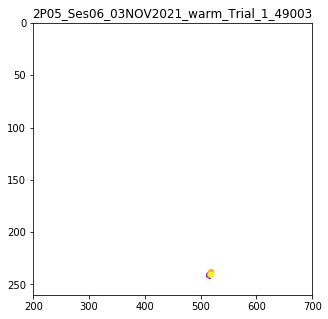

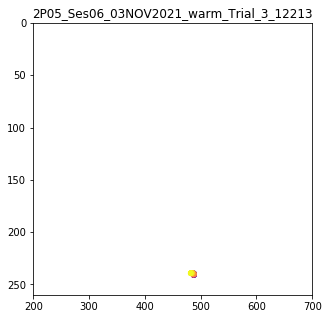

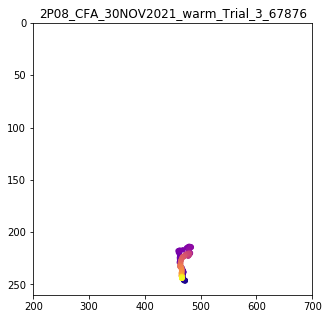

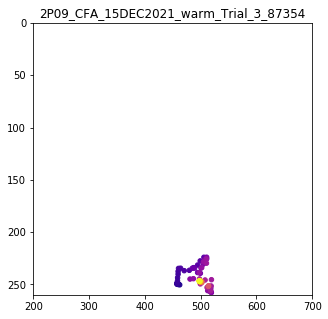

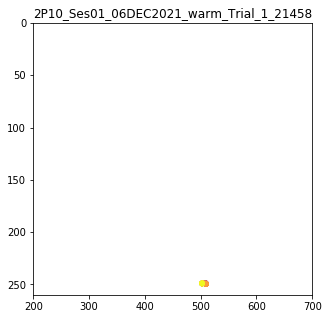

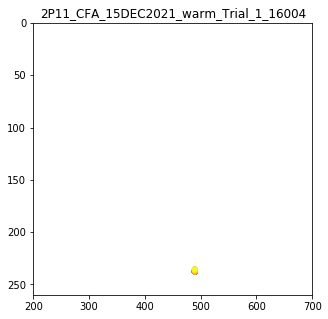

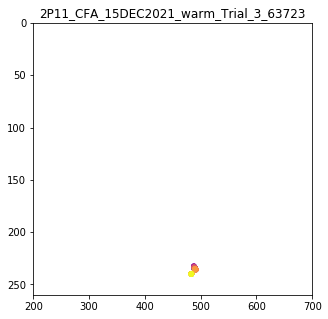

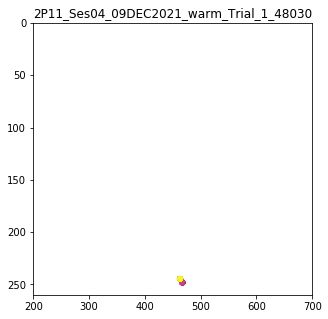

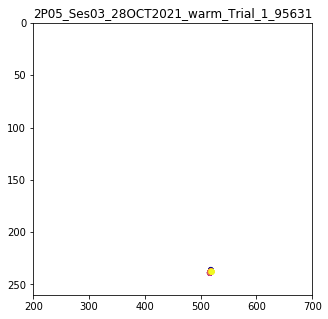

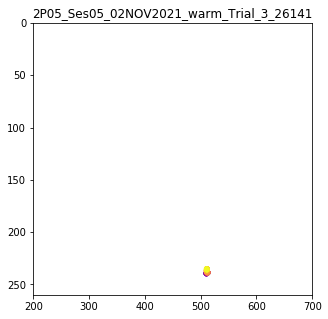

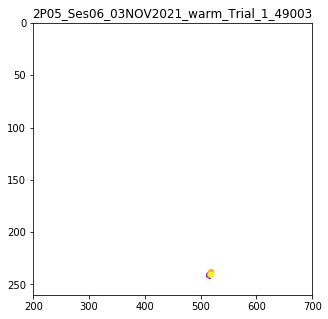

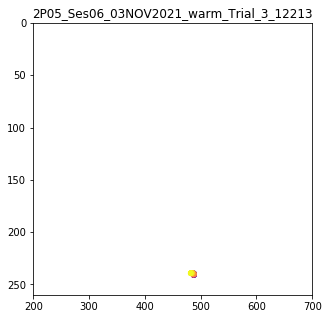

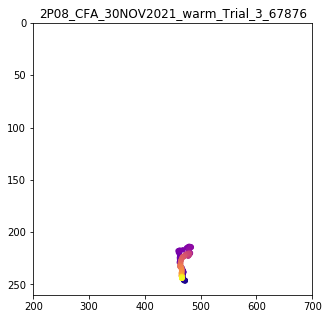

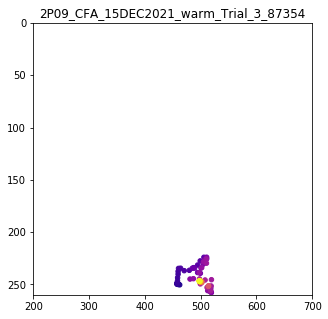

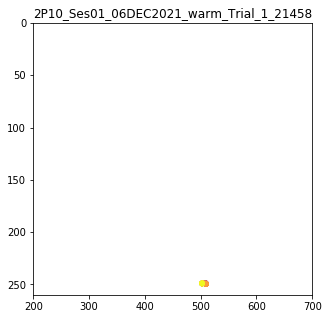

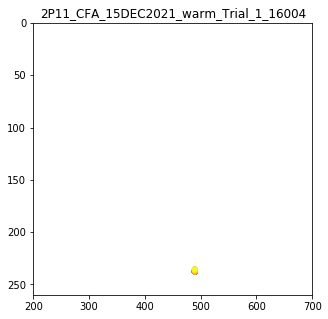

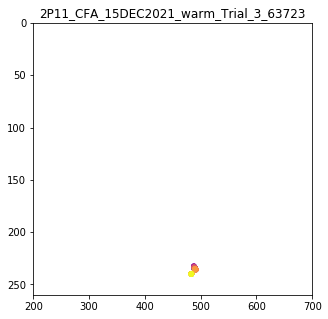

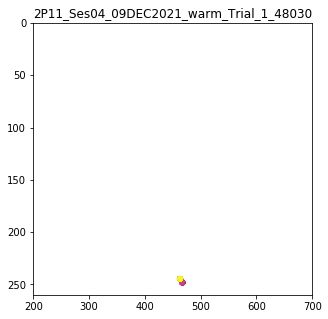

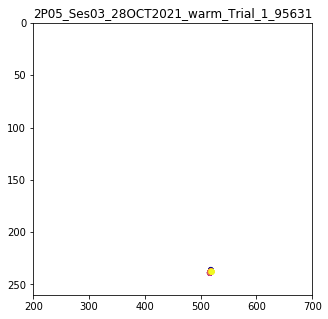

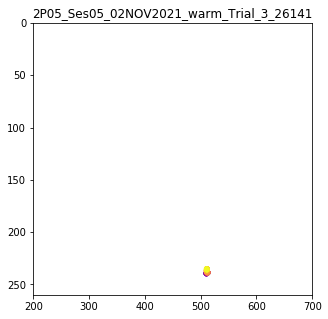

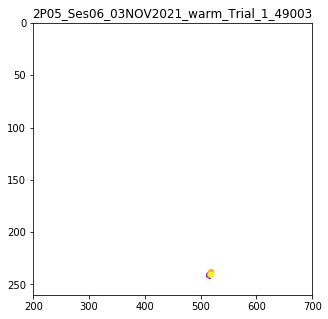

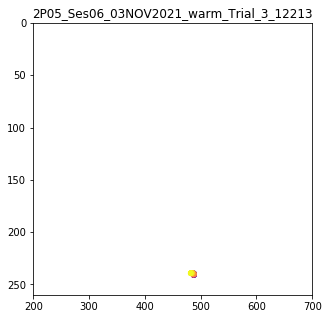

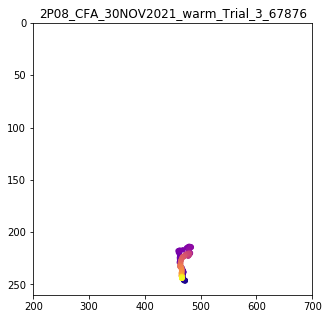

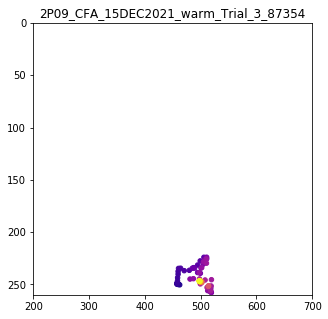

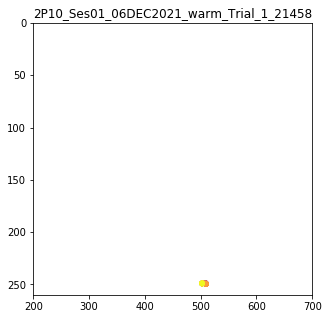

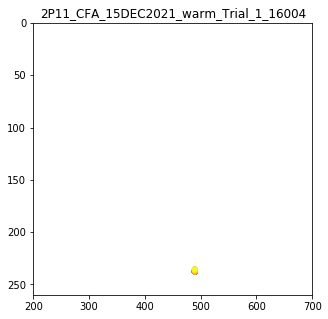

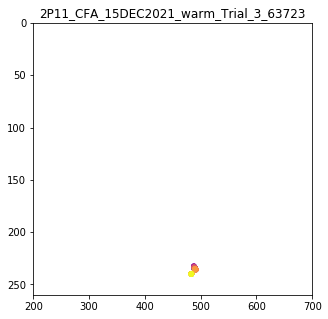

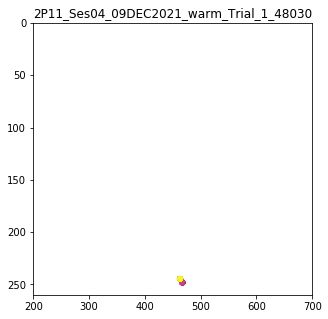

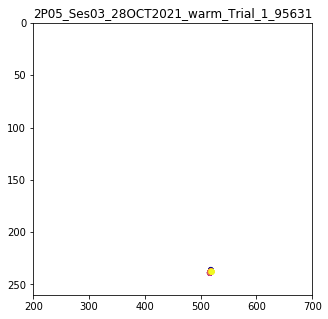

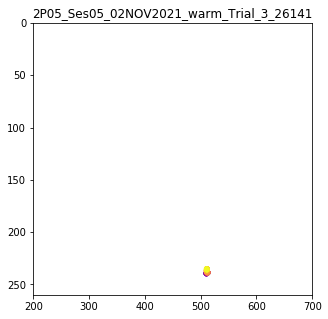

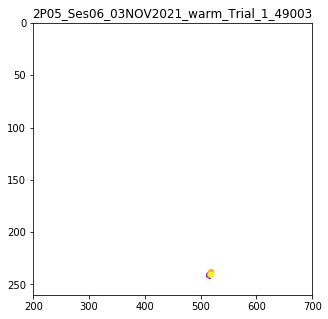

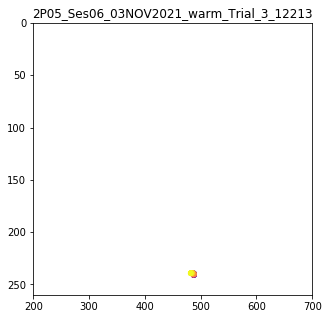

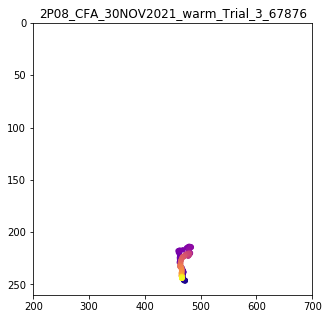

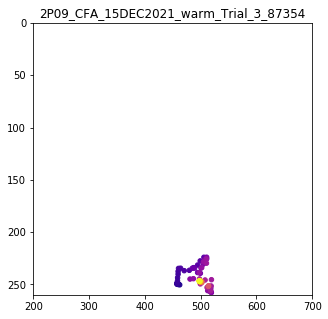

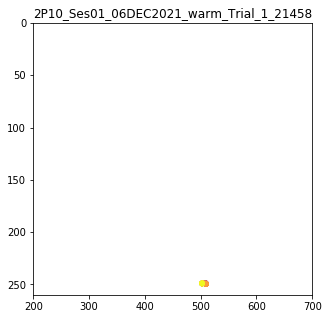

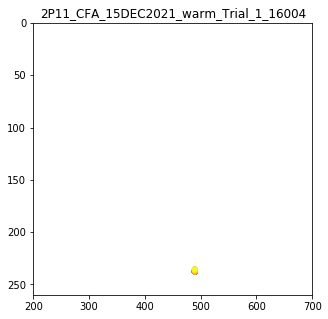

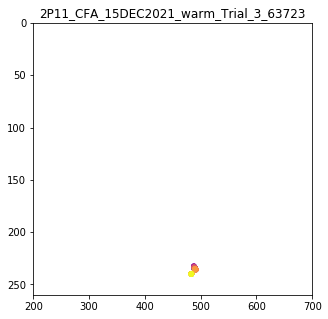

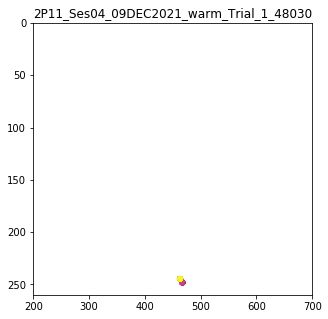

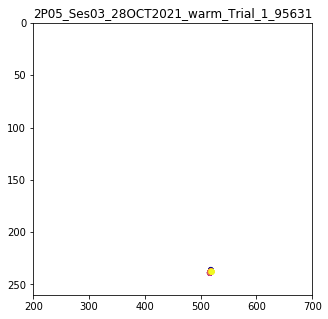

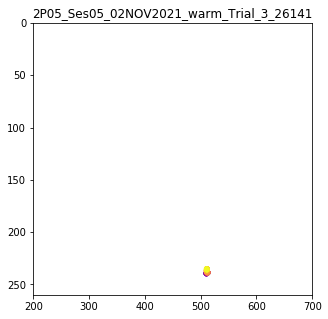

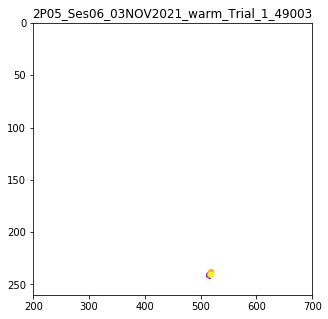

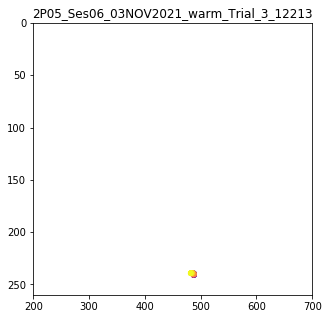

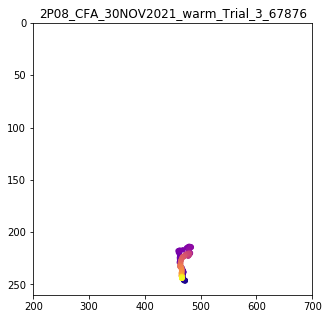

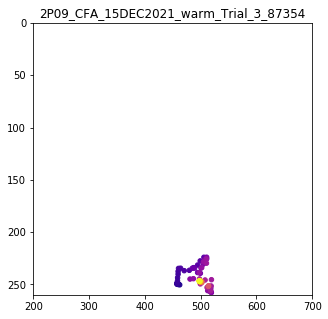

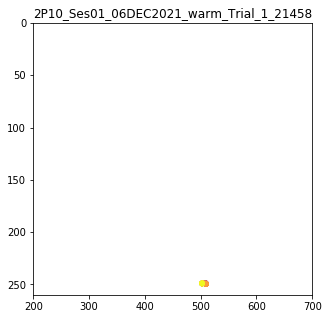

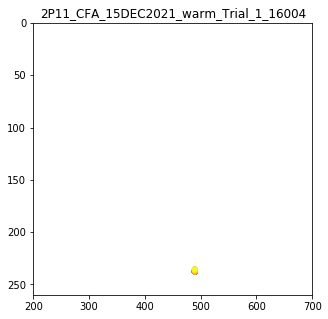

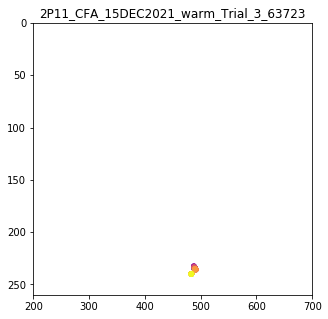

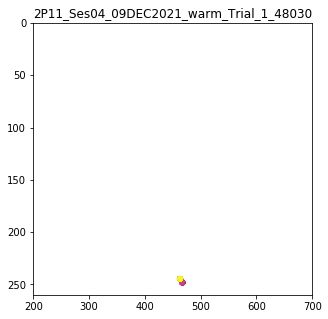

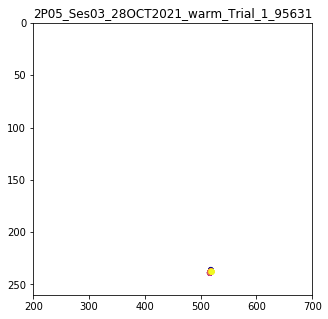

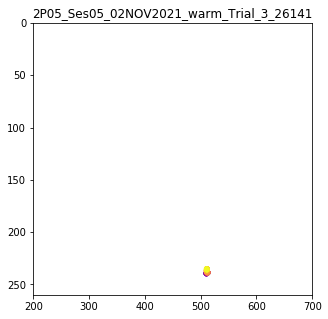

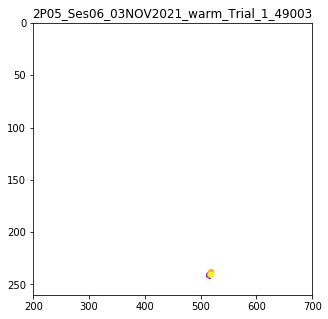

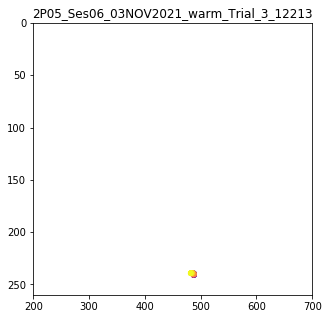

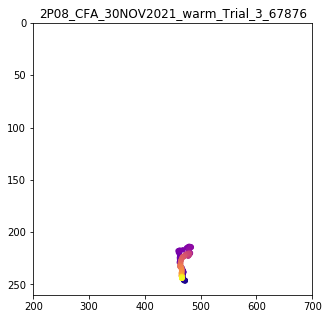

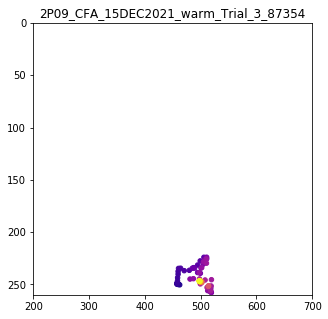

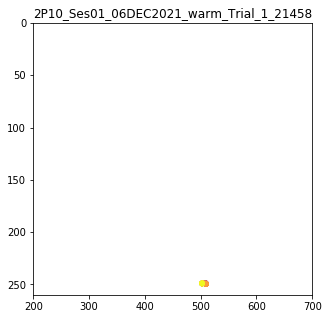

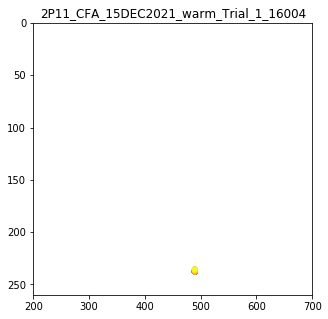

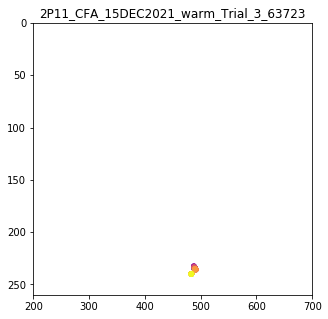

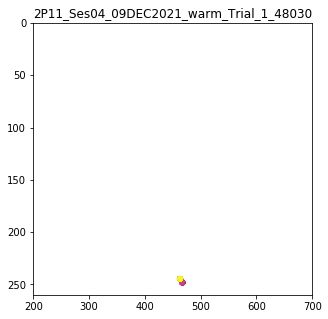

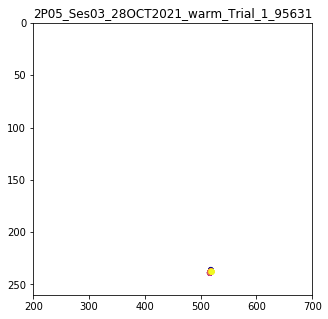

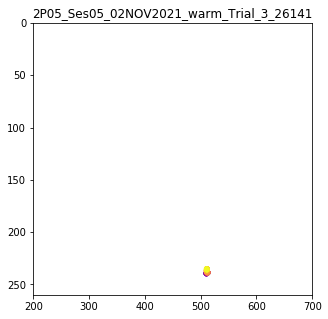

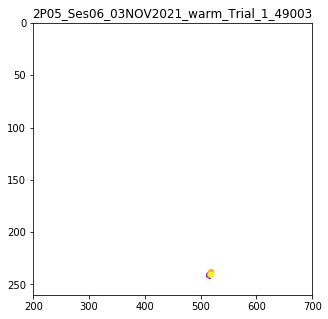

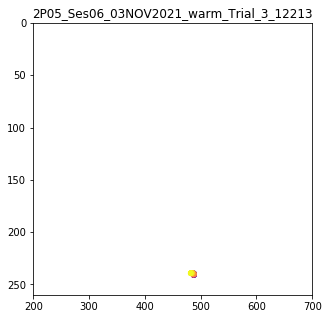

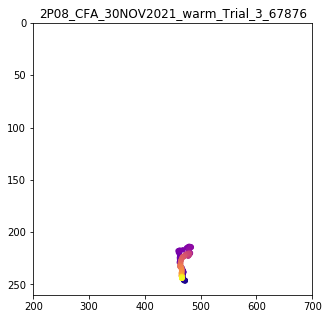

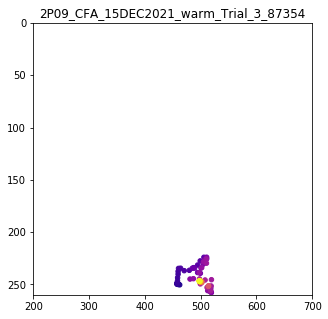

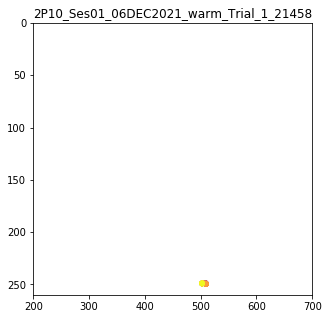

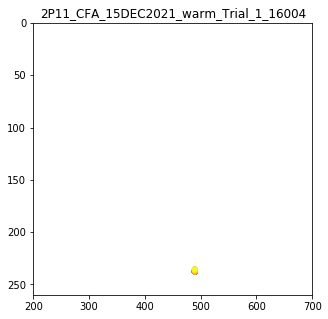

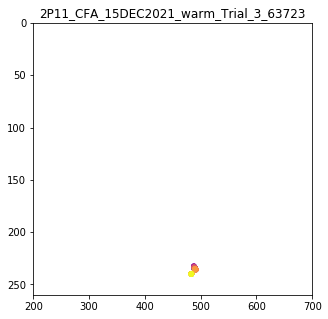

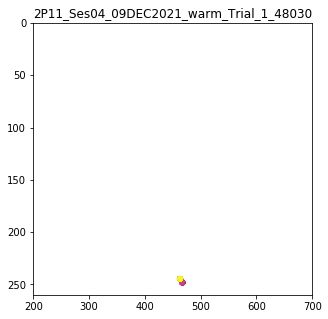

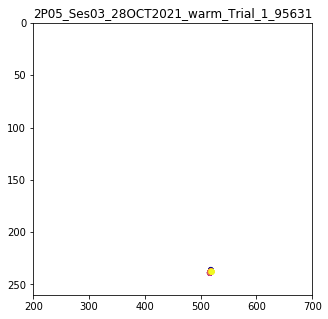

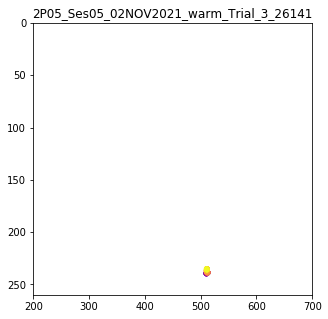

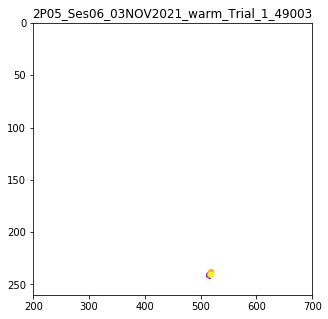

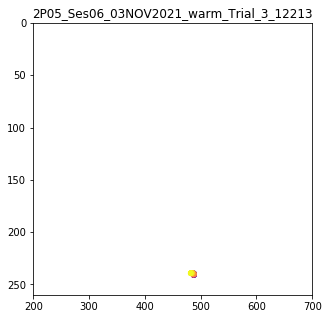

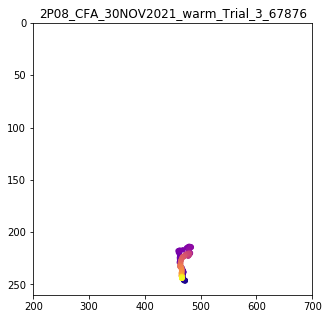

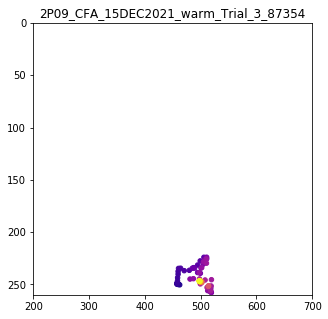

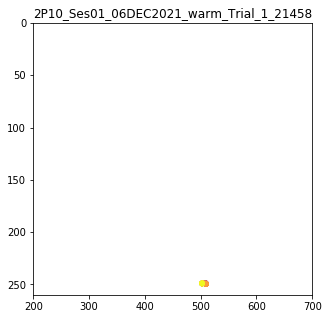

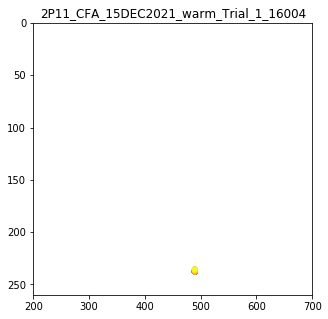

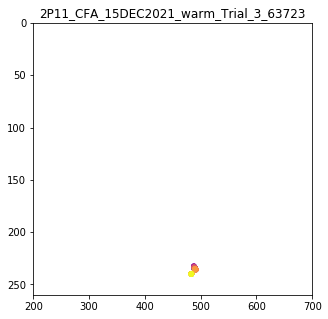

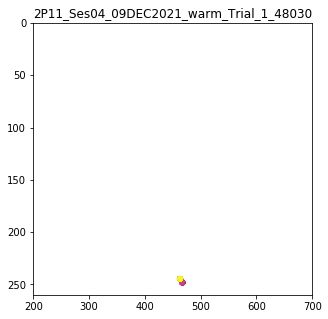

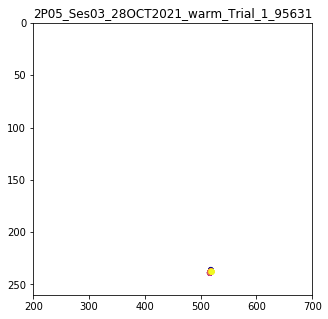

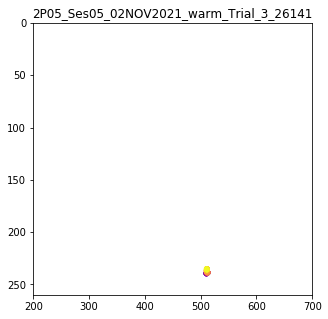

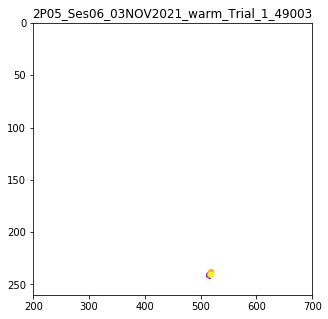

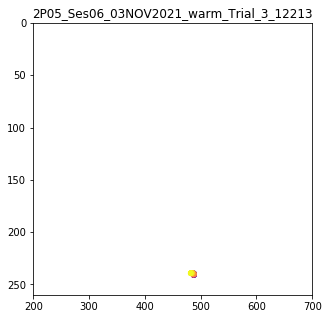

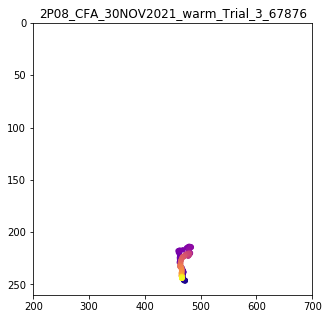

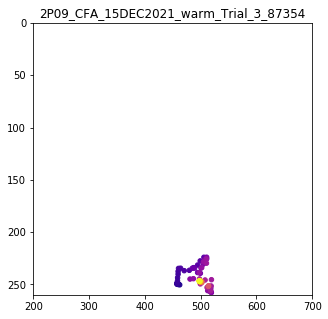

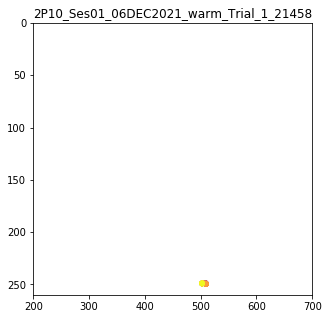

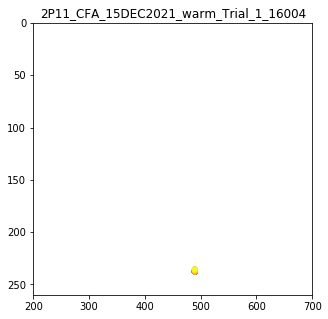

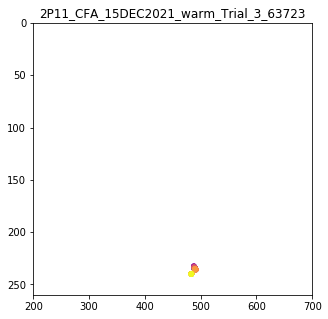

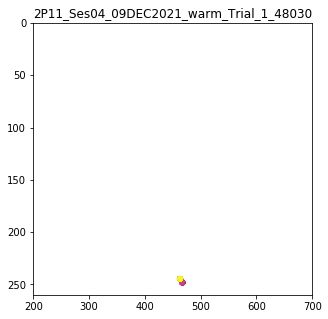

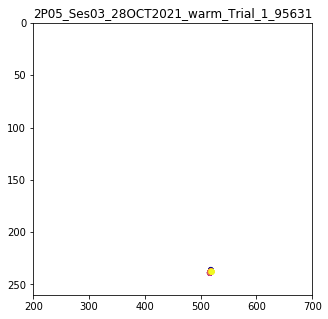

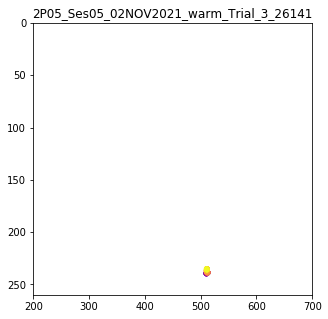

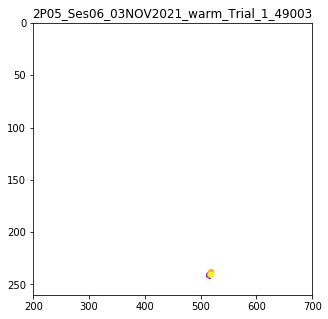

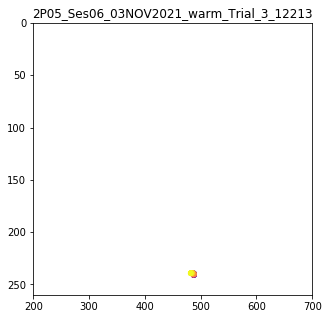

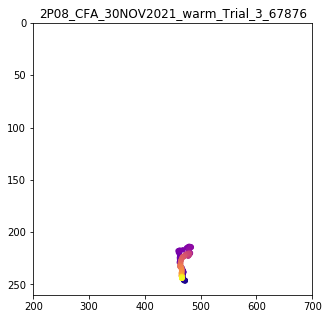

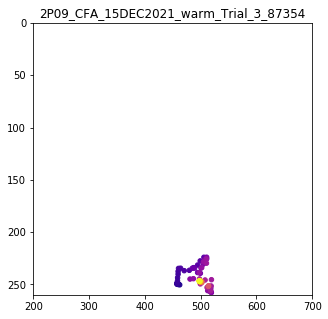

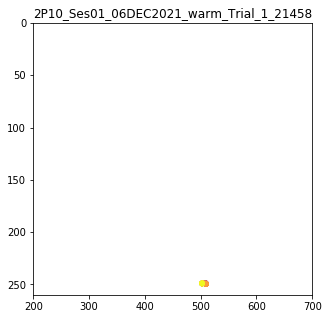

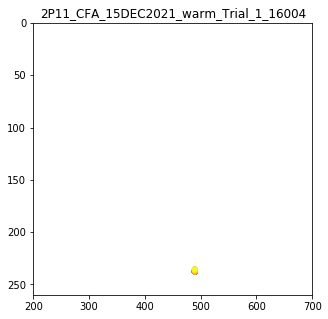

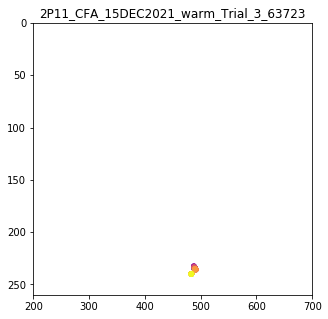

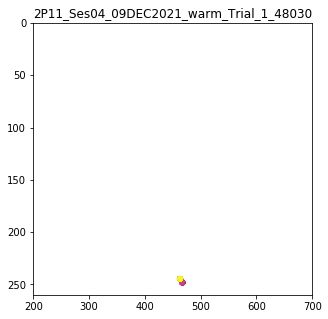

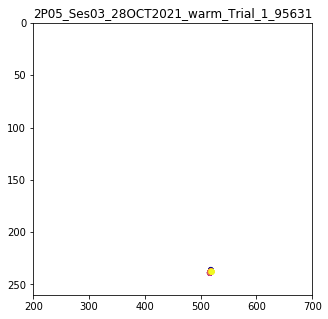

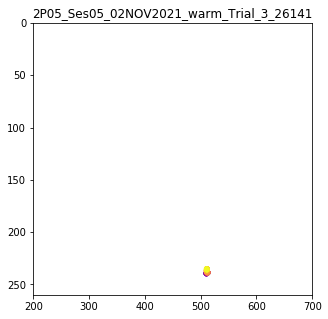

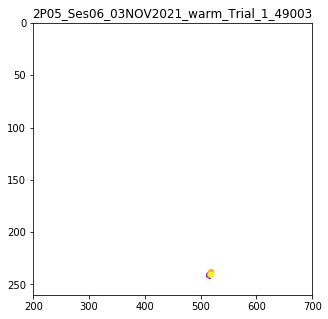

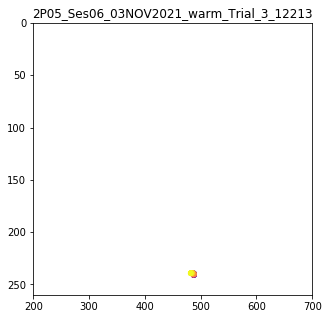

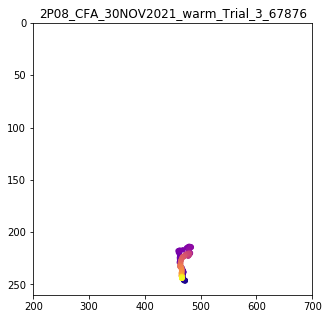

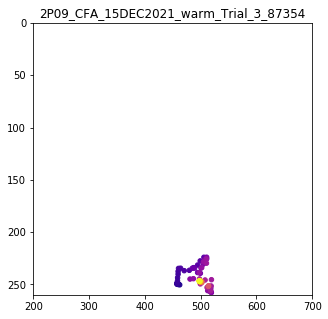

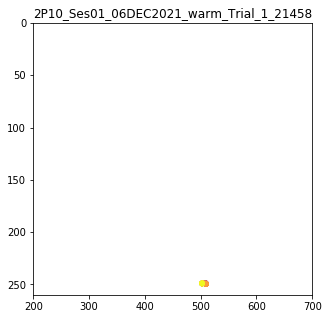

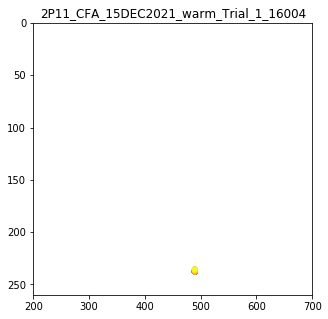

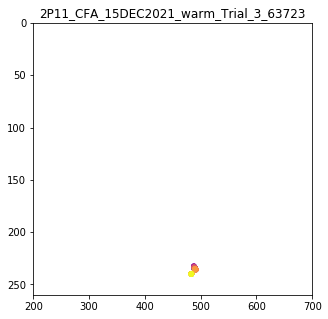

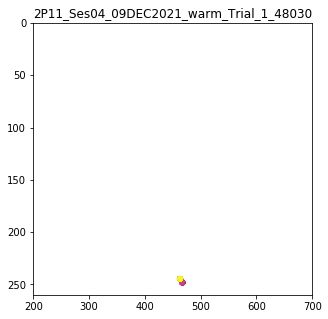

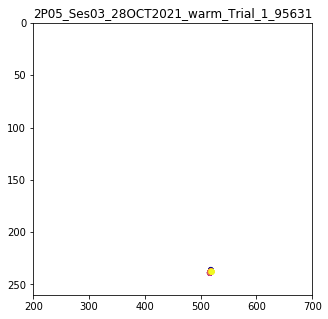

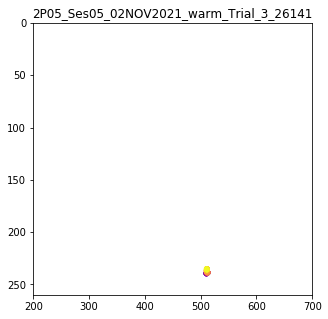

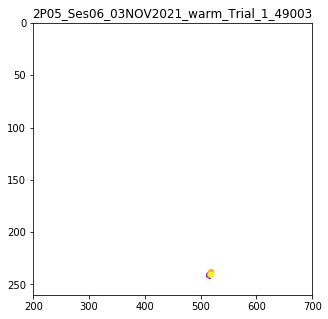

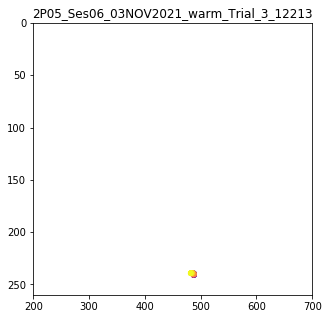

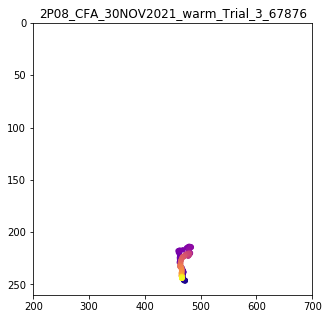

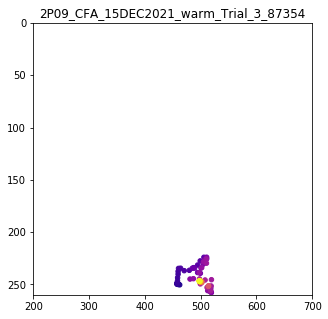

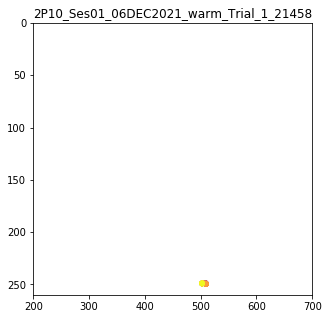

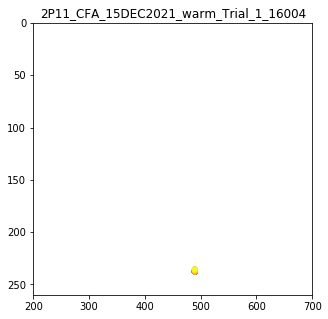

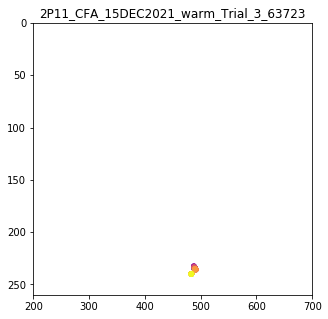

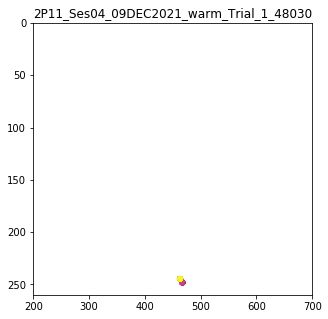

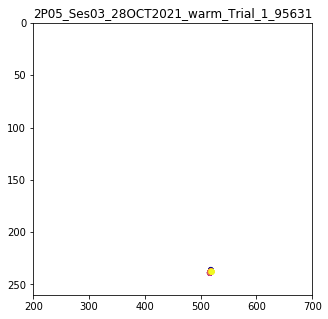

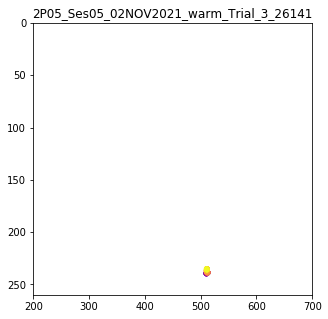

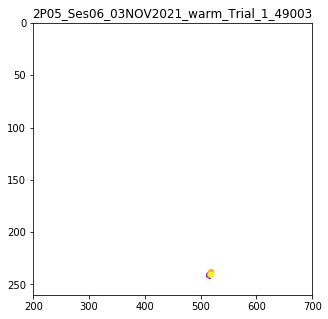

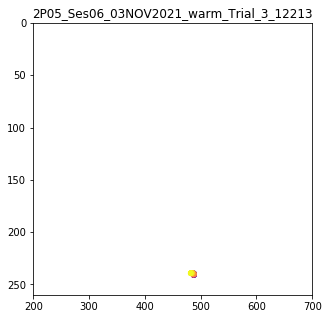

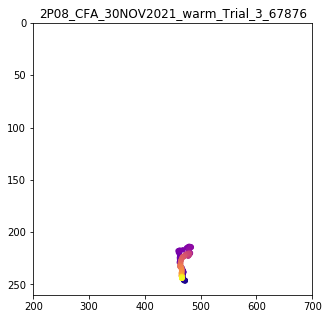

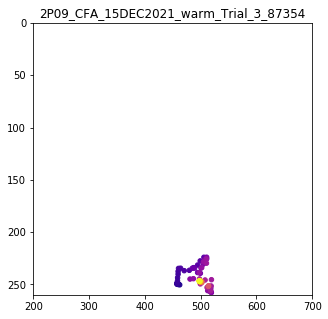

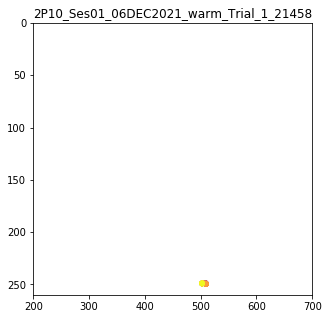

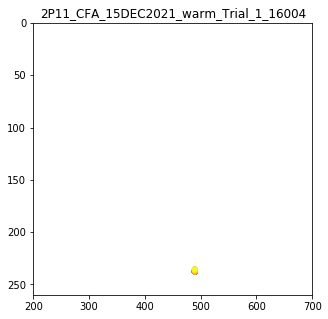

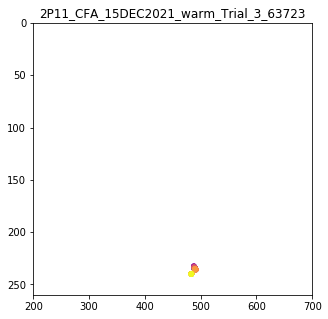

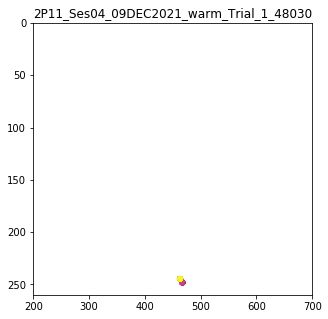

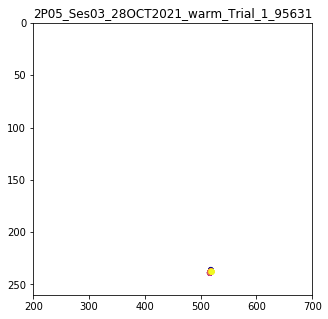

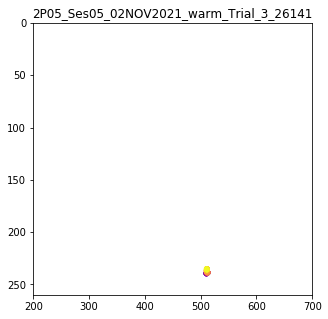

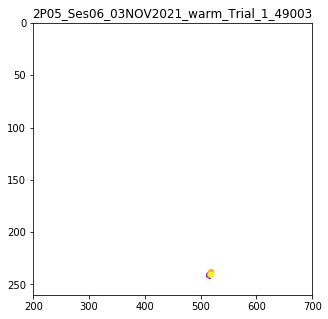

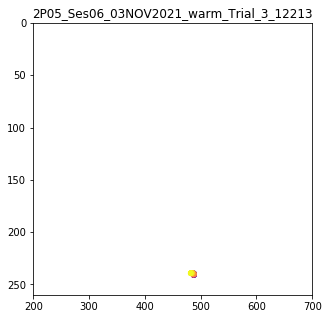

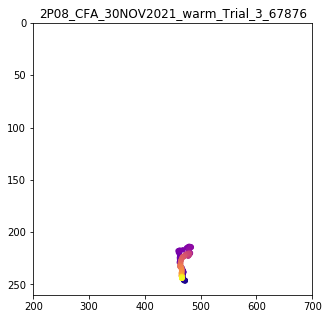

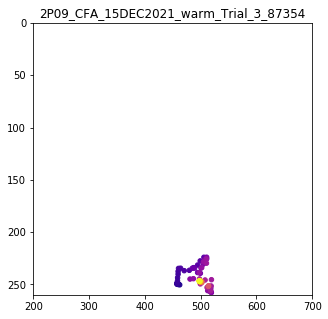

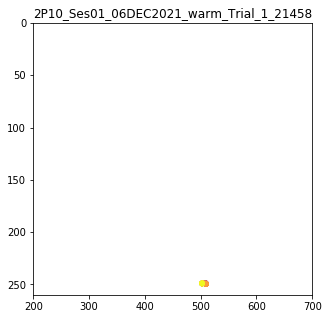

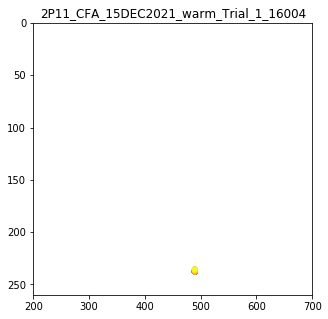

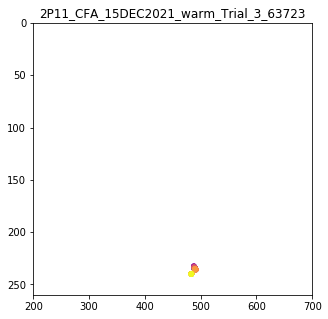

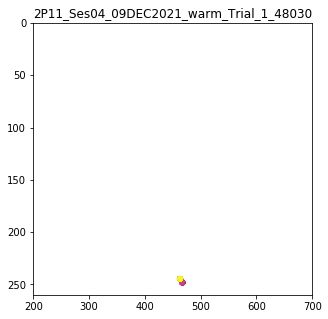

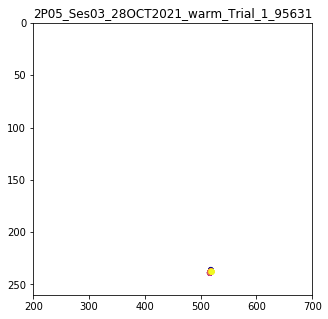

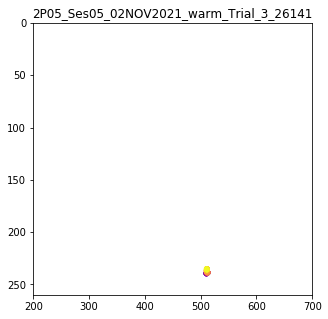

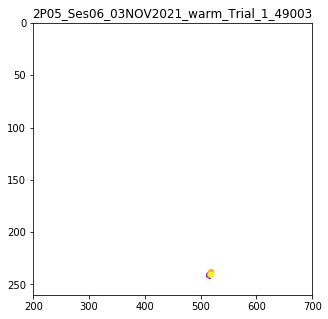

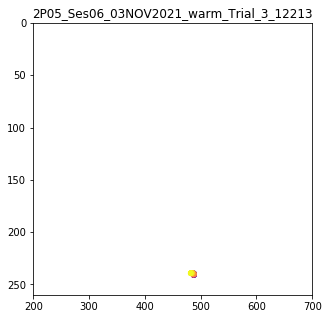

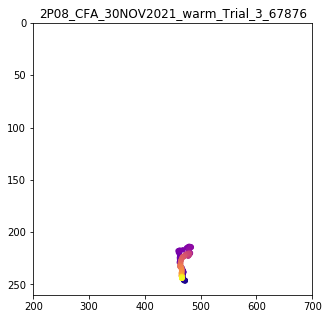

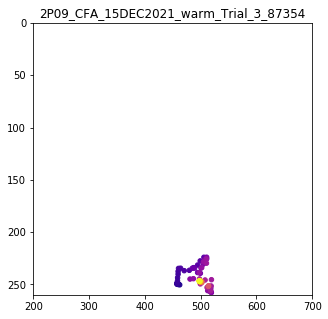

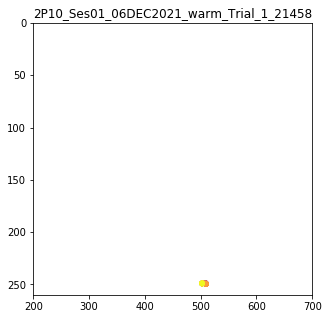

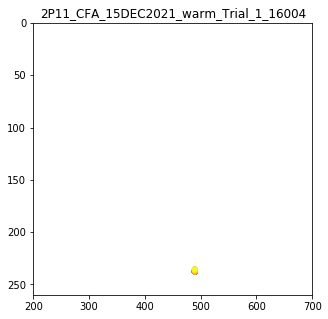

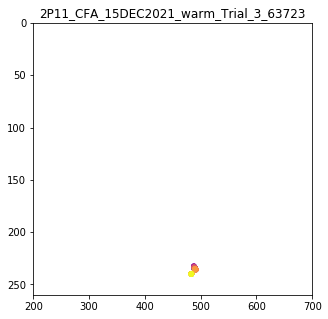

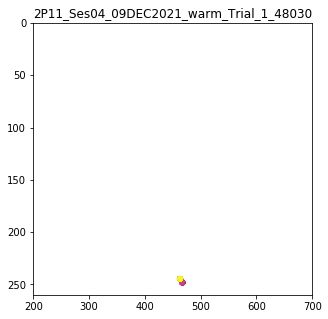

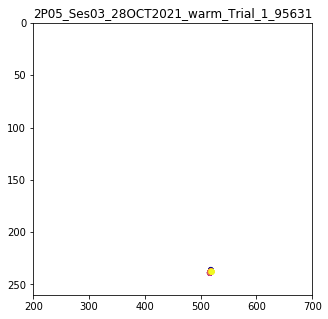

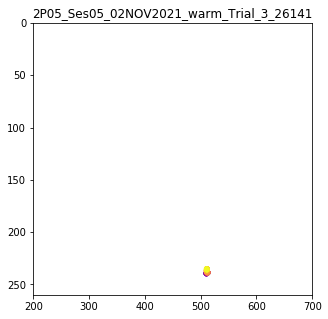

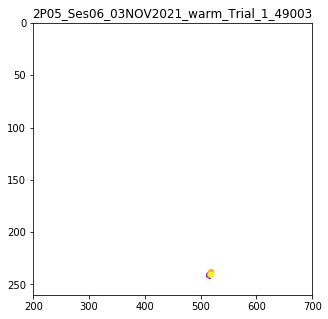

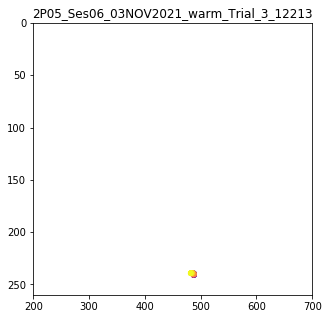

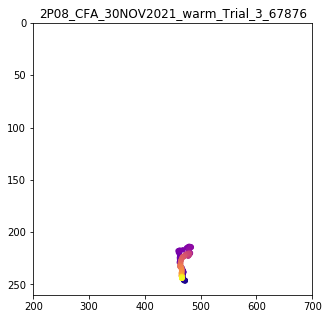

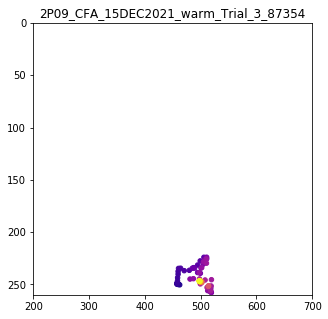

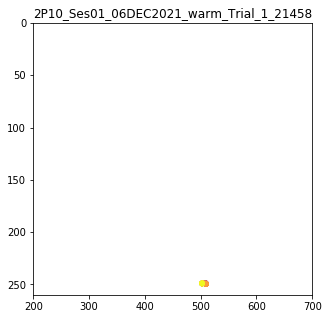

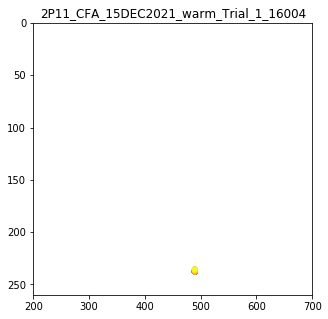

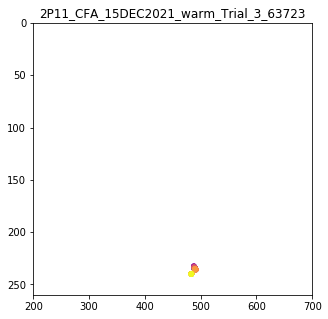

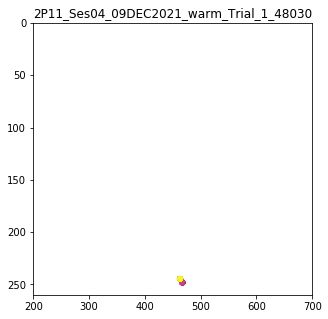

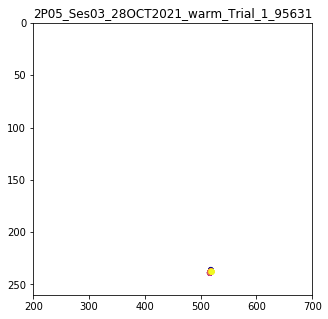

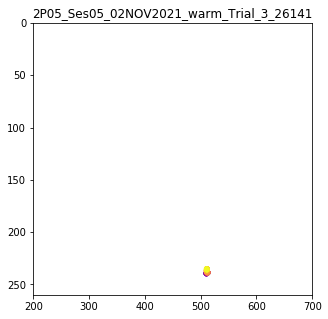

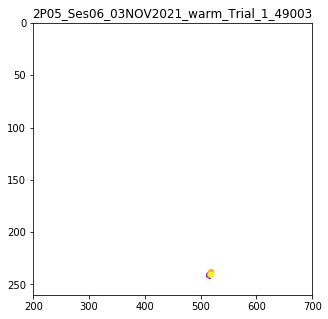

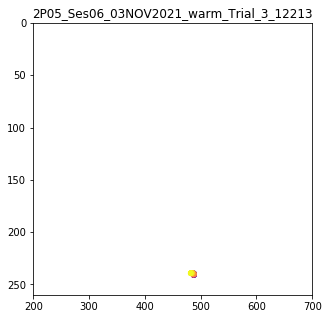

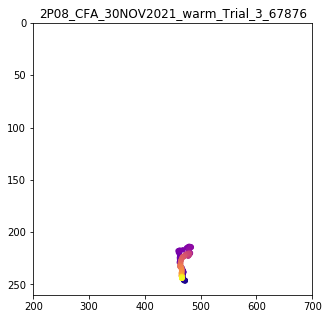

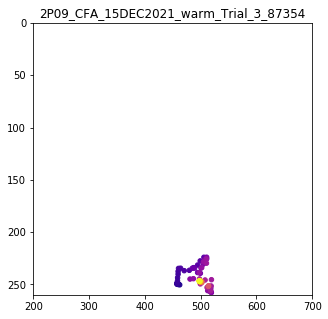

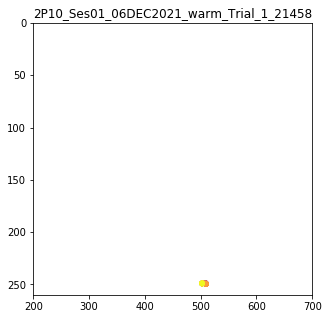

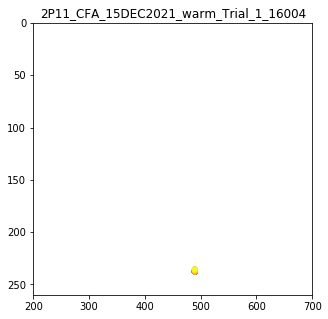

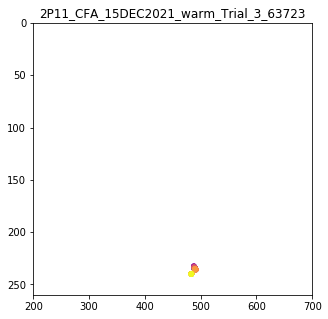

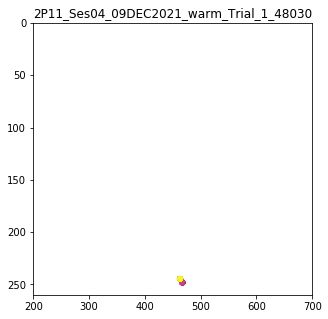

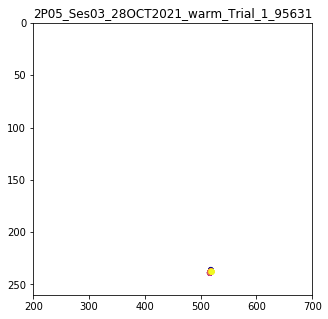

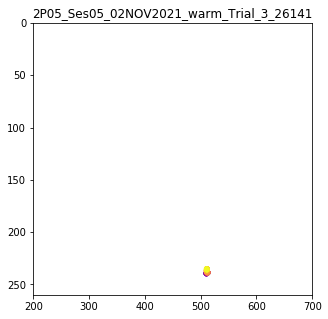

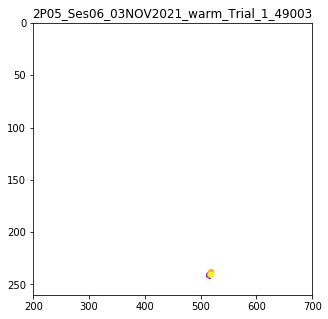

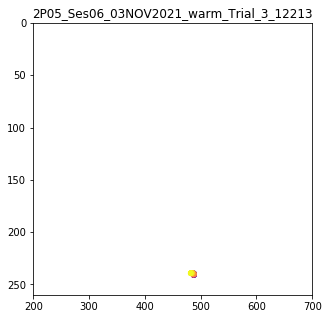

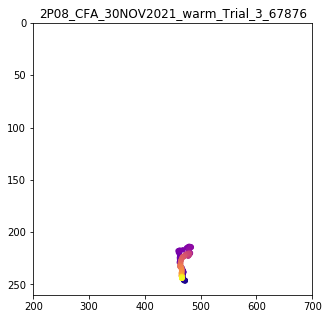

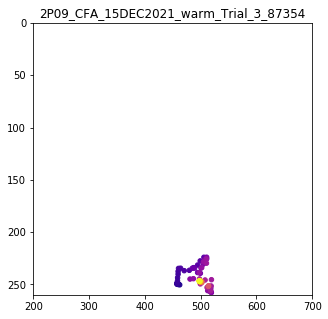

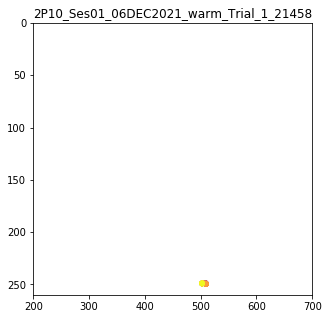

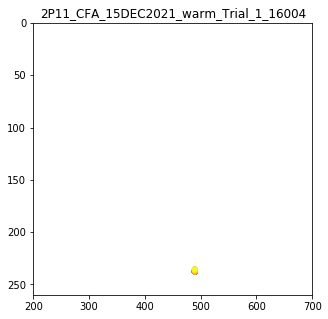

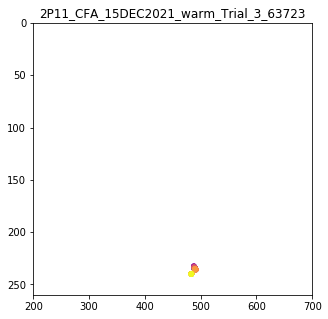

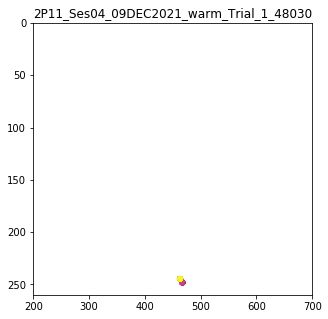

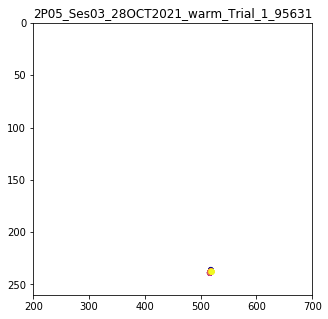

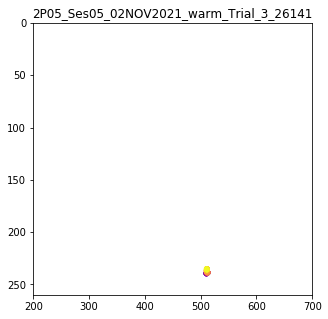

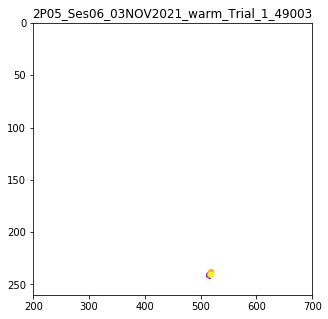

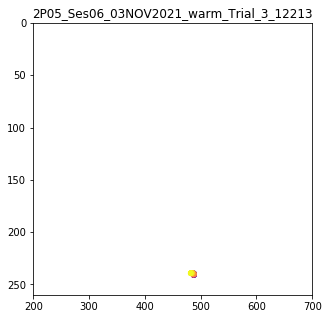

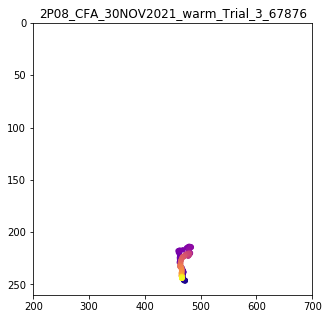

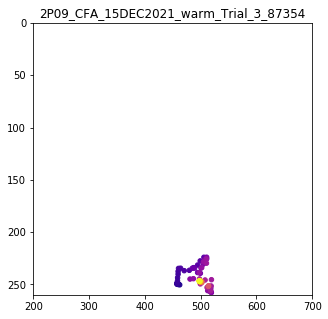

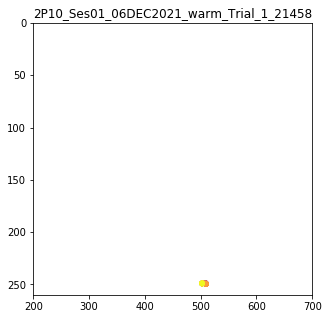

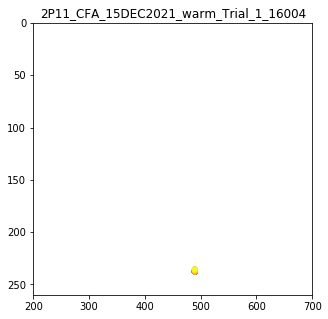

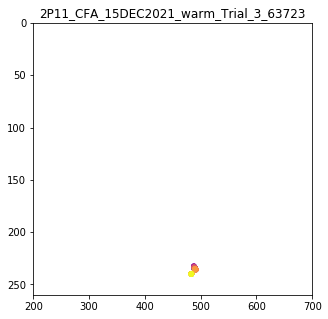

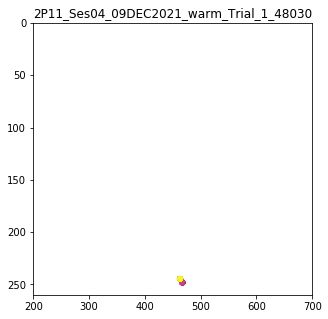

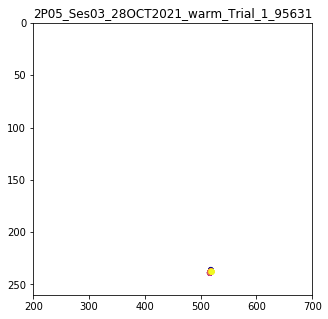

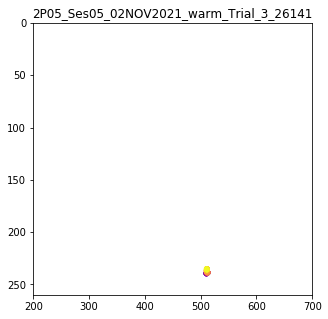

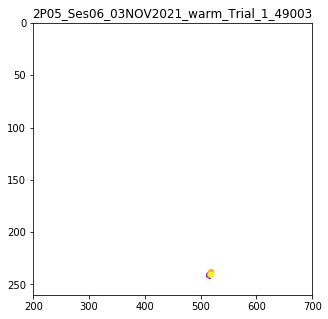

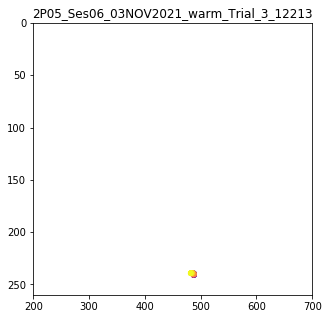

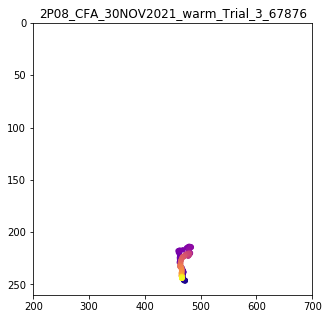

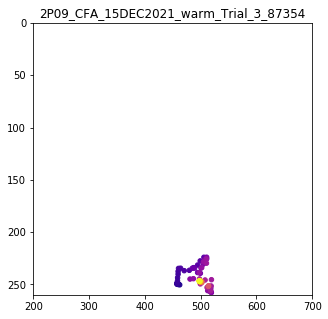

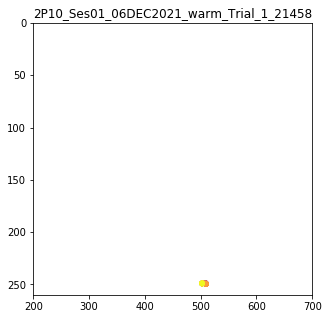

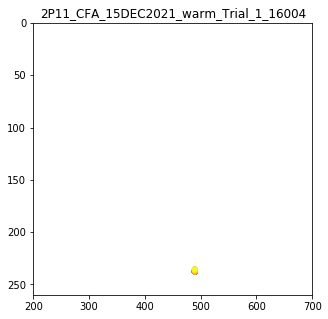

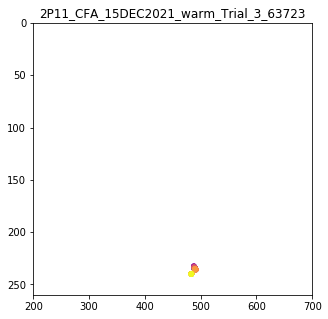

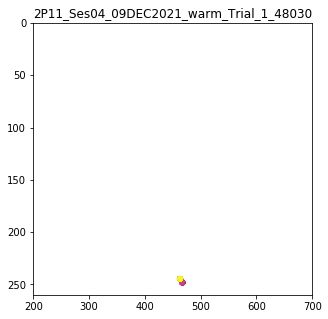

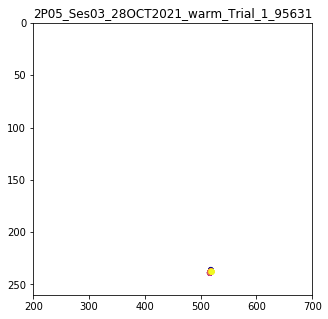

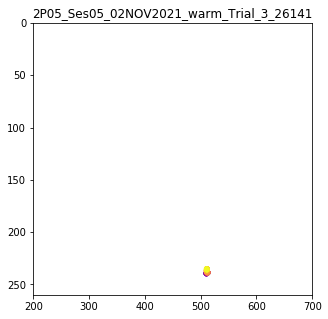

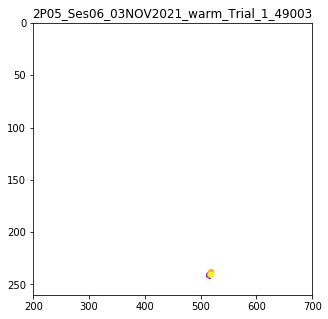

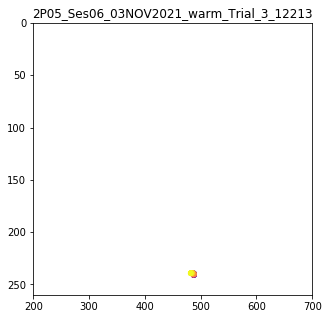

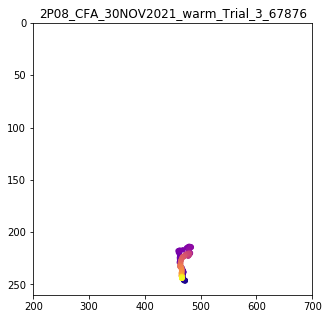

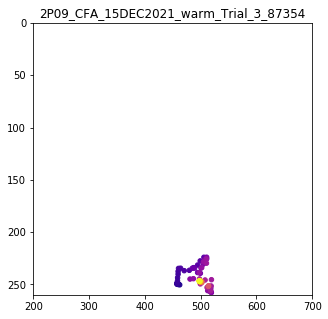

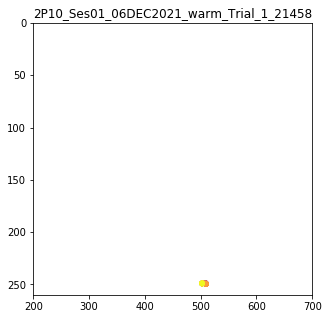

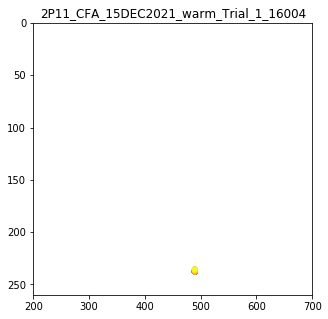

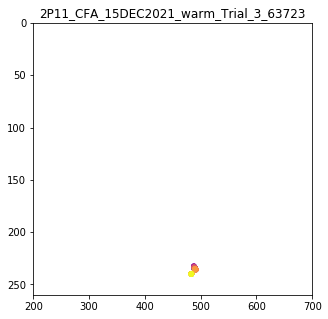

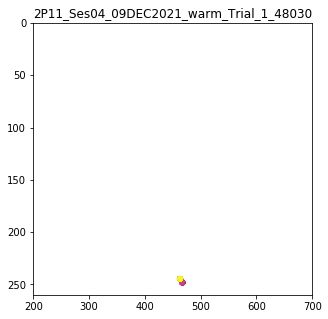

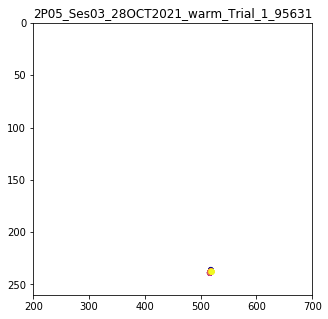

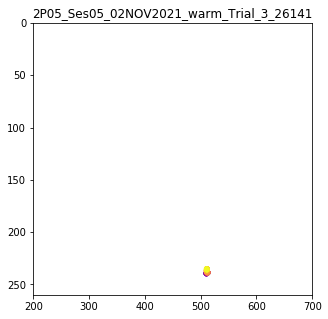

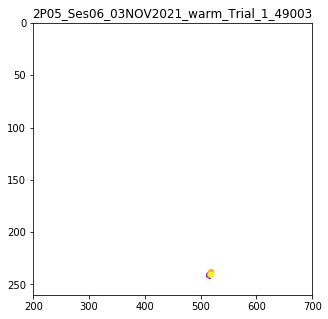

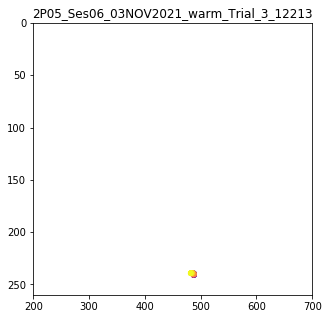

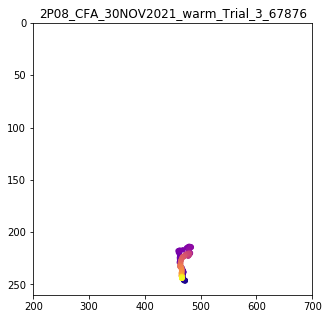

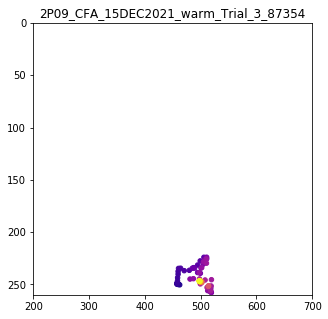

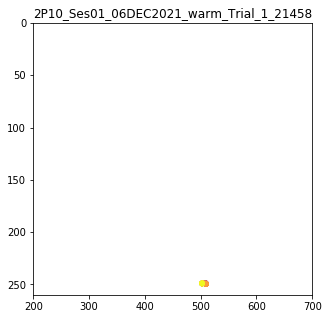

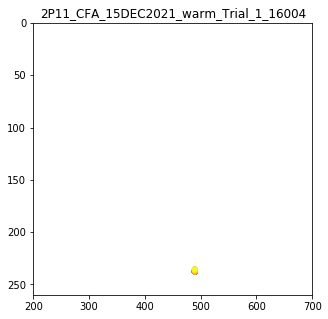

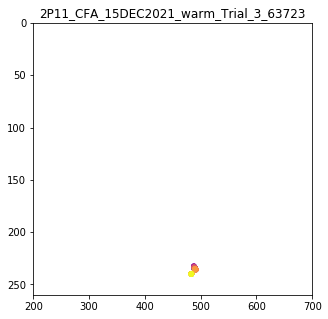

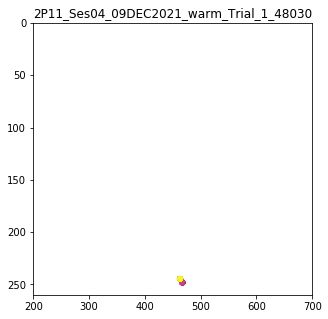

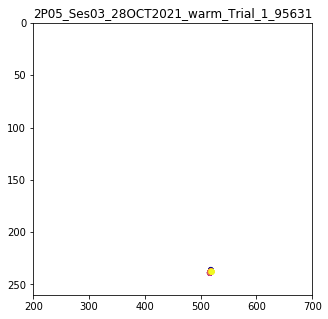

KeyboardInterrupt: 

In [8]:
stimulus = 'warm'

for body_id in body_ids:
    if stimulus in body_id:
        traces = resp_traces[resp_traces['trial'].str.contains(stimulus)]
        unique = list(traces['trial'].unique())
        
        for u in unique:
            i = np.linspace(1, 140, num=140)
            x = traces['ankle x'][traces['trial'].str.contains(u)]
            y = traces['ankle y'][traces['trial'].str.contains(u)]
            
            plt.figure(figsize=(5,5))
            plt.scatter(x, y,s=20,c=i, cmap='plasma',alpha=1)
            plt.title(u)
            plt.xlim((200,700))
            plt.ylim((260,0))
            #plt.axis('off')
            #plt.tight_layout()
        # plt.savefig('heel_dlc.pdf',dpi=300)
            plt.show()

In [198]:
local_responses.head()

trial     response on_latency  \
0  2P05_Ses01_25OCT2021_approach_Trial_1_89009  no response        NaN   
1  2P05_Ses01_25OCT2021_approach_Trial_2_94245  no response        NaN   
2  2P05_Ses01_25OCT2021_approach_Trial_3_80975  no response        NaN   
3       2P05_Ses01_25OCT2021_hot_Trial_1_44807  no response        NaN   
4       2P05_Ses01_25OCT2021_hot_Trial_2_24745     discrete       37.5   

  off_latency peak_response euclidean_peak  
0         NaN           NaN            NaN  
1         NaN           NaN            NaN  
2         NaN           NaN            NaN  
3         NaN           NaN            NaN  
4        45.0    231.229507       2.124161

In [5]:
health = local_responses[local_responses['trial'].str.contains(str('Ses'))]
cfa = local_responses[local_responses['trial'].str.contains(str('CFA'))]
health

trial     response  on_latency  \
0     2P05_Ses01_25OCT2021_approach_Trial_1_89009  no response         NaN   
1     2P05_Ses01_25OCT2021_approach_Trial_2_94245  no response         NaN   
2     2P05_Ses01_25OCT2021_approach_Trial_3_80975  no response         NaN   
3          2P05_Ses01_25OCT2021_hot_Trial_1_44807  no response         NaN   
4          2P05_Ses01_25OCT2021_hot_Trial_2_24745     discrete        37.5   
...                                           ...          ...         ...   
1051  2P11_Ses06_13DEC2021_von frey_Trial_2_67176  no response         NaN   
1052  2P11_Ses06_13DEC2021_von frey_Trial_3_86179  no response         NaN   
1053      2P11_Ses06_13DEC2021_warm_Trial_1_67893  no response         NaN   
1054      2P11_Ses06_13DEC2021_warm_Trial_2_59801  no response         NaN   
1055      2P11_Ses06_13DEC2021_warm_Trial_3_96813  no response         NaN   

      off_latency  peak_response  euclidean_peak  
0             NaN            NaN             NaN  
1             NaN            NaN             NaN  
2             NaN            NaN             NaN  
3             NaN            NaN             NaN  
4            45.0     231.229507        2.124161  
...           ...            ...             ...  
1051          NaN            NaN             NaN  
1052          NaN            NaN             NaN  
1053          NaN            NaN             NaN  
1054          NaN            NaN             NaN  
1055          NaN            NaN             NaN  

[950 rows x 6 columns]

[(-5, 150)]

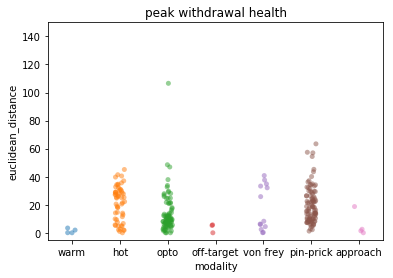

In [200]:
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

eu_data = pd.DataFrame(columns=['modality', 'euclidean_distance'])

for s in stimuli:
    df1=pd.DataFrame()
    df = health[health['trial'].str.contains(str(s))]
    eu = df[df['euclidean_peak']!='NaN']
    eu = eu['euclidean_peak']
    df1['euclidean_distance'] = eu
    mod = [s] * len(eu)
    df1['modality'] = mod
    eu_data = pd.concat([eu_data, df1], axis=0)

eu_data.to_csv(r'/Users/aspra/Desktop/eu_data_health.csv')

ax = sns.stripplot(data = eu_data, x = 'modality', y = 'euclidean_distance', alpha=0.5, size=5)
ax.set(title = 'peak withdrawal health')
ax.set(ylim=[-5,150])


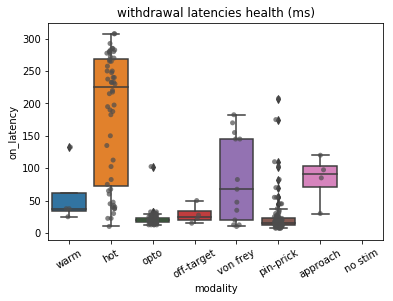

In [21]:
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

lat_data = pd.DataFrame(columns=['modality', 'on_latency'])

for s in stimuli:
    df1=pd.DataFrame()
    df = health[health['trial'].str.contains(str(s))]
    lat = df[df['on_latency']!='NaN']
    lat = lat['on_latency']
    df1['on_latency'] = lat
    mod = [s] * len(lat)
    df1['modality'] = mod
    lat_data = pd.concat([lat_data, df1], axis=0)

lat_data.to_csv(r'/Users/aspra/Desktop/lat_data_health.csv')

ax = sns.stripplot(data = lat_data, x = 'modality', y = 'on_latency', alpha=0.7, size=5, color='0.3')
ax = sns.boxplot(data = lat_data, x = 'modality', y = 'on_latency')
ax.set(title = 'withdrawal latencies health (ms)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#ax.set(ylim=[-5,150])
plt.savefig('/Users/aspra/Desktop/S1 Project Desktop /S1 2P Paw Withdrawal Analysis/withdrawal lat health.png', bbox_inches='tight')

[(-5, 150)]

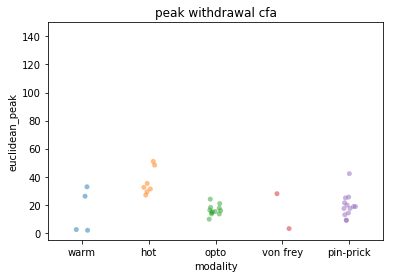

In [201]:

stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

eu_data = pd.DataFrame(columns=['modality', 'euclidean_peak'])

for s in stimuli:
    df1=pd.DataFrame()
    df = cfa[cfa['trial'].str.contains(str(s))]
    eu = df[df['euclidean_peak']!='NaN']
    eu = eu['euclidean_peak']
    df1['euclidean_peak'] = eu
    mod = [s] * len(eu)
    df1['modality'] = mod
    eu_data = pd.concat([eu_data, df1], axis=0)

eu_data.to_csv(r'/Users/aspra/Desktop/eu_data_cfa.csv')

ax = sns.stripplot(data = eu_data, x = 'modality', y = 'euclidean_peak', alpha=0.5, size=5)
ax.set(title = 'peak withdrawal cfa')
ax.set(ylim=[-5,150])

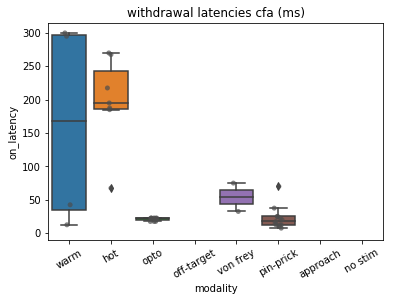

In [22]:
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

lat_data = pd.DataFrame(columns=['modality', 'on_latency'])

for s in stimuli:
    df1=pd.DataFrame()
    df = cfa[cfa['trial'].str.contains(str(s))]
    lat = df[df['on_latency']!='NaN']
    lat = lat['on_latency']
    df1['on_latency'] = lat
    mod = [s] * len(lat)
    df1['modality'] = mod
    lat_data = pd.concat([lat_data, df1], axis=0)

lat_data.to_csv(r'/Users/aspra/Desktop/lat_data_cfa.csv')

ax = sns.stripplot(data = lat_data, x = 'modality', y = 'on_latency', alpha=0.7, size=5, color='0.3')
ax = sns.boxplot(data = lat_data, x = 'modality', y = 'on_latency')
ax.set(title = 'withdrawal latencies cfa (ms)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.savefig('/Users/aspra/Desktop/S1 Project Desktop /S1 2P Paw Withdrawal Analysis/withdrawal lat cfa.png', bbox_inches='tight')

## 